## 📚 Prerequisites

Before executing this notebook, make sure you have properly set up your Azure Services, created your Conda environment, and configured your environment variables as per the instructions provided in the [README.md](README.md) file.


## Understanding Quantitative Measures of Relevance

In order to evaluate the effectiveness of our search system, we use several metrics that measure the relevance of the results it returns. These metrics help us understand how well our system is performing and guide us in tuning it for better performance.

+ **NDCG@10**: Normalized Discounted Cumulative Gain at 10 (NDCG@10) is a metric that assesses the effectiveness of a retrieval system at finding and correctly ordering the top 10 documents. The score ranges from 0 to 100, with higher scores indicating that the system's ordered list of documents closely matches the ideal order. This metric is widely used because it balances the need for precision (returning relevant results) with the need for proper sequencing (ordering the results correctly).

- **NDCG@3**: NDCG@3 is similar to NDCG@10, but it focuses on the top 3 documents. This metric is particularly relevant in contexts where it's crucial to have the highest accuracy in the topmost results, such as in generative AI applications. NDCG@3 measures the system's ability to identify and correctly rank the three most relevant documents.

+ **Recall@50**: Recall@50 measures the proportion of high-quality documents identified within the top 50 results. It's calculated by counting the number of documents rated as high quality by a scoring prompt and dividing this by the total number of known good documents for a given query. This metric is useful for assessing the system's ability to retrieve a broad set of relevant documents from a large pool.

To automate the evaluation process, we use supervised tuning techniques. These techniques involve training a model on a labeled dataset, where the labels indicate the relevance of the documents to the queries. The model learns to predict the relevance of a document to a query, and we can then use these predictions to calculate the metrics above. This allows us to measure the relevance of our queries in an automated and scalable way.

## Dataset Creation

To assess the qualitative performance of our search store in alignment with the BEIR framework, we follow a three-step process to generate our evaluation dataset:

1. **Corpus Creation:**
   We begin by extracting document chunks from our Azure Search index. These chunks are consolidated into a corpus file (`corpus.jsonl`), ensuring that the foundational set of documents is standardized and comprehensive for subsequent evaluation.

2. **Query Generation:**
   Next, we utilize GPT-4o to generate a diverse set of queries based on five carefully selected diagnosis and medication scenarios from our medical index. This targeted approach ensures that the queries are medically relevant and reflective of real-world clinical information needs. The generated queries are stored in `queries.jsonl`.

3. **Relevance Judgments:**
   Finally, we employ an LLM-as-a-judge to evaluate the relevance of the documents with respect to each query. This evaluation produces relevance judgments that are saved in `qrel.jsonl`. These qrels form the basis for computing our performance metrics, including NDCG@10, NDCG@3, and Recall@50.

You can use the below cells to generate your own dataset, please uncomment the code and run it. The dataset will be saved in the `evals/benchmark/medindexer` directory, where our existing datasets have been curated.


In [1]:
from opentelemetry.propagate import extract

from src.pipeline.promptEngineering.prompt_manager import PromptManager
from src.aoai.aoai_helper import AzureOpenAIManager
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from dotenv import load_dotenv
import nest_asyncio
import asyncio
import json
import os
from tqdm import tqdm
import math
import json
import os
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.models import (
    VectorizableTextQuery,
    QueryType,
    QueryCaptionType,
    QueryAnswerType,
)
import json
from beir.retrieval.evaluation import EvaluateRetrieval
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

load_dotenv()

# Setup configuration variables for Azure and MedImageInsight
search_endpoint = os.getenv("AZURE_AI_SEARCH_SERVICE_ENDPOINT")
search_admin_key = os.getenv("AZURE_AI_SEARCH_ADMIN_KEY")
search_index_name = os.getenv("AZURE_IMAGES_SEARCH_INDEX_NAME", "ai-policies-index")
root = os.path.dirname(os.getcwd())
aoai_client = AzureOpenAIManager()
prompt_manager = PromptManager()

Templates found: ['evaluator_system_prompt.jinja', 'evaluator_user_prompt.jinja', 'formulator_system_prompt.jinja', 'formulator_user_prompt.jinja', 'ner_clinician_system.jinja', 'ner_clinician_user.jinja', 'ner_patient_system.jinja', 'ner_patient_user.jinja', 'ner_physician_system.jinja', 'ner_physician_user.jinja', 'ner_system_prompt.jinja', 'ner_user_prompt.jinja', 'prior_auth_o1_user_prompt.jinja', 'prior_auth_o1_user_prompt_b.jinja', 'prior_auth_system_prompt.jinja', 'prior_auth_user_prompt.jinja', 'query_classificator_system_prompt.jinja', 'query_classificator_user_prompt.jinja', 'query_expansion_system_prompt.jinja', 'query_expansion_user_prompt.jinja', 'query_generation_eval_system_prompt.jinja', 'query_generation_eval_user_prompt.jinja', 'query_relevance_eval_system_prompt.jinja', 'query_relevance_eval_user_prompt.jinja', 'summarize_policy_system.jinja', 'summarize_policy_user.jinja']


In [2]:
search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=search_index_name,
    credential=AzureKeyCredential(search_admin_key)
)

results = search_client.search("*", include_total_count=True)
dataset_dir = "evals/benchmark/medindexer"

# # Uncomment lines below to run the saving.
# with open(os.path.join(root, dataset_dir, "corpus.jsonl"), "w") as f:
#     for i, result in enumerate(results, start=1):
#         # Remove keys starting with "@search"
#         filtered_result = {k: v for k, v in result.items() if not k.startswith("@search")}
#         filtered_result["id"] = f"d{i}"
#         json_line = json.dumps(filtered_result, separators=(',', ':'), sort_keys=True)
#         f.write(json_line + "\n")
# 
# print("Corpus saved to corpus.jsonl")

queries.jsonl:

In [3]:
run_queries = False
use_cases = [
    {
        "diagnosis": "Inflammatory Bowel Disease (Crohn’s)",
        "medication": "Adalimumab",
        "title" : "001.pdf"
    },
    {
        "diagnosis": "Lennox-Gastaut Syndrome",
        "medication": "Epidiolex",
        "title" : "002.pdf"
    },
    {
        "diagnosis": "Lymphoblastic Leukemia (B-ALL), Philadelphia chromosome-negative",
        "medication": "Blinatumomab",
        "title" : "003.pdf"
    },
    {
        "diagnosis": "Severe Atopic Dermatitis",
        "medication": "Dupilumab",
        "title" : "004.pdf"
    },
    {
        "diagnosis": "High-grade Osteosarcoma",
        "medication": "Everolimus",
        "title" : "005.pdf"
    }
]

nest_asyncio.apply()

queries_flattened = []
if run_queries:
    for use_case in use_cases:
        diagnosis = use_case["diagnosis"]
        medication = use_case["medication"]
        title = use_case["title"]
        
        user_query_generation_prompt = prompt_manager.create_prompt_query_generation_eval_user(
            diagnosis=diagnosis,
            medication=medication
        )
        system_query_generation_prompt = prompt_manager.create_prompt_query_generation_eval_system()
        query_response = await aoai_client.generate_chat_response(
            query=user_query_generation_prompt,
            system_message_content=system_query_generation_prompt,
            image_paths=[],  # No images are needed for this prompt.
            stream=False,
            response_format="text",  # Requesting plain text (markdown formatted) output.
        )
        queries = json.loads(query_response['response'])['queries']
    
        # Merge the original use case fields with the generated query
        for query in queries:
            query_object = {
                "diagnosis": diagnosis,
                "medication": medication,
                "title" : title,
                "query": query
            }
            queries_flattened.append(query_object)

# # Save the queries to a minified JSONL file (one JSON object per line)
# with open(os.path.join(root, dataset_dir, "queries.jsonl"), "w") as f:
#     for i, query in enumerate(queries_flattened, start=1):
#         query["id"] = f"q{i}"
#         json_line = json.dumps(query, separators=(',', ':'))
#         f.write(json_line + "\n")
# 
# print("queries.jsonl file has been generated.")

In [4]:
with open(os.path.join(root, dataset_dir, "corpus.jsonl"), "r") as f:
    corpus_data = [
        {k: d[k] for k in ("chunk", "id", "title", "chunk_id") if k in d}
        for d in (json.loads(line) for line in f if line.strip())
    ]

with open(os.path.join(root, dataset_dir, "queries.jsonl"), "r") as f:
    queries_data = [json.loads(line) for line in f if line.strip()]
    
response_format = {
    "type": "json_schema",
    "json_schema": {
        "name": "relevance_scoring_response",
        "schema": {
            "type": "object",
            "properties": {
                "results": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "query": {"type": "string"},
                            "document": {"type": "string"},
                            "relevant": {
                                "type": "integer",
                                "enum": [0, 1],
                                "description": "Binary indicator for relevance"
                            },
                            "relevant_score": {
                                "type": "integer",
                                "description": "Score from 1 (least relevant) to 5 (most relevant)"
                            },
                            "thought_chain": {
                                "type": "string",
                                "description": "Reasoning behind the evaluation"
                            },
                            "explanation": {
                                "type": "string",
                                "description": "User-facing explanation"
                            }
                        },
                        "required": [
                            "query", "document", "relevant",
                            "relevant_score", "thought_chain", "explanation"
                        ],
                        "additionalProperties": False  # ✅ required in strict mode
                    }
                }
            },
            "required": ["results"],
            "additionalProperties": False  # ✅ required in strict mode
        },
        "strict": True
    }
}


In [5]:
block_size = 5
run_relevance = False
semaphore = asyncio.Semaphore(10)  # Increase based on your quota TPM/RPM

user_prompt=""
async def process_block(query_obj, corpus_block):
    query_id = query_obj["id"]
    query_text = query_obj["query"]
    query_title = query_obj.get("title", "")
    
    # Split the current block into matching and non-matching documents based on title.
    matching_docs = [doc for doc in corpus_block if doc.get("title", "") == query_title]
    non_matching_docs = [doc for doc in corpus_block if doc.get("title", "") != query_title]
    
    results = []
    
    # For documents that don't match, generate a result record without explanation or thought_chain.
    for doc in non_matching_docs:
        results.append({
            "document": doc.get("id", ""),
            "explanation": "",     # No explanation provided
            "query": query_id,
            "relevant": 0,
            "relevant_score": 0,   # Adjust score as needed
            "thought_chain": ""    # No chain of thought provided
        })
    
    # Only process matching documents via OpenAI if any exist.
    if matching_docs:
        # Create a filtered list with only necessary fields.
        filtered_block = [{"chunk": doc["chunk"], "id": doc["id"]} for doc in matching_docs]
        corpus_str = json.dumps(filtered_block, indent=2)
        
        user_prompt = prompt_manager.create_prompt_query_relevance_eval_user(
            corpus=corpus_str,
            query_id=query_id,
            query=query_text,
            title=query_title,
        )
        system_prompt = prompt_manager.create_prompt_query_relevance_eval_system()
        
        async with semaphore:
            response = await aoai_client.generate_chat_response_no_history(
                query=user_prompt,
                system_message_content=system_prompt,
                image_paths=[],  # No images are needed for this prompt.
                stream=False,
                max_tokens=7500,
                response_format=response_format
            )
            response = response["response"]
        
        # Add retry logic for parsing the JSON response.
        max_retries = 3
        retry_delay = 1  # seconds between retries
        for attempt in range(max_retries):
            try:
                parsed_response = json.loads(response)
                break  # Break the loop if parsing is successful
            except json.JSONDecodeError as e:
                print(f"Attempt {attempt+1} - JSON decode error for query {query_id}: {e}")
                if attempt < max_retries - 1:
                    # Retry generating the response
                    async with semaphore:
                        new_response_obj = await aoai_client.generate_chat_response_no_history(
                            query=user_prompt,
                            system_message_content=system_prompt,
                            image_paths=[],  # No images are needed for this prompt.
                            stream=False,
                            max_tokens=10000,
                            response_format=response_format
                        )
                        response = new_response_obj["response"]
                    await asyncio.sleep(retry_delay)
                else:
                    print(f"Max retries reached for query {query_id}. Returning empty results.")
                    parsed_response = {"results": []}
                    break
        
        results.extend(parsed_response.get("results", []))
    
    return {"results": results}

async def process_queries(queries_data, corpus_data):
    overall_progress = tqdm(total=len(queries_data), desc="Processing Queries")
    qrels_flattened = []
    
    # Process each query individually to allow a nested progress bar per query.
    for query_obj in queries_data:
        num_blocks = math.ceil(len(corpus_data) / block_size)
        block_progress = tqdm(total=num_blocks, desc=f"Query {query_obj['id']} Blocks", leave=False)
        query_qrels = []
        
        # Create tasks for each block for this query.
        tasks = [
            asyncio.create_task(process_block(query_obj, corpus_data[i:i + block_size]))
            for i in range(0, len(corpus_data), block_size)
        ]
        
        # Process the tasks as they complete.
        for future in asyncio.as_completed(tasks):
            parsed_response = await future
            query_qrels.extend(parsed_response["results"])
            block_progress.update(1)
        block_progress.close()
        
        overall_progress.update(1)
        qrels_flattened.extend(query_qrels)
    overall_progress.close()
    
    return qrels_flattened

# Only execute the processing if run_relevance is True
if run_relevance:
    qrels_flattened = await process_queries(queries_data, corpus_data)
    
    # Write the combined results to the qrels.jsonl file.
    with open(os.path.join(root, dataset_dir, "qrels.jsonl"), "w") as f:
        for qrel in qrels_flattened:
            json_line = json.dumps(qrel, separators=(',', ':'), sort_keys=True)
            f.write(json_line + "\n")
    
    print("qrels.jsonl file has been generated.")

Query q1 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 08:51:42,008 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:51:42 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 08:51:47,155 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:51:47 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria specifically for Crohn's disease and the use of Adalimumab. Document d1 discusses various conditions and guidelines for the use of Adalimumab, but it does not mention Crohn's disease or specific prior authorization criteria for Crohn's disease. Therefore, it doesn't address the query.","explanation":"The document does not mention Crohn's disease or specific authorization criteria for it, making it irrelevant to the query about Crohn's disease Adalimumab prior authorization criteria. Score: 1 (Irrelevant)."},{"query":"q1","document":"d2","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: Document d2 lists various Adalimumab products and mentions general criteria for their use, but it does not specify any prior authorization criteria related to Crohn's disease. The query is specific to Crohn's dis

2025-04-02 08:51:59,967 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:51:59 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d7","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization criteria for Adalimumab in relation to Crohn's disease. Document d7 focuses on treatments for ulcerative colitis and pouchitis, listing various medications and criteria for those conditions. It does not mention Crohn's disease or Adalimumab specifically in the context of prior authorization criteria.","explanation":"The document is focused on ulcerative colitis and does not mention Crohn's disease or Adalimumab authorization criteria, making it irrelevant to the query about Crohn's disease Adalimumab prior authorization criteria. Thus, it scores a 1 for relevance as it is unrelated to the query topic."},{"query":"q1","document":"d8","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query seeks Adalimumab prior authorization criteria specifically for Crohn's disease. Document d8 mentions Adalimumab and di

2025-04-02 08:52:04,316 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:52:04 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d14","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for Crohn's disease Adalimumab prior authorization criteria. Document d14 discusses TNFi treatments and guidelines for Crohn's Disease, mentioning Adalimumab in relation to Crohn's but does not specifically address authorization criteria. It provides some context but lacks specific details about prior authorization criteria, making it incomplete. Thus, it partially addresses the query but lacks essential details.","explanation":"The document discusses Crohn's and Adalimumab but does not specify prior authorization criteria, making it incomplete for the query's requirements, hence a score of 3 for partial relevance without necessary details on authorization criteria is given."},{"query":"q1","document":"d15","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query is about Crohn's disease Adalimumab prior authorization criteria.

2025-04-02 08:54:13,804 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:54:13 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d16","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query specifically asks for Crohn's disease Adalimumab prior authorization criteria. The document discusses prior authorization criteria for Rheumatoid Arthritis and Ulcerative Colitis, with no mention of Crohn's disease or specific criteria for Adalimumab use in Crohn's disease. Thus, it does not address the query.","explanation":"Document d16 discusses unrelated conditions and lacks information about Crohn's disease and Adalimumab criteria, making it irrelevant to the query, hence a score of 1 is given because it is off-topic to the query asked about Crohn’s Disease and Adalimumab criteria specifically. It is irrelevant as it does not address the query at all, only mentioning other diseases and criteria for them, not Crohn's disease or Adalimumab criteria for Crohn's disease specifically. Hence, it is marked as irrelevant and scored 1 for being unrelated. The docu

2025-04-02 08:54:23,825 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:54:23 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d16","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query specifically asks for Crohn's disease Adalimumab prior authorization criteria. The document discusses prior authorization criteria for Rheumatoid Arthritis and Ulcerative Colitis, with no mention of Crohn's disease or Adalimumab's criteria specific to Crohn's disease. Therefore, it is not addressing the query at all.","explanation":"The document does not mention Crohn's disease or Adalimumab criteria related to it, making it irrelevant to the query about Crohn's disease Adalimumab prior authorization criteria. Hence, it is rated as 1 for irrelevance."},{"query":"q1","document":"d17","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is looking for Crohn's disease Adalimumab prior authorization criteria. The document discusses Adalimumab authorization based on eye-related symptoms and objective measures, which are unrelated to 

2025-04-02 08:55:07,560 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:55:07 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document discusses coverage policies, benefit plans, and the administration of health benefit plans, focusing on medical directors' discretion and clinical judgment. It does not mention Crohn's disease, Adalimumab, or prior authorization criteria. Hence, it is off-topic and irrelevant to the query.","explanation":"The document discusses general coverage policies but does not mention Crohn's disease or Adalimumab authorization criteria, making it irrelevant to the query about prior authorization criteria for Crohn's disease and Adalimumab specifically. It receives a relevance score of 1 for being unrelated to the query topic, focusing instead on general health benefit plans and medical director guidelines, which do not pertain to the specific therapeutic criteria requested in the query."},{"query":"q1","document":"d22","relevant":0,"relevant_score":1,"thought_chain":

2025-04-02 08:55:17,507 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:55:17 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d31","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks for Crohn's disease Adalimumab prior authorization criteria. Document d31 contains a list of various Adalimumab products and general instructions for policy coverage. While it mentions Adalimumab and discusses policy aspects, it doesn't specifically address Crohn's disease or the criteria for prior authorization related to it directly. The document is not entirely irrelevant as it discusses policy aspects, but it doesn't provide the specific criteria requested.","explanation":"Mentions Adalimumab policies but lacks specifics on Crohn's disease criteria, partially relevant but not complete or correct for query needs, hence scores 2 and not relevant by definition as defined above, requires specific authorization criteria for Crohn's disease to score higher than 3."},{"query":"q1","document":"d32","relevant":1,"relevant_score":5,"thought_chain":"Let's think 

2025-04-02 08:55:27,109 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:55:27 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d39","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks criteria for prior authorization of Adalimumab in Crohn's disease. Document d39 lists various biologic drugs and their mechanisms but does not provide any authorization criteria or specific guidelines for Adalimumab in Crohn's disease. It seems unrelated to the query's focus on authorization criteria. Therefore, it is off-topic and irrelevant to the query.","explanation":"Document d39 does not address Crohn's disease or Adalimumab authorization criteria, making it irrelevant to the query's topic of interest, hence it scores a 1 for relevance which indicates an irrelevant response as per the definitions provided."},{"query":"q1","document":"d40","relevant":1,"relevant_score":5,"thought_chain":"Let's think step by step: The query seeks prior authorization criteria for Adalimumab in Crohn's disease. Document d40 provides specific authorization criteria for 

2025-04-02 08:55:39,163 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:55:39 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d41","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is about prior authorization criteria for Adalimumab specifically related to Crohn's disease. Document d41 discusses criteria for restarting therapy with Adalimumab, mentioning conditions like ankylosing spondylitis and specific clinical measures. However, it does not mention Crohn's disease or specific criteria related to it. Therefore, while it is related to Adalimumab, it does not address the query accurately.","explanation":"The document discusses general Adalimumab criteria but does not specifically address Crohn's disease, making it an incorrect response to the query about Crohn's disease criteria specifically, thus scoring a 2 for attempting to address the query topic but not being accurate for it."},{"query":"q1","document":"d44","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks for the prior authorization criter

2025-04-02 08:55:44,304 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:55:44 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d48","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is looking for prior authorization criteria for Crohn's disease specifically related to Adalimumab. The document d48 discusses various diseases and policies related to Adalimumab but does not provide specific information about Crohn's disease or its prior authorization criteria. The focus is more on age requirements and criteria for other diseases like Psoriasis, Arthritis, Behcet's Disease, etc. Therefore, it does not address the query directly.","explanation":"The document discusses Adalimumab criteria but not for Crohn's disease specifically, hence irrelevant to the query about Crohn's disease authorization criteria for Adalimumab."},{"query":"q1","document":"d50","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is looking for prior authorization criteria for Crohn's disease related to Adalimumab. Document d50 provides an

2025-04-02 08:55:54,647 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:55:54 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d51","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for prior authorization criteria for Adalimumab in Crohn's disease. Document d51 mentions trials and requirements for systemic agents and biologics in Crohn's disease, which is relevant to the query about Adalimumab authorization criteria. However, it doesn't clearly list specific criteria for Adalimumab authorization, making it incomplete.","explanation":"Document d51 mentions Crohn's disease and systemic agent trials, which relate to authorization criteria but don't fully address specific Adalimumab criteria, making it incomplete but related to the query topic, hence a score of 3 is appropriate for relevance, but not complete enough to score higher than 3."},{"query":"q1","document":"d52","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is specific to Adalimumab prior authorization criteria for Crohn's disease. Docume

2025-04-02 08:55:59,443 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:55:59 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d60","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the prior authorization criteria for Adalimumab in relation to Crohn's disease. The corpus document discusses various guidelines related to the use of Adalimumab for ocular inflammatory disorders and other conditions like uveitis and JIA-associated uveitis. There is no mention of Crohn's disease or any prior authorization criteria for Adalimumab in the context of Crohn's disease. Therefore, the document does not address the query either directly or indirectly, making it irrelevant to the query.","explanation":"The document does not mention Crohn's disease or prior authorization criteria, making it irrelevant to the query about Crohn's disease Adalimumab prior authorization criteria."}]}


2025-04-02 08:56:03,285 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:56:03 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d61","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about 'Crohn's disease Adalimumab prior authorization criteria.' The CORPUS document d61 contains references to various guidelines for different diseases and treatments, including Crohn's disease and others. However, it does not mention Adalimumab specifically or discuss prior authorization criteria. The document primarily lists guidelines for management and treatment but not about the specifics of prior authorization, particularly for Adalimumab. Hence, it doesn't directly address the query about prior authorization criteria for Adalimumab in the context of Crohn's disease.","explanation":"The document does not address Adalimumab or prior authorization criteria for Crohn's disease, making it irrelevant to the query about authorization criteria for Adalimumab in Crohn's disease treatment, thus a score of 1 is given."}]}


2025-04-02 08:56:10,064 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:56:10 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d66","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria for Adalimumab in the context of Crohn's disease. Document d66 provides information about various oral therapies and targeted synthetic oral small molecule drugs, including conditions like plaque psoriasis, psoriatic arthritis, rheumatoid arthritis, ulcerative colitis, and others. However, it does not specifically mention Crohn's disease or Adalimumab prior authorization criteria. Therefore, it is irrelevant to the query.","explanation":"The document does not mention Crohn's disease or Adalimumab prior authorization criteria, making it irrelevant to the query about Crohn's disease Adalimumab prior authorization criteria, thus scoring a 1 for relevance as it is unrelated to the query topic."},{"query":"q1","document":"d67","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about Cro

2025-04-02 08:59:50,876 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:59:50 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q1","document":"d71","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for prior authorization criteria for Adalimumab in relation to Crohn's disease. The corpus entry discusses contraindications to methotrexate and approval criteria for Adalimumab, mentioning aggressive disease and consultation with a rheumatologist. While it does discuss some aspects of Adalimumab therapy approval, it does not specifically address Crohn's disease criteria. However, it does touch upon general Adalimumab approval conditions, which could be somewhat relevant to the query. Therefore, it is incomplete in addressing the specific query but provides partial information regarding Adalimumab criteria.","explanation":"The corpus entry provides partial information relevant to Adalimumab approval but does not specifically address Crohn's disease criteria, making it an incomplete response to the query. It merits a relevance score of 3 for addressing gen


Query q1 Blocks:   6%|▋         | 1/16 [08:14<2:03:40, 494.72s/it]

{"results":[{"query":"q1","document":"d71","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for prior authorization criteria for Adalimumab in relation to Crohn's disease. The corpus entry discusses contraindications to methotrexate and approval criteria for Adalimumab, mentioning aggressive disease and consultation with a rheumatologist. While it does discuss some criteria for Adalimumab, it does not specifically mention Crohn's disease or the specific criteria for Adalimumab use in Crohn's disease. Therefore, the response is incomplete as it lacks specific mention of Crohn's disease.","explanation":"The corpus entry mentions Adalimumab approval criteria but does not specifically address Crohn's disease, making it incomplete for the query asked, resulting in a relevance score of 3."}]}





Query q2 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 08:59:57,736 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 08:59:57 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:00:06,763 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:00:06 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for adalimumab treatment guidelines specifically for Crohn's disease. The document discusses the use of adalimumab in conditions such as Behcet's disease, pyoderma gangrenosum, and sarcoidosis, but does not mention Crohn's disease at all. Thus, it is unrelated to the query about Crohn's disease.","explanation":"The document does not address Crohn's disease at all; it discusses other conditions unrelated to the query, making it irrelevant to the specific guidelines requested for Crohn's disease treatment with adalimumab, hence a score of 1 for irrelevance is given."},{"query":"q2","document":"d2","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information on adalimumab treatment guidelines for Crohn's disease. The document provides information on various adalimumab products without mentioning any specific guid

2025-04-02 09:00:14,591 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:00:14 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d7","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Adalimumab treatment guidelines specifically for Crohn's disease. Document d7 mentions various treatments for ulcerative colitis and pouchitis, including adalimumab, but does not mention Crohn's disease. Therefore, it does not address the query or provide relevant information about guidelines for Crohn's disease treatment with Adalimumab.","explanation":"The document discusses treatments for ulcerative colitis and pouchitis, not Crohn's disease, thus it is irrelevant to the query about Crohn's disease guidelines with Adalimumab treatment, scoring a 1 for irrelevance."},{"query":"q2","document":"d8","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is seeking Adalimumab treatment guidelines for Crohn's disease. Document d8 discusses treatment protocols involving Adalimumab for spondyloarthritis and other conditions, bu

2025-04-02 09:00:22,540 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:00:22 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d14","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for Adalimumab treatment guidelines specifically for Crohn's disease. Document d14 discusses various guidelines and mentions Crohn's disease in relation to TNFi therapy, indicating that TNFi (including Adalimumab) is an option for certain cases of Crohn's disease. It also discusses when to start a TNFi in post-operative Crohn's disease. Although it doesn't exclusively focus on Adalimumab, it provides relevant guidelines about TNFi for Crohn's disease, which indirectly relates to Adalimumab.","explanation":"Document d14 provides relevant guidelines for TNFi (which includes Adalimumab) for Crohn's disease, making it relevant but not comprehensive for Adalimumab specifically. A score of 4 is appropriate for completeness related to TNFi guidelines in Crohn's disease, not exclusively Adalimumab guidelines."},{"query":"q2","document":"d15","relevant":0,"relevan

2025-04-02 09:00:32,539 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:00:32 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d16","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query specifically asks for Adalimumab treatment guidelines for Crohn's disease. The document discusses treatment guidelines related to rheumatoid arthritis and ulcerative colitis. It does mention Adalimumab, but not in the context of Crohn's disease. Therefore, this document does not address the query about Crohn's disease.","explanation":"The document does not mention Crohn's disease and focuses on rheumatoid arthritis and ulcerative colitis, making it irrelevant to the query about Crohn's disease guidelines related to Adalimumab treatment. Hence, it is scored as 1 for relevance due to being off-topic for the query asked."},{"query":"q2","document":"d17","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Adalimumab treatment guidelines for Crohn's disease. The document describes Adalimumab treatment, but it focuses primar

2025-04-02 09:04:22,834 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:04:22 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document discusses coverage policies, medical necessity, and the administration of health benefit plans, focusing on Adalimumab and other inflammatory conditions. However, it does not mention Crohn's disease or specific guidelines for its treatment with Adalimumab.","explanation":"The document doesn't address Crohn's disease treatment guidelines with Adalimumab, focusing instead on coverage policies and other conditions, making it irrelevant to the query's focus on Crohn's disease treatment guidelines with Adalimumab. Thus, it scores 1 for relevance as it is off-topic to the query's focus on Crohn's disease treatment guidelines with Adalimumab. Therefore, it scores 1 for relevance as it is off-topic to the query's focus on Crohn's disease treatment guidelines with Adalimumab. Thus, it scores 1 for relevance as it is off-topic to Crohn's disease treatment guidelines 

2025-04-02 09:04:36,961 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:04:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document discusses coverage policies, benefit plans, and the administration of health benefit plans, focusing on Adalimumab and other inflammatory conditions. However, it does not mention Crohn's disease or provide any treatment guidelines specific to it. Hence, this document does not address the query regarding Adalimumab treatment guidelines for Crohn's disease.","explanation":"The document does not mention Crohn's disease or provide relevant treatment guidelines, making it irrelevant to the query about Adalimumab guidelines for Crohn's disease. It focuses on health benefit plans and coverage policies instead of treatment specifics for Crohn's disease with Adalimumab, thus scoring 1 for irrelevance and not being relevant at all to the query context."},{"query":"q2","document":"d22","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: This doc

2025-04-02 09:04:46,041 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:04:46 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d31","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for treatment guidelines for Adalimumab in Crohn's disease. Document d31 discusses Cigna's prior authorization policy for various Adalimumab products but does not specifically address treatment guidelines for Crohn's disease. It provides general information about coverage policies rather than specific treatment protocols or guidelines related to Crohn's disease.","explanation":"The document discusses prior authorization policy but does not provide Adalimumab treatment guidelines for Crohn's disease specifically, making it irrelevant to the query about treatment guidelines for Crohn's disease with Adalimumab products. It doesn't address the specific query about treatment guidelines for Crohn's disease using Adalimumab, thus irrelevant to the query asked, hence the score of 1 (irrelevant)."},{"query":"q2","document":"d32","relevant":1,"relevant_score":3,"th

2025-04-02 09:04:52,706 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:04:52 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d39","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks adalimumab treatment guidelines specifically for Crohn's disease. Document d39 contains a list of biologic drugs and their mechanisms of action, but it does not provide specific guidelines or criteria for adalimumab treatment in Crohn's disease. It mentions adalimumab in the context of its inhibition of TNF, but this is not specific to Crohn's disease treatment guidelines. Therefore, it does not address the query at all.","explanation":"Document d39 lists drugs and mechanisms but does not provide treatment guidelines for adalimumab in Crohn's disease, making it irrelevant to the query about specific guidelines for Crohn's disease treatment with adalimumab."},{"query":"q2","document":"d40","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for adalimumab treatment guidelines for Crohn's disease. Document d40 provides

2025-04-02 09:05:00,965 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:05:00 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d41","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Adalimumab treatment guidelines specifically for Crohn's disease. The document discusses criteria for restarting therapy with an adalimumab product, mentioning specific measures and products. However, it does not mention Crohn's disease or provide guidelines specific to it. Therefore, the document is irrelevant to the query.","explanation":"The document does not mention Crohn's disease or relevant guidelines, making it irrelevant to the query about Crohn's disease treatment guidelines with Adalimumab, hence a score of 1 for irrelevance is appropriate."},{"query":"q2","document":"d44","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Adalimumab treatment guidelines for Crohn's disease. This document covers various enthesitis and arthritis scores related to adalimumab product efficacy but does not mention Croh

2025-04-02 09:05:09,555 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:05:09 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d48","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is looking for treatment guidelines specifically for Crohn's disease using Adalimumab. Document d48 primarily discusses changes in policies and criteria for various conditions treated with Adalimumab, but does not mention Crohn's disease or provide treatment guidelines related to Crohn's disease. Therefore, the content of this document is irrelevant to the query.","explanation":"The document does not address Crohn's disease treatment guidelines with Adalimumab at all, making it irrelevant to the query about Crohn's disease guidelines with Adalimumab treatment. Score: 1 (Irrelevant Response)."},{"query":"q2","document":"d50","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for Adalimumab treatment guidelines for Crohn's disease. Document d50 provides information on Adalimumab's usage for Crohn's disease, including age re

2025-04-02 09:05:20,723 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:05:20 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d51","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for Adalimumab treatment guidelines specifically for Crohn's disease. The document mentions Crohn's disease and refers to a requirement for trials of systemic agents and biologics, which are relevant to treatment guidelines. However, it provides limited information specific to Adalimumab treatment guidelines. It mentions prior authorization policies and examples of biologics, but lacks detailed Adalimumab-specific guidelines. This makes the document somewhat relevant but incomplete in addressing the query.","explanation":"The document partially addresses the query by mentioning Crohn's disease and biologics, but lacks specific Adalimumab guidelines, making it incomplete for full relevance, thus scoring 3 for relevance as it touches on the topic but doesn't provide complete guidelines for Adalimumab in Crohn's disease treatment."},{"query":"q2","document":

2025-04-02 09:05:26,043 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:05:26 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d60","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Adalimumab treatment guidelines specifically for Crohn's disease. The document primarily discusses guidelines for Adalimumab use in uveitis and ocular inflammatory disorders, as well as general guidelines related to various conditions like pouchitis and JIA-associated uveitis. There is no mention of Crohn's disease in the document. Hence, the document does not address the query at all.","explanation":"The document does not mention Crohn's disease and focuses on different conditions, making it irrelevant to the query about Crohn's disease guidelines for Adalimumab treatment."}]}


2025-04-02 09:05:36,589 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:05:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d61","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Adalimumab treatment guidelines specifically for Crohn's disease. The CORPUS document d61 contains references to various guidelines for different diseases and treatments, including psoriasis, rheumatoid arthritis, ulcerative colitis, and others, but it does not specifically mention Adalimumab or Crohn's disease treatment guidelines. Therefore, the document does not address the query topic, making it irrelevant.","explanation":"The document does not mention Adalimumab or Crohn's disease treatment guidelines, making it irrelevant to the query about Adalimumab guidelines for Crohn's disease."}]}


2025-04-02 09:05:51,203 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:05:51 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q2","document":"d66","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for adalimumab treatment guidelines specifically for Crohn's disease. The document discusses various oral therapies and drugs related to inflammatory conditions, mentioning different drugs and their targets. While Crohn's disease is listed as one of the conditions, the document does not provide specific guidelines for adalimumab treatment for Crohn's disease. Therefore, this document is off-topic and irrelevant to the query.","explanation":"The document lists drugs and their indication but does not provide specific guidelines for adalimumab treatment for Crohn's disease, making it irrelevant to the query asking for guidelines specifically for Crohn's disease treatment using adalimumab. It scores a 1 for irrelevance as it does not address the query at all, providing off-topic information instead."},{"query":"q2","document":"d67","relevant":1,"relevant


Processing Queries:   6%|▌         | 2/35 [14:19<3:49:49, 417.85s/it]

{"results":[{"query":"q2","document":"d71","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for Adalimumab treatment guidelines specifically for Crohn's disease. The corpus entry discusses contraindications for methotrexate and conditions for approval of Adalimumab for inflammatory conditions, mentioning the involvement of a rheumatologist and conditions like aggressive disease and therapy duration. However, it does not mention Crohn's disease or specific guidelines for its treatment with Adalimumab. Therefore, the information is not directly relevant to the query on Crohn's disease guidelines.","explanation":"The document does not address Adalimumab treatment guidelines for Crohn's disease, making it irrelevant to the query, hence a score of 1 is appropriate."}]}



Query q3 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:06:01,072 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:06:01 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:08:03,418 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:08:03 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d1 discusses the use of Adalimumab in conditions like Behcet's disease, pyoderma gangrenosum, and sarcoidosis, but does not mention inflammatory bowel disease or specific prior authorization requirements. Hence, it is irrelevant.","explanation":"Document d1 does not address inflammatory bowel disease or prior authorization requirements, making it irrelevant to the query about Adalimumab in IBD cases, hence score 1 is appropriate for irrelevance to the query topic, as it talks about other conditions instead of the one queried about (inflammatory bowel disease). Hence, it scores a 1 for irrelevance to the query topic, as it talks about other conditions instead of the one queried about (inflammatory bowel disease). Hence, it scores a 1 for irrelevance to the query topi

2025-04-02 09:08:13,484 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:08:13 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements specifically for Adalimumab in inflammatory bowel disease. Document d1 discusses various conditions like Behcet's Disease, Pyoderma Gangrenosum, and Sarcoidosis in relation to Adalimumab, but does not mention inflammatory bowel disease or prior authorization requirements. Hence, the document is irrelevant to the query.","explanation":"The document does not address prior authorization requirements for Adalimumab in inflammatory bowel disease, making it irrelevant to the query's focus on inflammatory bowel disease authorization criteria specifically. It discusses other diseases instead, leading to a score of 1 (Irrelevant Response)."},{"query":"q3","document":"d2","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is focused on prior authorization requirements for Adalimumab in inflammato

2025-04-02 09:08:20,961 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:08:20 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d7","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d7 discusses various treatments for ulcerative colitis, including biologics and systemic agents, but does not specifically mention Adalimumab or its prior authorization requirements. Therefore, it is not directly relevant to the query.","explanation":"Document d7 does not address Adalimumab's prior authorization requirements for inflammatory bowel disease, making it irrelevant to the query about Adalimumab specifically in this context, hence a score of 1 is appropriate."},{"query":"q3","document":"d8","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d8 discusses criteria for approval of Adalimumab in relation to arthritis and other con

2025-04-02 09:08:26,435 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:08:26 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d14","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization requirements for Adalimumab specifically in inflammatory bowel disease. The document discusses various guidelines and recommendations for TNFi and treatments for Crohn's disease, hidradenitis suppurativa, and JIA. While Crohn's disease is a type of inflammatory bowel disease, the document does not mention any prior authorization requirements for Adalimumab. The text focuses on treatment guidelines, not authorization criteria.","explanation":"The document does not address prior authorization requirements for Adalimumab in inflammatory bowel disease, making it irrelevant to the query, hence a score of 1 is assigned."},{"query":"q3","document":"d15","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about prior authorization requirements for Adalimumab in inflammatory bowel disease. The docume

2025-04-02 09:08:36,772 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:08:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d16","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d16 includes information on the conditions for approving Adalimumab for ulcerative colitis, which is a type of inflammatory bowel disease. It provides specific criteria related to patient age, previous treatment attempts, and therapy duration, which are relevant to prior authorization. However, the document also discusses rheumatoid arthritis, which is not relevant to the query. Overall, the document contains relevant information but is not fully focused on the query topic.","explanation":"Document d16 contains relevant information about authorization for ulcerative colitis but also includes unrelated details about rheumatoid arthritis, making it partially relevant but not comprehensive or complete for the query topic of inflammatory bowel disease as a whole, grant

2025-04-02 09:08:48,424 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:08:48 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document discusses benefit plan documents, laws, clinical judgment, and coverage policies, but it doesn't provide specific information about prior authorization requirements for Adalimumab specifically in the context of inflammatory bowel disease.","explanation":"The document is off-topic and does not address the query about Adalimumab in inflammatory bowel disease at all, hence irrelevant with a score of 1 for relevance and 0 for relevant indicator as it's not relevant to the query at hand."},{"query":"q3","document":"d22","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The document mentions various guidelines for the use of biologics like Adalimumab in different conditions, including ulcerative colitis, which is an inflammatory bowel disease. However, it doesn't specifically detail prior authorization requirements.","explanation":"The do

2025-04-02 09:08:59,218 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:08:59 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d31","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. The document discusses Cigna's prior authorization policy for various Adalimumab products but does not specifically address inflammatory bowel disease. It mentions general policy procedures rather than specific conditions.","explanation":"The document provides general policy information on Adalimumab but does not address inflammatory bowel disease specifically, making it irrelevant to the query's specific context on inflammatory bowel disease requirements for Adalimumab authorization. Score: 1 for irrelevance to the specific query context."},{"query":"q3","document":"d32","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about prior authorization requirements for Adalimumab in inflammatory bowel disease. The document addresses the crite

2025-04-02 09:09:11,556 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:09:11 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d39","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d39 lists various biologic drugs and their mechanisms of action, but it does not mention prior authorization requirements or focus specifically on Adalimumab in inflammatory bowel disease. It mainly provides a list of drugs and their indications, which is not directly related to the query.","explanation":"The document lists drugs but does not address prior authorization requirements for Adalimumab in inflammatory bowel disease, making it irrelevant to the query. Score: 1, irrelevant response."},{"query":"q3","document":"d40","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query seeks information on prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d40 discusses FDA-approved indications for Adali

2025-04-02 09:09:16,590 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:09:16 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d41","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d41 discusses restarting therapy with Adalimumab and patient response criteria, focusing on inflammatory conditions but does not mention inflammatory bowel disease specifically. Thus, the document is off-topic and does not address the query.","explanation":"The document discusses general therapy and patient response criteria but does not mention inflammatory bowel disease, making it irrelevant to the query about prior authorization requirements for that condition specifically. Score: 1 (Irrelevant Response)."},{"query":"q3","document":"d44","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks prior authorization details for Adalimumab in inflammatory bowel disease. Document d44 discusses patient improvement criteria related to 

2025-04-02 09:09:36,332 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:09:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d48","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks about prior authorization requirements for Adalimumab specifically in relation to inflammatory bowel disease. The document discusses various conditions and policies related to Adalimumab, including changes in therapy timeframes and age requirements for different conditions, but it does not specifically mention inflammatory bowel disease or any related prior authorization requirements. Thus, while it mentions Adalimumab, it does not address the specific query about inflammatory bowel disease.","explanation":"The document mentions Adalimumab policies but does not address inflammatory bowel disease specifically, thus it's incorrect for the query, but it attempts to address it generally by mentioning policies around Adalimumab usage, hence a score of 2 is appropriate since it is incorrect but somewhat related due to mentioning Adalimumab policies in general t

2025-04-02 09:09:42,412 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:09:42 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d51","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information on prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d51 discusses the requirements for a trial of steroids or conventional systemic agents in patients with Crohn's disease, but it does not specify the prior authorization requirements for Adalimumab. The information provided is related to treatments but not directly relevant to the query about prior authorization.","explanation":"The document discusses treatments but not prior authorization requirements for Adalimumab in inflammatory bowel disease, making it irrelevant to the query, hence a score of 1 for irrelevance is given."},{"query":"q3","document":"d52","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about prior authorization for Adalimumab in inflammatory bowel disease. Document d52 outlines clinical respon

2025-04-02 09:09:45,230 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:09:45 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d60","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. The document discusses guidelines for various conditions including pouchitis, uveitis, and ocular inflammatory disorders, mentioning treatments such as antibiotics, probiotics, and biologics like Adalimumab. However, it does not mention prior authorization requirements specifically or focus on inflammatory bowel disease. Therefore, it does not address the query's main concern.","explanation":"The document does not address prior authorization requirements for Adalimumab in inflammatory bowel disease, which is the focus of the query. It is irrelevant to the question asked, hence a score of 1 for irrelevance is appropriate."}]}


2025-04-02 09:09:49,259 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:09:49 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d61","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about prior authorization requirements for Adalimumab in inflammatory bowel disease. The corpus entry lists various guidelines and treatments for different medical conditions such as arthritis, psoriasis, ulcerative colitis, and others. However, it does not mention Adalimumab or prior authorization requirements specifically. The focus of the corpus is on treatment guidelines, not insurance or authorization processes, making it irrelevant to the query.","explanation":"The corpus entry does not address Adalimumab's prior authorization in inflammatory bowel disease, making it irrelevant to the query's focus on insurance requirements rather than treatment guidelines for other conditions or medications described in the corpus entry."}]}


2025-04-02 09:09:56,404 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:09:56 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q3","document":"d66","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d66 contains a list of oral therapies and drugs for various conditions but does not provide any information about prior authorization requirements or mention inflammatory bowel disease specifically. Therefore, it does not address the query at all.","explanation":"The document does not mention Adalimumab or prior authorization requirements or inflammatory bowel disease, thus irrelevant to the query about Adalimumab prior authorization in inflammatory bowel disease context. It scores a 1 for irrelevance as it does not attempt to address the query at all."},{"query":"q3","document":"d67","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d


Processing Queries:   9%|▊         | 3/35 [18:18<2:59:27, 336.49s/it]

{"results":[{"query":"q3","document":"d71","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Adalimumab specifically in the context of inflammatory bowel disease. The document mentions general prior authorization for Adalimumab but focuses more on conditions like contraindications to methotrexate and mentions inflammatory conditions in general. It does not specifically address inflammatory bowel disease, which is a requirement of the query, making the information incomplete and slightly off-topic.","explanation":"The document provides general information about Adalimumab authorization but lacks specific details on inflammatory bowel disease, making it not directly relevant enough for a higher score, but not entirely off-topic either, thus a score of 2 is appropriate."}]}



Query q4 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:10:00,736 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:10:00 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:10:07,359 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:10:07 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about adalimumab therapy approval specifically for Crohn's disease. The document discusses the use of adalimumab products in conditions like Behcet's disease, pyoderma gangrenosum, and sarcoidosis, but does not mention Crohn's disease at all. Thus, the document is off-topic and irrelevant to the query.","explanation":"The document does not mention Crohn's disease, making it irrelevant to the query about adalimumab therapy approval for Crohn's disease. Score: 1 (Irrelevant Response)."},{"query":"q4","document":"d2","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query involves adalimumab therapy approval for Crohn's disease. This document primarily lists various adalimumab products and discusses general policy and coverage information related to inflammatory conditions. It does not specifically address Crohn's disease or 

2025-04-02 09:10:14,216 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:10:14 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d7","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Adalimumab therapy approval for Crohn's disease. Document d7 discusses various therapies for ulcerative colitis, pouchitis, and mentions biologics, but it does not mention Crohn's disease, nor does it provide criteria specifically for Adalimumab approval for Crohn's disease. Since the document is focused on other conditions, it is irrelevant to the query.","explanation":"The document discusses therapies for conditions other than Crohn's disease and does not address Adalimumab approval for Crohn's disease, making it irrelevant to the query."},{"query":"q4","document":"d8","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Adalimumab therapy approval for Crohn's disease. Document d8 discusses criteria for Adalimumab approval for conditions like spondyloarthritis and other inflammatory conditions but does not men

2025-04-02 09:13:38,035 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:13:38 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d14","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for approval criteria for Adalimumab therapy specifically for Crohn's disease. Document d14 discusses guidelines for Crohn's disease and mentions TNFi use for Crohn's disease including recommendations about its timing and conditions under which it should be used. However, it does not explicitly detail approval criteria for Adalimumab therapy, but provides related information about the use of TNFi in Crohn's disease. This makes the document partially relevant as it addresses Crohn's disease and TNFi but lacks specific approval criteria for Adalimumab therapy.","explanation":"The document discusses Crohn's disease and TNFi, relevant to the query, but lacks specific approval details for Adalimumab therapy, making it incomplete for the query's focus on therapy approval criteria for Crohn's disease specifically related to Adalimumab. It provides partial releva

2025-04-02 09:13:45,297 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:13:45 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d14","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for information on adalimumab therapy approval specifically for Crohn's disease. Document d14 discusses various guidelines including those for Crohn's Disease, mentioning TNFi treatments and guidelines from the American College of Gastroenterology. It touches on adalimumab indirectly while discussing broader treatment guidelines, but it does not directly address the approval specifics for adalimumab therapy in Crohn's Disease. Therefore, it provides relevant context but lacks the specific focus on approval criteria for adalimumab.","explanation":"The document provides context on Crohn's Disease treatment but lacks specific details on adalimumab therapy approval for Crohn's disease, making it partially relevant but incomplete for the query."},{"query":"q4","document":"d15","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query

2025-04-02 09:13:52,187 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:13:52 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d16","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query specifically asks about Adalimumab therapy approval for Crohn's disease. The document discusses approval criteria related to Rheumatoid Arthritis and Ulcerative Colitis, with no mention of Crohn's disease. Therefore, the content does not address the query about Crohn's disease treatment.","explanation":"The document discusses Rheumatoid Arthritis and Ulcerative Colitis, not Crohn's disease, thus irrelevant to the query about Adalimumab for Crohn's disease approval criteria."},{"query":"q4","document":"d17","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document outlines criteria related to Adalimumab therapy but focuses on conditions like eye-related symptoms and inflammatory retinal vascular lesions, not Crohn's disease. Therefore, it does not address the specific query about Crohn's disease.","explanation":"The document discus

2025-04-02 09:17:38,923 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:17:38 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document discusses coverage policies, benefit plans, and the administration of health benefit plans, focusing on Adalimumab and other inflammatory conditions. However, it does not mention Crohn's disease or approval criteria for Adalimumab related to Crohn's disease. The content is unrelated to the query, making it irrelevant.","explanation":"The document focuses on coverage policies and does not address Adalimumab therapy approval for Crohn's disease, making it irrelevant to the query about Crohn's disease approval criteria for Adalimumab therapy. Hence, it scores a 1 for irrelevance, as it provides unrelated information to the query context and intent, which is focused on approval criteria for Adalimumab usage in Crohn's disease treatment. Therefore, it scores a 1 for irrelevance, as it provides unrelated information to the query context and intent, which is focus

2025-04-02 09:17:48,927 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:17:48 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document discusses coverage policies, benefit plans, and the role of medical directors in making coverage determinations, but it does not mention Crohn's disease or criteria specifically related to Adalimumab therapy approval for Crohn's disease.","explanation":"The document is about coverage policies and not about Adalimumab therapy approval for Crohn's disease, so it's irrelevant to the query, scoring a 1 for relevance as it does not address the query at all."},{"query":"q4","document":"d22","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: This document discusses guidelines for various conditions, including ulcerative colitis and the use of TNFis. While it mentions biologics and treatment guidelines, it does not specifically address Crohn's disease or Adalimumab therapy approval criteria for Crohn's disease. However, it is somewhat relate

2025-04-02 09:18:09,865 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:18:09 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d31","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document d31 contains information about the prior authorization policy for various adalimumab products, including a list of products and general policy guidelines. However, it does not specifically mention approval criteria or conditions related to Crohn's disease. The focus is on policy administration rather than specific disease approvals, thus making it irrelevant to the query.","explanation":"The document does not address Crohn's disease or specific therapy approval criteria, making it irrelevant to the query about adalimumab therapy approval for Crohn's disease, thus deserving a score of 1 (Irrelevant Response)."},{"query":"q4","document":"d32","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The document d32 mentions criteria for approving adalimumab for patients currently receiving treatment, including those with Crohn's disease. It 

2025-04-02 09:18:18,163 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:18:18 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d39","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks criteria for the approval of Adalimumab therapy specifically for Crohn's disease. Document d39 lists various biologic medications, including Adalimumab, and their indications. However, it does not provide specific information on the approval process or criteria for Adalimumab therapy in the context of Crohn's disease. It only lists the conditions these medications are used for. Therefore, it is not directly addressing the query.","explanation":"The document lists medications and their indications but does not address approval criteria for Adalimumab for Crohn's disease, making it irrelevant to the query."},{"query":"q4","document":"d40","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query is about the approval criteria for Adalimumab therapy for Crohn's disease. Document d40 discusses FDA-approved indications for Crohn's d

2025-04-02 09:18:24,733 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:18:24 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d41","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is about the approval of Adalimumab therapy for Crohn's disease. Document d41 discusses the conditions for restarting therapy with an Adalimumab product, mentioning objective measures for improvement and some specific Adalimumab products. However, it does not specifically address Crohn's disease or approval criteria for it. Therefore, while it is related to Adalimumab, it does not directly address the query.","explanation":"The document discusses general conditions for Adalimumab therapy but does not specifically mention Crohn's disease or approval criteria for it. Therefore, it's somewhat related, but not directly relevant, making it incorrect for the query's context, hence a score of 2.\""},{"query":"q4","document":"d44","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is about the approval of Adalimumab therapy for Crohn'

2025-04-02 09:18:30,733 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:18:30 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d48","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Adalimumab therapy approval for Crohn's disease. Document d48 discusses various conditions and requirements for Adalimumab therapy, such as age criteria and conditions like Psoriasis, Rheumatoid Arthritis, etc., but it doesn't mention Crohn's disease specifically or approval criteria related to it. Therefore, the document does not address the query about Crohn's disease therapy approval.","explanation":"This document is irrelevant as it doesn't mention Crohn's disease approval criteria for Adalimumab therapy at all, thus receiving a relevance score of 1."},{"query":"q4","document":"d50","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query is about Adalimumab therapy approval for Crohn's disease. Document d50 discusses the approved uses of Adalimumab, including its use for Crohn's disease in patients aged 6 and above. It

2025-04-02 09:18:36,950 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:18:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d51","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks about Adalimumab therapy approval for Crohn's disease. Document d51 discusses conditions for trials and contraindications related to biologics and systemic agents, including Crohn's disease. It mentions Adalimumab in the context of a policy but does not clearly provide specific approval criteria for Crohn's disease. However, it is partially relevant as it touches on Crohn's disease and mentions Adalimumab, lacking specific approval details.","explanation":"The document mentions Crohn's disease and Adalimumab but lacks specific approval details, making it partially relevant to the query about approval criteria for Crohn's disease therapy with Adalimumab. Hence, it's incomplete information for the query, scoring a 3 for partial relevance due to lack of specific details on therapy approval criteria for Crohn's disease with Adalimumab."},{"query":"q4","docume

2025-04-02 09:18:46,134 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:18:46 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d60","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the therapy approval for Crohn's disease using Adalimumab. The corpus document discusses guidelines for various conditions like pouchitis, uveitis, and ocular inflammatory disorders, and mentions the use of Adalimumab mainly in the context of these conditions. However, there is no mention of Crohn's disease or its therapy approval status in relation to Adalimumab. The information provided in the corpus does not address the query about Crohn's disease, making it irrelevant to the query. Therefore, based on the definitions, the document does not fulfill the query's requirement, leading to a score of 1.","explanation":"The corpus entry does not address Adalimumab therapy approval for Crohn's disease, focusing instead on other conditions, thus it is irrelevant to the query and scores a 1."}]}


2025-04-02 09:18:54,218 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:18:54 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d61","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Adalimumab therapy approval for Crohn's disease. I need to check if the corpus entry discusses Adalimumab therapy or Crohn's disease, particularly in the context of approval. Upon examining the corpus entry, it lists various guidelines and treatments for different diseases, including rheumatoid arthritis, ulcerative colitis, and Behcet's syndrome, but does not specifically mention Adalimumab therapy approval for Crohn's disease. Therefore, the corpus does not address the query directly or indirectly.","explanation":"The corpus entry does not mention Adalimumab therapy approval for Crohn's disease, making it irrelevant to the query. It lists guidelines for other diseases instead, thus scoring a 1 for irrelevance."}]}


2025-04-02 09:19:03,256 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:19:03 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q4","document":"d66","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Adalimumab therapy approval for Crohn's disease. Document d66 lists various oral therapies and medications for inflammatory conditions but does not specifically mention Adalimumab or approval criteria for Crohn's disease. Since the document does not address the query topic directly, it is irrelevant to the query.","explanation":"The document lists various drugs but does not mention Adalimumab approval for Crohn's disease or related criteria, making it irrelevant to the query topic and scoring a 1 for relevance, meaning it's unrelated to the question posed."},{"query":"q4","document":"d67","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks about Adalimumab therapy approval for Crohn's disease. Document d67 discusses the criteria for Adalimumab products, including recent additions of biosimilars, implying it covers


Processing Queries:  11%|█▏        | 4/35 [27:24<3:36:33, 419.13s/it]

{"results":[{"query":"q4","document":"d71","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the approval of Adalimumab therapy specifically for Crohn's disease. The document provided discusses contraindications to methotrexate, conditions for prescribing Adalimumab, and the duration of therapy for other inflammatory conditions. It does not mention Crohn's disease or specific criteria for Adalimumab therapy approval for Crohn's disease. Thus, the document is irrelevant to the query as it does not address the specific disease or approval criteria needed.","explanation":"The document does not address Adalimumab therapy approval for Crohn's disease, making it irrelevant to the query about Crohn's disease specifically. It discusses general conditions for Adalimumab but not related to Crohn's disease approval criteria, thus scoring a 1 for irrelevance."}]}



Query q5 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:19:06,558 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:19:06 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:22:57,355 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:22:57 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the authorization policy for Adalimumab in the context of Inflammatory Bowel Disease. Document d1 discusses the use of Adalimumab in conditions like Behcet's Disease, Pyoderma Gangrenosum, and Sarcoidosis, not specifically Inflammatory Bowel Disease. Hence, it is irrelevant to the query.","explanation":"The document is unrelated to Inflammatory Bowel Disease and its authorization policy for Adalimumab; it focuses on other diseases instead, making it irrelevant to the query asked. Thus, it scores a 1 for irrelevance as per the definitions provided since it does not address the question at all, remaining off-topic entirely for the requested context of Inflammatory Bowel Disease and its authorization policy for Adalimumab usage specifically, as asked in the query prompt provided initially for evaluation in this task context here now today now overa

2025-04-02 09:23:11,387 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:23:11 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the authorization policy for Adalimumab in the context of inflammatory bowel disease. Document d1 discusses the use of Adalimumab for conditions like Behcet's Disease, Pyoderma Gangrenosum, and Sarcoidosis, but does not mention inflammatory bowel disease or the authorization policy related to it. Therefore, the document is off-topic and irrelevant to the query.","explanation":"Document d1 does not address inflammatory bowel disease Adalimumab authorization policy at all; it focuses on other conditions and guidelines. Thus, it is irrelevant to the query and scores a 1 for relevance as per the definitions provided, which indicates unrelated information to the query topic."},{"query":"q5","document":"d2","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query specifically asks about the Adalimumab authorization policy f

2025-04-02 09:23:15,368 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:23:15 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d7","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks for the Adalimumab authorization policy related to Inflammatory Bowel Disease. The document d7 mentions therapy related to ulcerative colitis and some conditions involving treatments like biologics, but it does not explicitly mention Adalimumab authorization policy. However, it is somewhat related to the broader context of inflammatory conditions which might include inflammatory bowel disease, but lacks specific details about Adalimumab itself.","explanation":"The document mentions related treatments and conditions but does not provide specific information about Adalimumab authorization policy for inflammatory bowel disease. It is slightly related but not directly relevant or complete for the query asked, hence an incorrect response score of 2 is appropriate."},{"query":"q5","document":"d8","relevant":1,"relevant_score":3,"thought_chain":"Let's think step 

2025-04-02 09:23:23,723 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:23:23 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d14","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is about the Adalimumab authorization policy for inflammatory bowel disease. Document d14 discusses TNFi treatments and guidelines for Crohn's Disease and JIA, mentioning Adalimumab as an option but not in the context of authorization policy. It lacks specific information about authorization policies, making it factually incorrect based on the query.","explanation":"Mentions Adalimumab but lacks authorization policy details, making it factually incorrect for the query about authorization policy for inflammatory bowel disease Adalimumab usage, thus incorrect response (2)."},{"query":"q5","document":"d15","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the authorization policy of Adalimumab for inflammatory bowel disease. Document d15 discusses various conditions treated with Adalimumab like Hidradenitis Suppurativa 

2025-04-02 09:23:36,178 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:23:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d16","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for Adalimumab authorization policy specifically for inflammatory bowel diseases, which includes conditions like ulcerative colitis and Crohn's disease. The document d16 discusses criteria for authorizing Adalimumab for rheumatoid arthritis and ulcerative colitis. It includes detailed authorization criteria for ulcerative colitis, which is a type of inflammatory bowel disease. However, the document does not explicitly state that it is an 'authorization policy' document, but it does provide detailed criteria which align with what an authorization policy would entail.","explanation":"The document is relevant because it discusses authorization criteria for ulcerative colitis, an inflammatory bowel disease, in relation to Adalimumab, but it doesn't explicitly label itself as an authorization policy document for inflammatory bowel diseases generally, hence the

2025-04-02 09:27:48,635 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:27:48 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d21","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The document discusses coverage policies, benefit plans, and the role of medical directors in making coverage determinations, but it does not mention inflammatory bowel disease or adalimumab authorization policy. Thus, it is unrelated to the query.","explanation":"The document does not mention inflammatory bowel disease or adalimumab, making it irrelevant to the query about authorization policy for this specific medication and condition. Irrelevant response based on the definition provided for Relevance: 1, as it is off-topic and unrelated to the query's focus on a specific authorization policy for adalimumab in inflammatory bowel disease cases. It does not attempt to address the question posed, making it a clear case of an irrelevant response as per the criteria outlined in the definitions provided. Therefore, it receives a score of 1 for relevance, indicating it is co

2025-04-02 09:28:08,636 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:28:08 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d21","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the Adalimumab authorization policy for Inflammatory Bowel Disease. Document d21 discusses coverage policies related to health benefit plans and mentions Adalimumab in a general context but doesn't provide specific information about authorization policies for Inflammatory Bowel Disease.","explanation":"The document discusses coverage policies but lacks specific details about Adalimumab authorization for Inflammatory Bowel Disease, thus irrelevant to the query's focus on authorization policy specifics for this condition."},{"query":"q5","document":"d22","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: Document d22 discusses guidelines for various conditions including plaque psoriasis and TMJ arthritis, and mentions drugs like Adalimumab. However, it does not specifically address authorization policies for Adalimumab related 

2025-04-02 09:28:22,219 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:28:22 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d31","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks about Inflammatory bowel disease Adalimumab authorization policy. The document lists various Adalimumab products and mentions policy but does not explicitly address inflammatory bowel disease or specific authorization details. It discusses general policy considerations rather than specifics related to the query.","explanation":"The document mentions Adalimumab but lacks specific details on inflammatory bowel disease authorization policy, making it partially relevant but incorrect in context to the query specifics, hence a score of 2 for incorrect response attempt is given."},{"query":"q5","document":"d32","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The document outlines authorization criteria for using Adalimumab in various conditions, including Crohn's disease which is an inflammatory bowel disease. It provides specific cri

2025-04-02 09:28:30,279 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:28:30 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d39","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information about the authorization policy for Adalimumab regarding inflammatory bowel disease. Document d39 lists various biologic drugs and their mechanisms of action, but it does not mention anything specific about authorization policies, conditions, or criteria for Adalimumab or inflammatory bowel disease. The content is primarily focused on drug classifications and indications, which is unrelated to the query's focus on authorization policy.","explanation":"Document d39 does not address the authorization policy for Adalimumab in the context of inflammatory bowel disease. It is off-topic, focusing on drug classifications and indications instead of authorization criteria or policies. Therefore, it is irrelevant to the query and scores a 1 for relevance."},{"query":"q5","document":"d40","relevant":1,"relevant_score":2,"thought_chain":"Let's think step 

2025-04-02 09:28:40,920 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:28:40 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d41","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is about the authorization policy for Adalimumab related to inflammatory bowel disease. Document d41 discusses restarting therapy with Adalimumab and patient response criteria, focusing on inflammatory conditions but does not specifically address inflammatory bowel disease. Thus, the document tries to address the topic but lacks precise relevance to the specific condition mentioned in the query.","explanation":"The document discusses Adalimumab policy but not specifically for inflammatory bowel disease, making it incorrect for the query context, hence a score of 2 is given."},{"query":"q5","document":"d44","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is looking for authorization policy related to Adalimumab for inflammatory bowel disease. Document d44 describes patient improvement measures when using Adalimumab, focusing

2025-04-02 09:28:50,415 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:28:50 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d48","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is looking for information on the authorization policy for Adalimumab related to inflammatory bowel disease. The document discusses various conditions and policies related to Adalimumab, including diseases like plaque psoriasis, Behcet's Disease, and rheumatoid arthritis. However, it does not specifically address inflammatory bowel disease or its authorization policy. While the document is somewhat related due to its focus on Adalimumab, it does not provide the specific information requested in the query.","explanation":"The document mentions Adalimumab policies but not specific to inflammatory bowel disease, making it only slightly related but not directly relevant to the query about authorization policy for that condition."},{"query":"q5","document":"d50","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for the Adalim

2025-04-02 09:29:06,061 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:29:06 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d51","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks about the Adalimumab authorization policy related to inflammatory bowel disease. The document discusses authorization policies for treatments involving systemic agents and biologics for conditions including Crohn's disease, which is a type of inflammatory bowel disease. While the document does address authorization policies for treatment, it specifically mentions Crohn's disease, which is relevant to the query. However, it does not comprehensively cover the Adalimumab authorization policy for inflammatory bowel disease as a whole, thus lacking complete information.","explanation":"The document mentions Crohn's disease in the context of authorization policies but lacks a comprehensive focus on Adalimumab specifically for inflammatory bowel disease, making it incomplete but somewhat relevant to the query's topic of authorization policy for inflammatory bowe

2025-04-02 09:29:10,106 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:29:10 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d60","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the authorization policy for Adalimumab in the context of inflammatory bowel disease. The document primarily discusses guidelines concerning the use of Adalimumab for uveitis and other ocular inflammatory disorders, pouchitis, and mentions inflammatory conditions generally but does not address authorization policies, especially not for inflammatory bowel disease specifically. Therefore, the document does not relate to the query's context or requirements.","explanation":"The document does not address authorization policies for Adalimumab related to inflammatory bowel disease, making it irrelevant to the query's focus on authorization policies for this specific condition. It discusses other conditions and guidelines, but not the queried topic, thus scoring a 1 for irrelevance."}]}


2025-04-02 09:29:15,673 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:29:15 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d61","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the authorization policy for Adalimumab in the context of inflammatory bowel disease. We need information specifically related to Adalimumab and its authorization criteria or policy for inflammatory bowel disease. The corpus chunk provided is a list of various guidelines related to rheumatology, dermatology, and gastroenterology conditions, but it does not mention Adalimumab or any authorization policy for inflammatory bowel disease. Therefore, the corpus does not address the query directly or indirectly.","explanation":"The corpus entry does not address the query about Adalimumab authorization policy for inflammatory bowel disease. It is off-topic and irrelevant to the query requested, thus scoring 1 for irrelevance."}]}


2025-04-02 09:29:29,942 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:29:29 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q5","document":"d66","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the authorization policy for Adalimumab related to inflammatory bowel disease. Document d66 contains a list of oral therapies and drugs for various conditions, including inflammatory conditions, but it does not specifically address Adalimumab or its authorization policy, nor does it mention inflammatory bowel disease directly. The focus is more on different drugs and their pathways rather than policy details. Thus, it is not related to the specific query.","explanation":"The document does not address Adalimumab's authorization policy for inflammatory bowel disease, making it irrelevant to the query, hence a score of 1 for irrelevance is appropriate."},{"query":"q5","document":"d67","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query seeks information on the authorization policy for Adalimumab concerning inflammatory bo


Processing Queries:  14%|█▍        | 5/35 [37:50<4:06:55, 493.85s/it]

{"results":[{"query":"q5","document":"d71","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is asking about the authorization policy for Adalimumab specifically related to inflammatory bowel disease. The document provides information about general contraindications for methotrexate and requirements for receiving Adalimumab, mentioning the involvement of a rheumatologist and conditions like aggressive disease and therapy duration. However, it does not specifically address inflammatory bowel disease or its authorization policy for Adalimumab. Thus, while it touches on Adalimumab, it lacks specific relevance to the query about inflammatory bowel disease.","explanation":"The document partially relates to Adalimumab but lacks specific details about inflammatory bowel disease authorization policy, thus rated as incomplete (3)."}]}



Query q6 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:29:32,884 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:29:32 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:29:47,539 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:29:47 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for usage criteria of Adalimumab for Crohn's disease. The document discusses the use of Adalimumab in conditions such as Behcet's disease, pyoderma gangrenosum, and sarcoidosis, but does not mention Crohn's disease at all. Thus, it is unrelated to the query.","explanation":"The document does not mention Crohn's disease, so it is irrelevant to the query about usage criteria for Crohn's disease with Adalimumab, making it irrelevant (score 1)."},{"query":"q6","document":"d2","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Adalimumab's usage criteria for Crohn's disease. This document lists various Adalimumab products and general guidelines for prescription coverage but does not provide specific criteria for Crohn's disease. Therefore, it does not address the query.","explanation":"The document does not addres

2025-04-02 09:29:51,683 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:29:51 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d7","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Adalimumab usage criteria specifically for Crohn's disease. Document d7 discusses various therapies for ulcerative colitis and pouchitis, including biologics, but it does not mention Crohn's disease or Adalimumab criteria specifically. Therefore, it is off-topic and does not address the query.","explanation":"The document is about ulcerative colitis and pouchitis, not Crohn's disease or Adalimumab usage criteria for it, hence irrelevant to the query about Adalimumab usage criteria for Crohn's disease."},{"query":"q6","document":"d8","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is looking for information on Adalimumab usage criteria for Crohn's disease. Document d8 discusses criteria for various types of arthritis and inflammatory conditions, focusing on adalimumab usage but does not mention Crohn's disease specif

2025-04-02 09:30:01,229 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:30:01 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d14","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for criteria regarding the usage of Adalimumab for Crohn's disease. Document d14 discusses various guidelines including those for Crohn's disease, mentioning the use of TNFis including Adalimumab. It provides some context on when TNFis are recommended, which partially addresses the query. However, it doesn't specifically outline the criteria for Adalimumab usage. The information is relevant but incomplete, as it doesn't fully detail the criteria for Adalimumab in Crohn's disease.","explanation":"Document d14 is partially relevant as it mentions TNFis for Crohn's, but lacks specific criteria for Adalimumab usage, making it incomplete for the query."},{"query":"q6","document":"d15","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query specifically asks for the usage criteria of Adalimumab for Crohn's disease. Document d15 prim

2025-04-02 09:30:11,443 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:30:11 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d16","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query specifically asks for Adalimumab usage criteria for Crohn's disease. The document discusses criteria for rheumatoid arthritis and ulcerative colitis treatments, mentioning Adalimumab products in the context of these diseases. It does not mention Crohn's disease or provide any criteria for Adalimumab use for Crohn's disease. Therefore, the document is not relevant to the query.","explanation":"The document discusses conditions other than Crohn's disease, thus it is irrelevant to the query about Crohn's disease criteria for Adalimumab usage. This results in a relevance score of 1, indicating irrelevance to the query's topic."},{"query":"q6","document":"d17","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Adalimumab usage criteria for Crohn's disease. The document discusses Adalimumab criteria related to inflammatory 

2025-04-02 09:33:49,678 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:33:49 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document discusses coverage policies, benefit plans, and the role of medical directors in making coverage determinations. It does not mention Adalimumab or Crohn's disease, making it irrelevant to the query.","explanation":"The document is about coverage policies and does not mention Adalimumab or Crohn's disease, making it irrelevant to the query about usage criteria for Crohn's disease with Adalimumab. Score: 1 (Irrelevant Response) as it is off-topic and unrelated to the query's focus on Adalimumab and Crohn's disease usage criteria. No connection to the query subject matter is present in the document content. Therefore, it fails to address any aspect of the usage criteria for Adalimumab in the context of Crohn's disease treatment or management, rendering it unrelated to the query's primary focus. Consequently, it does not meet the relevance standards outlined in

2025-04-02 09:34:01,263 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:34:01 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document discusses coverage policies, benefit plans, and the administration of health benefit plans, focusing on Adalimumab and other inflammatory conditions. However, it does not mention Crohn's disease or specific usage criteria for Adalimumab related to Crohn's disease.","explanation":"The document is unrelated to the query about Crohn's disease usage criteria for Adalimumab, focusing instead on general coverage policies and guidelines for inflammatory conditions or benefit plans without specific mention of Crohn's disease or Adalimumab usage criteria for it, making it irrelevant to the query and deserving a score of 1 for irrelevance."},{"query":"q6","document":"d22","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The document enumerates treatment guidelines for various conditions such as TMJ arthritis, Psoriasis, PsA, Rheumatoid Arthr

2025-04-02 09:34:14,982 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:34:14 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d31","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Adalimumab usage criteria specifically for Crohn's disease. Document d31 discusses a variety of Adalimumab products and general prior authorization policy details for Cigna healthcare but does not specifically mention Crohn's disease or its criteria.","explanation":"Document d31 does not address Crohn's disease directly, focusing on general Adalimumab policies, making it irrelevant to the query's specific context on Crohn's disease criteria for Adalimumab usage. Thus, it receives a score of 1 for irrelevance to the query's context and need for specific information on Crohn's disease criteria for Adalimumab usage."},{"query":"q6","document":"d32","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query seeks Adalimumab usage criteria for Crohn's disease. Document d32 provides specific criteria for prescribing Adalimumab, inc

2025-04-02 09:34:28,105 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:34:28 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d39","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks criteria for the use of Adalimumab in Crohn's disease. Document d39 lists various biologic drugs and their mechanisms of action, including Adalimumab, but it does not provide specific usage criteria or conditions for Crohn's disease. It only mentions the drug's name and associated conditions in a list format, without addressing usage criteria or guidelines. Therefore, this document does not address the query's request for specific usage criteria for Adalimumab in Crohn's disease.","explanation":"The document lists drugs, including Adalimumab, but does not provide usage criteria for Crohn's disease, making it irrelevant to the query's request for such information."},{"query":"q6","document":"d40","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for usage criteria of Adalimumab for Crohn's disease. Document d40 prov

2025-04-02 09:34:35,981 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:34:35 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d41","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the usage criteria of Adalimumab for Crohn's disease. Document d41 discusses restarting therapy with Adalimumab and patient response criteria but focuses on inflammatory conditions broadly without mentioning Crohn's disease specifically. Thus, it does not address the query directly or provide relevant criteria for Crohn's disease.","explanation":"The document does not mention Crohn's disease or provide specific criteria relevant to the query's focus on Crohn's disease usage criteria for Adalimumab, making it irrelevant to the query, hence a score of 1 (Irrelevant Response)."},{"query":"q6","document":"d44","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks Adalimumab usage criteria for Crohn's disease. Document d44 lists conditions and improvements related to Adalimumab usage broadly, mentioning patient symptoms

2025-04-02 09:34:48,193 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:34:48 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d48","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is looking for the usage criteria of Adalimumab specifically for Crohn's disease. Document d48 discusses various conditions and criteria changes related to Adalimumab, but it does not mention Crohn's disease at all. The focus is more on other diseases and the age requirements for treatment approvals. Since Crohn's disease is not addressed, the document does not answer the query.","explanation":"This document is irrelevant as it does not mention Crohn's disease criteria for Adalimumab usage at all, thus receiving a relevance score of 1, indicating an irrelevant response."},{"query":"q6","document":"d50","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for Adalimumab usage criteria for Crohn's disease. Document d50 provides information on Adalimumab as a treatment for Crohn's disease, mentioning its approval for moderatel

2025-04-02 09:34:57,341 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:34:57 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d51","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for Adalimumab usage criteria specifically for Crohn's disease. The document d51 mentions trials and requirements for using a biologic for Crohn's disease, including specific conditions like enterocutaneous fistulas. While it does mention Crohn's disease and usage criteria, it does not provide a complete and clear set of criteria for Adalimumab usage specifically. It lacks clarity on dosage, duration, and specific patient conditions required for Adalimumab. Therefore, it's incomplete but somewhat related.","explanation":"The document mentions Crohn's disease and biologic trials but lacks complete criteria for Adalimumab usage, making it incomplete but somewhat relevant to the query."},{"query":"q6","document":"d52","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is looking for Adalimumab usage criteria for Crohn's dise

2025-04-02 09:35:01,043 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:35:01 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d60","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the usage criteria for Adalimumab in Crohn's disease. The corpus document discusses guidelines for various conditions like pouchitis, uveitis, and ocular inflammatory disorders, and mentions the use of Adalimumab mainly in the context of these conditions. However, there is no mention of Crohn's disease or criteria for using Adalimumab in Crohn's disease. The information provided does not relate to the query about Crohn's disease at all, making it irrelevant to the question posed.","explanation":"The document does not address Crohn's disease or provide usage criteria for Adalimumab in Crohn's disease, making it irrelevant to the query. Thus, it receives a score of 1 for irrelevance."}]}


2025-04-02 09:35:09,049 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:35:09 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d61","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Adalimumab usage criteria specifically for Crohn's disease. The CORPUS document contains a collection of various guidelines related to different diseases and treatments. While it does mention guidelines for conditions like ulcerative colitis and Crohn's disease, it does not specify any usage criteria for Adalimumab in Crohn's disease. Therefore, it is irrelevant to the specific query.","explanation":"The document does not provide information on Adalimumab usage criteria for Crohn's disease, making it irrelevant to the query about Adalimumab usage criteria for Crohn's disease and thus scored as 1 for relevance."}]}


2025-04-02 09:35:15,861 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:35:15 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q6","document":"d66","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the usage criteria for Adalimumab in relation to Crohn's disease. Document d66 discusses various oral therapies and drugs, including indications for conditions like rheumatoid arthritis, plaque psoriasis, and ulcerative colitis. However, it does not specifically address Adalimumab or its criteria for Crohn's disease, making the information irrelevant to the query.","explanation":"The document does not mention Adalimumab or criteria related to Crohn's disease, making it irrelevant to the query asked, thus scoring 1 for relevance as it is off-topic entirely."},{"query":"q6","document":"d67","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query is asking for Adalimumab usage criteria for Crohn's disease. Document d67 discusses guidelines and revisions for Adalimumab products, including biosimilars. Although Crohn's dis


Processing Queries:  17%|█▋        | 6/35 [43:40<3:34:55, 444.68s/it]

{"results":[{"query":"q6","document":"d71","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks for usage criteria of Adalimumab for Crohn's disease. The corpus mentions Adalimumab product usage but focuses on general inflammatory conditions and criteria for prescription, including consultation with a rheumatologist, aggressive disease, and current use. While it mentions Adalimumab usage criteria, it does not specifically address Crohn's disease. Therefore, it attempts to be related but lacks the specific information needed for Crohn's disease.","explanation":"The corpus mentions Adalimumab criteria but lacks specific criteria for Crohn's disease, making it an incorrect response based on the query's request for specific usage criteria for Crohn's disease. It attempts relevance but misses specific details required for accurate relevance to the query, leading to a score of 2 for incorrect response due to lack of specificity for Crohn's disease criteri


Query q7 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:35:22,111 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:35:22 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:35:29,782 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:35:29 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks guidelines for Crohn's disease related to Adalimumab authorization. Document d1 discusses the use of Adalimumab in conditions like Behcet's Disease and Sarcoidosis, but does not mention Crohn's Disease. It provides general policy statements but lacks specific information on Crohn's Disease. Hence, it is irrelevant to the query.","explanation":"Document d1 does not mention Crohn's Disease, making it irrelevant to the query about Adalimumab authorization guidelines for Crohn's Disease. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d2","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: Document d2 lists various Adalimumab products and mentions general criteria for their use, but does not specify Crohn's Disease authorization guidelines. It lacks any direct reference to Crohn's Disease or specific details that would make 

2025-04-02 09:35:36,955 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:35:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d7","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines related to Adalimumab medication for Crohn's. Document d7 discusses various therapies for ulcerative colitis and pouchitis, including biologics, but it does not mention Crohn's disease, Adalimumab, or specific authorization guidelines related to them. The information in d7 is focused on other conditions and medications.","explanation":"Document d7 does not address Crohn's or Adalimumab authorization guidelines. It discusses unrelated conditions and medications, making it irrelevant to the query, warranting a score of 1 for irrelevance."},{"query":"q7","document":"d8","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Crohn's Adalimumab medication authorization guidelines. Document d8 talks about Adalimumab but in the context of spondyloarthritis, arthritis, and other conditions. There 

2025-04-02 09:35:44,579 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:35:44 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d14","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for Crohn's Adalimumab medication authorization guidelines. Document d14 discusses TNFi recommendations for Crohn's Disease and mentions guidelines from ACG and AGA. While it mentions Crohn's Disease and TNFi, it doesn't specifically focus on Adalimumab medication authorization guidelines. The information is relevant to Crohn's Disease treatment but lacks the specific authorization guidelines for Adalimumab.","explanation":"The document discusses Crohn's Disease and TNFi but doesn't focus specifically on Adalimumab authorization guidelines. It's partially relevant but lacking specific details on the query focus, hence a score of 3 for partial relevance. Relevant due to mentioning Crohn's treatments, but not specific enough for Adalimumab authorization guidelines. Relevant score: 3 for partial relevance."},{"query":"q7","document":"d15","relevant":1,"relev

2025-04-02 09:35:52,689 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:35:52 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d16","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks specifically for Crohn's Adalimumab medication authorization guidelines. Document d16 is primarily about rheumatoid arthritis and ulcerative colitis, not Crohn's disease. While it mentions adalimumab, it does so in the context of rheumatoid arthritis and ulcerative colitis treatment criteria, not Crohn's disease. Therefore, it is not relevant to the specific query about Crohn's medication guidelines.","explanation":"The document addresses rheumatoid arthritis and ulcerative colitis, not Crohn's disease, making it irrelevant to the query about Crohn's guidelines with Adalimumab."},{"query":"q7","document":"d17","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is looking for guidelines regarding Crohn's disease and Adalimumab. Document d17 discusses adalimumab but in the context of other inflammatory conditions, not Crohn

2025-04-02 09:36:02,690 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:36:02 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Crohn's disease and adalimumab medication authorization guidelines. Document d21 discusses coverage policies, medical director discretion, and guidelines for health benefit plans. There is no mention of Crohn's disease or specific authorization guidelines for adalimumab. The content is unrelated to the query, focusing on general policies rather than specific medication guidelines.","explanation":"Document d21 is unrelated to Crohn's disease or adalimumab guidelines, discussing general coverage policies instead, hence a score of 1 for irrelevance is appropriate."},{"query":"q7","document":"d22","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query seeks guidelines on Crohn's disease and adalimumab. Document d22 contains information on various diseases, including treatment guidelines for different conditions such as rheuma

2025-04-02 09:36:14,667 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:36:14 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d31","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Crohn's Adalimumab medication authorization guidelines. Document d31 discusses a general policy for inflammatory conditions related to Adalimumab products but does not specifically mention Crohn's disease or specific authorization guidelines related to it. Therefore, it does not address the query directly and is irrelevant.","explanation":"Document d31 is about general inflammatory conditions and Adalimumab but lacks specific Crohn's authorization guidelines, making it irrelevant to the query. Score: 1 (Irrelevant)."},{"query":"q7","document":"d32","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query seeks guidelines for Crohn's disease medication authorization with Adalimumab. Document d32 specifically mentions Crohn's disease and includes detailed criteria for Adalimumab authorization, including prescription requireme

2025-04-02 09:36:23,030 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:36:23 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d39","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: First, identify the query which is 'Crohn's Adalimumab medication authorization guidelines'. Next, examine the document content: it lists various biologic medications and their indications, including Adalimumab, but does not provide specific authorization guidelines. The content is more about the drugs and their uses, not about authorization guidelines. Therefore, it does not address the query directly or indirectly.","explanation":"Document d39 lists drugs and indications but lacks authorization guidelines for Adalimumab in Crohn's Disease, making it irrelevant to the query, hence a score of 1 is appropriate."},{"query":"q7","document":"d40","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for 'Crohn's Adalimumab medication authorization guidelines'. Document d40 provides specific approval criteria for Crohn's Disease when using

2025-04-02 09:36:31,977 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:36:31 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d41","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for guidelines related to Crohn's disease and Adalimumab authorization. The document discusses criteria for restarting therapy with Adalimumab and mentions specific products and measures but does not specifically address Crohn's disease or guidelines related to its medication authorization.","explanation":"The document does not mention Crohn's disease or specific authorization guidelines related to it, making it irrelevant to the query about Crohn's Adalimumab medication authorization guidelines."},{"query":"q7","document":"d44","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is focused on Crohn's disease and Adalimumab authorization guidelines. This document talks about improvements in symptoms for patients on Adalimumab and lists various assessment scores but does not mention Crohn's disease or its authorization guid

2025-04-02 09:36:40,865 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:36:40 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d48","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for Crohn's Adalimumab medication authorization guidelines. Document d48 discusses various conditions and policy revisions related to Adalimumab products, but it does not specifically mention Crohn's disease or provide any guidelines for authorization related to Crohn's. The document primarily focuses on policy changes for different conditions but lacks specific information on Crohn's disease authorization criteria. Therefore, it does not address the query directly.","explanation":"The document does not mention Crohn's disease authorization guidelines, making it irrelevant to the query. It focuses on other conditions and policy changes related to Adalimumab but lacks specific information on Crohn's disease authorization criteria, resulting in a score of 1 for irrelevance."},{"query":"q7","document":"d50","relevant":1,"relevant_score":3,"thought_chain

2025-04-02 09:36:50,358 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:36:50 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d51","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Crohn's Adalimumab medication. Document d51 mentions trials of conventional systemic agents and biologics, specifically for Crohn's disease, and includes policy coverage for Adalimumab products. It addresses the conditions under which Adalimumab can be authorized, mentioning specific patient conditions like enterocutaneous or rectovaginal fistulas. These details directly relate to the authorization guidelines for Adalimumab in Crohn's disease treatment.","explanation":"Document d51 directly addresses guidelines related to the authorization of Adalimumab for Crohn's disease, making it highly relevant to the query. It provides specific criteria that relate to the query, thus scoring a 4 for relevance as it is complete without additional insights or elaboration beyond what is asked in the query."},{"query":"q7","document":"d5

2025-04-02 09:36:54,511 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:36:54 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d60","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks for authorization guidelines specifically for Crohn's disease concerning Adalimumab medication. The corpus document discusses guidelines for various conditions like pouchitis, uveitis, and ocular inflammatory disorders, and makes recommendations related to Adalimumab usage in these contexts. However, it does not mention Crohn's disease or specific authorization guidelines for Adalimumab in relation to Crohn's disease. The information is somewhat related in terms of medication but does not address the specific query about authorization for Crohn's.","explanation":"The document mentions Adalimumab related to other conditions but does not address Crohn's disease or its authorization guidelines, which makes it incorrect in context but somewhat related in terms of medication use, earning a score of 2 for relevance as incorrect response rather than irrelevant r

2025-04-02 09:36:59,912 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:36:59 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d61","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for 'Crohn's Adalimumab medication authorization guidelines'. The document provides a list of various medical guidelines, including those related to arthritis, psoriasis, ulcerative colitis, and more, but does not mention Crohn's disease or guidelines related to Adalimumab specifically. Therefore, the document does not address the query about Crohn's Adalimumab medication authorization guidelines.","explanation":"The document does not mention Crohn's disease or Adalimumab guidelines, making it irrelevant to the query about Crohn's Adalimumab medication authorization guidelines. Score: 1 (Irrelevant Response)."}]}


2025-04-02 09:37:05,685 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:37:05 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q7","document":"d66","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for authorization guidelines for Crohn's disease using Adalimumab. The document provides information about various medications and their pathways, but does not specifically address authorization guidelines related to Crohn's disease or Adalimumab. Therefore, it doesn't provide any relevant information regarding the specific query.","explanation":"The document discusses various medications but not specific guidelines for Adalimumab authorization for Crohn's disease, making it irrelevant to the query's focus on authorization guidelines for Crohn's disease with Adalimumab medication. Hence, the score is 1 for irrelevance as it does not attempt to address the query at all."},{"query":"q7","document":"d67","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is asking for authorization guidelines for Crohn's disease using A


Processing Queries:  20%|██        | 7/35 [45:31<2:36:38, 335.65s/it]

{"results":[{"query":"q7","document":"d71","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for guidelines related to Adalimumab medication authorization specifically for Crohn's disease. The document provides information about general contraindications for methotrexate and requirements for receiving Adalimumab, mentioning the necessity of a rheumatologist's consultation and conditions for authorization. However, it does not specifically address Crohn's disease, which is the focus of the query. Therefore, while the document is somewhat related to Adalimumab, it lacks specific details about Crohn's disease, making it incorrect in addressing the specific query.","explanation":"The document mentions Adalimumab but lacks specific guidelines for Crohn's disease, making it somewhat related but incorrect for the specific query context, hence a score of 2 for incorrect response related to the query context but lacking specific detail or correct foc


Query q8 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:37:13,287 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:37:13 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:40:01,739 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:40:01 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q8","document":"d12","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for 'Lennox-Gastaut Syndrome Epidiolex prior authorization criteria.' The document discusses guidelines and recommendations for Dravet Syndrome and Lennox-Gastaut Syndrome treatments and mentions Epidiolex in various contexts, but does not provide specific prior authorization criteria for Lennox-Gastaut Syndrome and Epidiolex. It provides information about treatment options and policies related to Epidiolex but lacks the specific criteria needed for authorization, hence irrelevant for the query.","explanation":"The document does not address the specific prior authorization criteria for Lennox-Gastaut Syndrome and Epidiolex as requested by the query, making it irrelevant to the query's focus on authorization criteria specifically for Lennox-Gastaut Syndrome and Epidiolex use, rather than general treatment information or policies for Epidiolex or Lenno

2025-04-02 09:40:09,178 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:40:09 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q8","document":"d12","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for 'Lennox-Gastaut Syndrome Epidiolex prior authorization criteria.' The document discusses guidelines and recommendations for Dravet Syndrome and Lennox-Gastaut Syndrome treatments and mentions Epidiolex in the context of treatment but does not provide specific prior authorization criteria for Epidiolex related to Lennox-Gastaut Syndrome. Therefore, it does not address the query directly or provide relevant information about the prior authorization criteria.","explanation":"The document discusses treatment guidelines but lacks specific prior authorization criteria for Epidiolex related to Lennox-Gastaut Syndrome, making it irrelevant to the query's focus on prior authorization criteria for Epidiolex in Lennox-Gastaut Syndrome cases."},{"query":"q8","document":"d13","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query

2025-04-02 09:40:21,938 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:40:21 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q8","document":"d28","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria for Epidiolex concerning Lennox-Gastaut Syndrome. Document d28 discusses Cigna's healthcare policies and mentions Epidiolex as a treatment for Lennox-Gastaut Syndrome among other conditions. However, it does not provide specific prior authorization criteria for Lennox-Gastaut Syndrome. Therefore, while it mentions the condition and treatment, it lacks the specific criteria requested in the query.","explanation":"Mentions Lennox-Gastaut and Epidiolex but lacks specific prior authorization criteria details, making it incomplete for the query purpose, thus an incorrect response on criteria specifics, hence score 2 as it attempts but provides no correct info on criteria specifics."},{"query":"q8","document":"d29","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about prior authorizat

2025-04-02 09:40:29,220 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:40:29 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q8","document":"d49","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information specifically about the prior authorization criteria for Epidiolex in relation to Lennox-Gastaut Syndrome. The document provides data on a study involving patients with treatment-resistant epilepsy, including information about seizure frequency changes and patient withdrawals. However, it does not mention specific prior authorization criteria for Epidiolex or focus on Lennox-Gastaut Syndrome in the context of authorization. Therefore, the document is not relevant to the query.","explanation":"The document does not provide information about prior authorization criteria for Lennox-Gastaut Syndrome with Epidiolex, making it irrelevant to the query's focus on authorization criteria rather than general treatment results or population data."}]}


2025-04-02 09:40:34,299 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:40:34 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q8","document":"d69","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks specifically about the prior authorization criteria for Epidiolex in the context of Lennox-Gastaut Syndrome. The document mentions Lennox-Gastaut Syndrome and Epidiolex, but it primarily lists references and publications rather than discussing prior authorization criteria. There is no specific information related to the criteria for Epidiolex authorization in the treatment of Lennox-Gastaut Syndrome.","explanation":"The document does not address prior authorization criteria for Epidiolex in Lennox-Gastaut Syndrome, making it irrelevant to the query's specific focus on authorization criteria, hence it is rated as irrelevant (1)."}]}


2025-04-02 09:40:40,106 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:40:40 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q8","document":"d75","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization criteria specifically for Lennox-Gastaut Syndrome using Epidiolex. The corpus entry discusses Dravet syndrome and Lennox-Gastaut syndrome in the context of antiseizure medications, but does not provide any specific prior authorization criteria for Epidiolex related to Lennox-Gastaut Syndrome. It only mentions the syndromes and some general treatment goals without addressing the query about authorization criteria. Therefore, the corpus entry is irrelevant to the query.","explanation":"The document discusses Dravet syndrome and Lennox-Gastaut syndrome but does not address prior authorization criteria for Lennox-Gastaut Syndrome using Epidiolex, making it irrelevant to the query's focus on authorization criteria specifically for Epidiolex in Lennox-Gastaut Syndrome cases."}]}




Processing Queries:  23%|██▎       | 8/35 [49:10<2:14:21, 298.57s/it]

{"results":[{"query":"q8","document":"d77","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for specific criteria related to the prior authorization of Epidiolex for Lennox-Gastaut Syndrome. The document contains various information about Lennox-Gastaut Syndrome, cannabidiol studies, and changes to a policy regarding antiseizure medications including Epidiolex. However, it does not provide specific criteria for prior authorization of Epidiolex in Lennox-Gastaut Syndrome cases. The document mainly discusses the history of policy changes and references to medications but lacks the specific information requested in the query.","explanation":"The document does not address the specific prior authorization criteria for Epidiolex related to Lennox-Gastaut Syndrome, making it irrelevant to the query."}]}



Query q9 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:40:52,457 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:40:52 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:43:41,377 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:43:41 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q9","document":"d12","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for Epidiolex treatment guidelines specifically for Lennox-Gastaut Syndrome. The corpus entry mentions Lennox-Gastaut Syndrome and lists FDA-approved drugs, including Epidiolex, for its treatment. It provides information on treatment strategies involving valproic acid, lamotrigine, and other drugs, but does not directly outline guidelines specific to Epidiolex use in Lennox-Gastaut Syndrome, such as dosage, administration, or criteria for use. The information relevant to Epidiolex is more general and not specific to Lennox-Gastaut Syndrome guidelines.","explanation":"This document mentions Epidiolex in relation to Lennox-Gastaut Syndrome but does not provide specific guidelines for its use in this condition, making the response incomplete for the query's focus on guidelines specific to Epidiolex treatment in Lennox-Gastaut Syndrome. It provides partial in

2025-04-02 09:43:48,748 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:43:48 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q9","document":"d12","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for Epidiolex treatment guidelines specifically for Lennox-Gastaut Syndrome. The corpus entry discusses medications for Lennox-Gastaut Syndrome and mentions Epidiolex as one of the FDA-approved drugs. However, it doesn't specifically focus on Epidiolex guidelines; rather, it provides a broader overview of treatment options for Lennox-Gastaut Syndrome, which includes other medications. The information is relevant to the general treatment of the syndrome but not directly focused on Epidiolex guidelines.","explanation":"The document discusses Lennox-Gastaut Syndrome treatments, including Epidiolex, but lacks specific guidelines for Epidiolex use, making it incomplete for the query's focus on guidelines for Epidiolex alone. Thus, it scores a 3 for partial relevance and is considered relevant but incomplete for the query's specific focus on Epidiolex guideline

2025-04-02 09:43:53,093 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:43:53 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q9","document":"d28","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The document discusses Cigna's prior authorization policy for antiseizure medications, specifically Epidiolex. It mentions Lennox-Gastaut syndrome as a condition treated by Epidiolex but doesn't provide specific treatment guidelines for Lennox-Gastaut syndrome. The focus is more on coverage policies rather than clinical treatment guidelines.","explanation":"The document mentions Lennox-Gastaut syndrome in the context of coverage but doesn't provide specific treatment guidelines for it, making it somewhat related but not directly addressing the query fully or accurately, hence an incorrect response score of 2."},{"query":"q9","document":"d29","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The document provides detailed information on Epidiolex's application for Lennox-Gastaut syndrome, including the types of seizures treated and the clinical e

2025-04-02 09:43:58,472 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:43:58 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q9","document":"d49","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Epidiolex treatment guidelines specifically for Lennox-Gastaut Syndrome. The corpus entry describes clinical trial data regarding seizure frequency reduction in a cohort of patients with treatment-resistant epilepsy, including specific syndromes. It mentions Lennox-Gastaut Syndrome only in the context of exclusion from initial trials, not in terms of treatment guidelines. Therefore, the corpus entry does not provide any guidelines related to Epidiolex treatment for Lennox-Gastaut Syndrome.","explanation":"The document discusses clinical trial data and mentions Lennox-Gastaut Syndrome but doesn't provide treatment guidelines for it, which is what the query asks for. Thus, it's irrelevant to the query and should be rated a 1 for relevance, as it does not address the query at all, even indirectly or partially."}]}


2025-04-02 09:44:04,524 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:44:04 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q9","document":"d69","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks specifically for Epidiolex treatment guidelines for Lennox-Gastaut Syndrome. The corpus entry mentions several topics, including Lennox-Gastaut Syndrome and Epidiolex, but it does not provide any treatment guidelines. It lists sources and publications related to the syndrome and some related medications but lacks direct information on Epidiolex treatment guidelines. Therefore, it does not address the query directly.","explanation":"The document does not provide Epidiolex treatment guidelines for Lennox-Gastaut Syndrome, so it is irrelevant to the query as it does not meet the definition of relevance for scores 3 and above, which require addressing the query with relevant information or details, which this document lacks entirely for the task at hand. Hence, it scores a 1 for relevance, as it is off-topic concerning the specific query request for guideline

2025-04-02 09:44:10,140 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:44:10 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q9","document":"d75","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Epidiolex treatment guidelines specifically for Lennox-Gastaut Syndrome. The corpus chunk provides information on Dravet syndrome and mentions Lennox-Gastaut syndrome only in terms of its severity and associated morbidity and mortality. It does not provide any specific treatment guidelines for Lennox-Gastaut Syndrome, particularly regarding Epidiolex. The mention of Lennox-Gastaut syndrome is incidental and does not address the query directly.","explanation":"The corpus does not provide Epidiolex treatment guidelines for Lennox-Gastaut Syndrome, making it irrelevant to the query. It mainly discusses Dravet syndrome and does not detail treatment guidelines for Lennox-Gastaut Syndrome with Epidiolex. Thus, it scores a 1 for relevance, as it is off-topic regarding the query's focus on treatment guidelines for a specific condition and medication."}]}



Processing Queries:  26%|██▌       | 9/35 [52:34<1:56:37, 269.13s/it]

{"results":[{"query":"q9","document":"d77","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for treatment guidelines for Epidiolex related to Lennox-Gastaut Syndrome. The document discusses various pieces of information related to Lennox-Gastaut Syndrome, such as references to studies and changes in policy names, but does not provide explicit treatment guidelines for Epidiolex. The document seems to be more focused on policy changes and references rather than specific treatment guidelines. Therefore, it does not directly address the query about treatment guidelines for Epidiolex.","explanation":"The document does not provide specific treatment guidelines for Epidiolex for Lennox-Gastaut Syndrome, which is what the query is asking for, making it irrelevant to the query, deserving a score of 1 for irrelevance."}]}



Query q10 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:44:16,867 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:44:16 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:44:21,661 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:44:21 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q10","document":"d12","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about prior authorization requirements for Epidiolex in Lennox-Gastaut. The corpus entry discusses medications for Dravet Syndrome and Lennox-Gastaut Syndrome but does not mention prior authorization requirements specifically. The focus is on treatment guidelines and recommendations rather than insurance or authorization criteria. Hence, it does not address the query about prior authorization requirements.","explanation":"The corpus entry discusses treatment guidelines but not prior authorization requirements, making it irrelevant to the query about authorization criteria for Epidiolex in Lennox-Gastaut Syndrome, thus scoring a 1 for relevance as it does not attempt to address the query at all."},{"query":"q10","document":"d13","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information on prior authorization re

2025-04-02 09:44:26,546 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:44:26 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q10","document":"d28","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization requirements for Epidiolex specifically concerning Lennox-Gastaut syndrome. The document discusses Cigna's healthcare policies, Epidiolex's indication for several conditions, and provides background on Dravet syndrome. However, it doesn't specify prior authorization requirements for Lennox-Gastaut syndrome.","explanation":"The document doesn't address the specific prior authorization requirements for Lennox-Gastaut syndrome, hence irrelevant to the query (score 1)."},{"query":"q10","document":"d29","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query focuses on authorization requirements for Lennox-Gastaut syndrome related to Epidiolex. The document provides clinical background on Lennox-Gastaut syndrome and other syndromes treated with Epidiolex, but does not specify any prior authorization re

2025-04-02 09:44:32,003 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:44:32 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q10","document":"d49","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information about prior authorization requirements for Epidiolex specifically for Lennox-Gastaut syndrome. The CORPUS discusses various aspects related to epilepsy treatment, seizure frequency changes, and clinical trial enrollment for patients with treatment-resistant epilepsy and specific syndromes. However, it doesn't address prior authorization requirements or policies concerning Epidiolex for Lennox-Gastaut. Therefore, the response does not relate to the query topic directly, as it lacks any mention of authorization policies.","explanation":"The document discusses epilepsy treatment outcomes and trial enrollments but does not mention prior authorization requirements for Epidiolex in Lennox-Gastaut syndrome, making it irrelevant to the query topic. Thus, it receives the lowest relevance score of 1 for being off-topic entirely."}]}



2025-04-02 09:44:39,013 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:44:39 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q10","document":"d69","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks specifically about prior authorization requirements for Epidiolex related to Lennox-Gastaut syndrome. The document contains information about various topics including Lennox-Gastaut syndrome, rare diseases, tuberous sclerosis, and antiseizure medications. However, it does not mention Epidiolex or provide details on prior authorization requirements related to Lennox-Gastaut syndrome. Therefore, it does not address the query and is irrelevant.","explanation":"The document does not mention prior authorization requirements for Epidiolex in relation to Lennox-Gastaut syndrome, making it irrelevant to the query, hence the lowest score of 1 is given for relevance as per definition, since it provides off-topic information unrelated to the query posed."}]}




2025-04-02 09:44:42,207 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:44:42 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q10","document":"d75","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Epidiolex in Lennox-Gastaut syndrome. The document provides information about Dravet syndrome and Lennox-Gastaut syndrome, focusing on their symptoms, treatments, and epileptic nature. However, it does not mention prior authorization requirements for Epidiolex or any policy details regarding its use for Lennox-Gastaut syndrome. The document lacks the specific information required to answer the query.","explanation":"The document does not address prior authorization requirements for Epidiolex, making it irrelevant to the query's focus on policy details for Lennox-Gastaut syndrome treatments with Epidiolex."}]}



Processing Queries:  29%|██▊       | 10/35 [53:03<1:21:13, 194.95s/it]

{"results":[{"query":"q10","document":"d77","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about prior authorization requirements specifically for Epidiolex in the context of Lennox-Gastaut Syndrome. The document, however, primarily discusses various aspects related to Lennox-Gastaut Syndrome, cannabidiol treatment, and policy changes related to antiseizure medications. While the document mentions Epidiolex and antiepileptic policy changes, it does not specifically address prior authorization requirements for Epidiolex in Lennox-Gastaut. Therefore, it does not directly respond to the query.","explanation":"The document does not address prior authorization requirements for Epidiolex in Lennox-Gastaut, making it irrelevant to the query."}]}



Query q11 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:44:45,710 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:44:45 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:44:54,266 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:44:54 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q11","document":"d12","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about Epidiolex therapy approval for Lennox-Gastaut Syndrome. Document d12 mentions Epidiolex and discusses its use in Lennox-Gastaut Syndrome, including guidelines and recommendations. It provides specific information on the treatment and policy regarding Epidiolex, which is relevant to the query. However, it does not directly mention the approval process or criteria for Epidiolex specifically for Lennox-Gastaut Syndrome, making it incomplete for the query's focus on therapy approval.","explanation":"The document discusses Epidiolex related to Lennox-Gastaut Syndrome but lacks specific approval criteria details, making it incomplete for full relevance to the query about therapy approval specifics. Thus, it's incomplete, scoring a 3 for relevance, as it partially addresses the query but lacks full details on approval criteria specifically for Lennox-Gastau

2025-04-02 09:45:01,586 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:45:01 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q11","document":"d28","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the approval criteria for Epidiolex therapy specifically for Lennox-Gastaut Syndrome. The document discusses Cigna's prior authorization policy for Epidiolex, focusing on the general policy framework and mentions Dravet syndrome, Lennox-Gastaut syndrome, and tuberous sclerosis complex in terms of disease overview and treatment. However, it does not provide specific approval criteria for Lennox-Gastaut Syndrome. Thus, it doesn't address the query specifically.","explanation":"The document is about Epidiolex and mentions Lennox-Gastaut Syndrome but doesn't provide specific approval criteria for it, making it irrelevant to the query about therapy approval criteria for Lennox-Gastaut Syndrome specifically, hence a relevance score of 1 is given."},{"query":"q11","document":"d29","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: Th

2025-04-02 09:45:07,416 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:45:07 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q11","document":"d49","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information about the approval of Epidiolex therapy specifically for Lennox-Gastaut Syndrome. The CORPUS entry discusses the use of Epidiolex in a study involving patients with treatment-resistant epilepsy, mentioning the exclusion and later inclusion of patients with Lennox-Gastaut Syndrome due to clinical trials. However, it does not address approval processes or policies related to Epidiolex therapy for Lennox-Gastaut Syndrome. The focus is on study results and patient cohorts, not on therapy approval for the syndrome.","explanation":"The document discusses patient cohorts and study results but does not address therapy approval for Lennox-Gastaut Syndrome, making it irrelevant to the query about approval processes or policies for Epidiolex therapy in this condition."}]}


2025-04-02 09:45:13,430 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:45:13 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q11","document":"d69","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the approval of Epidiolex therapy for Lennox-Gastaut Syndrome. We need to find information regarding the approval status, guidelines, or criteria specifically related to Epidiolex therapy for this condition. The document mentions Lennox-Gastaut syndrome and various treatments but does not provide specific information about Epidiolex therapy approval. The mention of antiseizure medications and Epidiolex Prior Authorization Policy suggests relevance, but it lacks specific information about approval for Lennox-Gastaut Syndrome. Therefore, it's off-topic based on the query.","explanation":"The document mentions Lennox-Gastaut syndrome but does not address Epidiolex therapy approval, making it irrelevant to the query's focus on approval specifics for the condition and treatment mentioned in the query itself."}]}



2025-04-02 09:45:16,097 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:45:16 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q11","document":"d75","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Epidiolex therapy approval for Lennox-Gastaut Syndrome. The corpus entry primarily discusses Dravet syndrome and briefly mentions Lennox-Gastaut syndrome in the context of its severity and associated morbidity and mortality. However, there is no specific information on Epidiolex therapy or its approval process for Lennox-Gastaut Syndrome. The focus of the corpus is more on the characteristics and treatment challenges of Dravet syndrome.","explanation":"The document does not address Epidiolex therapy approval for Lennox-Gastaut Syndrome, making it irrelevant to the query."}]}



Processing Queries:  31%|███▏      | 11/35 [53:39<58:27, 146.14s/it]  

{"results":[{"query":"q11","document":"d77","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the approval of Epidiolex therapy specifically for Lennox-Gastaut Syndrome. We need to determine if the corpus entry provides relevant information about this. The corpus entry includes information on Lennox-Gastaut Syndrome, Cannabidiol studies, and policies regarding Epidiolex and antiseizure medications. However, there is no specific information about the approval process for Epidiolex therapy for Lennox-Gastaut Syndrome. The corpus seems to focus more on studies and policy changes rather than the approval details requested in the query.","explanation":"The document does not address the approval of Epidiolex therapy for Lennox-Gastaut Syndrome, which was the focus of the query, making it irrelevant to the question asked."}]}



Query q12 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:45:21,191 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:45:21 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:48:31,724 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:48:31 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q12","document":"d12","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about Lennox-Gastaut Syndrome Epidiolex medication authorization policy. Document d12 mentions Lennox-Gastaut Syndrome and Epidiolex but focuses on the treatment guidelines and medication details rather than specifically on the authorization policy. It provides information on the approved drugs and treatment strategies, which are relevant but not directly about the authorization policy itself.","explanation":"The document mentions Lennox-Gastaut Syndrome and Epidiolex but lacks specific details about the authorization policy, making it partially relevant but not complete for the query, hence a score of 3 for incomplete response but relevant content related to the query topic in general terms, not specific to authorization policy details needed for a complete response interpretation of the authorization policy inquiry asked in the query context precisely in

2025-04-02 09:48:40,501 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:48:40 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q12","document":"d12","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about Lennox-Gastaut Syndrome Epidiolex medication authorization policy. Document d12 mentions Lennox-Gastaut Syndrome and Epidiolex but focuses on the treatment guidelines and medication details rather than the specific authorization policy for Epidiolex. Thus, while there is some relevance since the document contains information about Lennox-Gastaut Syndrome and Epidiolex, it does not directly address the authorization policy, resulting in a partial response.","explanation":"The document mentions Lennox-Gastaut Syndrome and Epidiolex, indicating some relevance, but lacks specific details on the authorization policy, making it incomplete for the query's needs, thus scoring a 3 for partial relevance."},{"query":"q12","document":"d13","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query is about Lennox-Gastaut Syndrome Epidio

2025-04-02 09:51:34,944 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:51:34 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q12","document":"d28","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for the Lennox-Gastaut Syndrome Epidiolex medication authorization policy. Document d28 discusses Epidiolex and related policies but focuses more on Dravet syndrome, tuberous sclerosis complex, and general policy guidelines. It mentions Lennox-Gastaut syndrome in passing, but does not provide specifics about authorization policy related to Lennox-Gastaut Syndrome. Thus, while it attempts to address the query, it lacks precise information.","explanation":"The document mentions Lennox-Gastaut syndrome but lacks specific authorization policy details for it, making the response incorrect for the query's focus on authorization policy for Lennox-Gastaut Syndrome with Epidiolex medication. It scores a 2 for incorrect response as it attempts to address but lacks correct information for the query's focus on authorization policy for Lennox-Gastaut Syndrome wi

2025-04-02 09:54:40,240 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:54:40 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q12","document":"d28","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for the Lennox-Gastaut Syndrome Epidiolex medication authorization policy. Document d28 discusses Epidiolex and its indications, including Lennox-Gastaut syndrome, but focuses more on the general policy context for its coverage rather than specific authorization criteria. It does not provide detailed authorization policy for Lennox-Gastaut Syndrome with Epidiolex, which is the core of the query.","explanation":"The document discusses Epidiolex in relation to Lennox-Gastaut but lacks specific authorization policy details for the medication, making it factually incorrect or insufficient for the query's focus on authorization policy specifics for Lennox-Gastaut Syndrome with Epidiolex medication, hence the score of 2 for incorrect response attempt that lacks required specifics for authorization policy details relevant to the query's focus on Lennox-Gas

2025-04-02 09:54:45,181 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:54:45 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q12","document":"d49","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information specifically about the authorization policy for Epidiolex medication in relation to Lennox-Gastaut Syndrome. The corpus entry discusses seizure frequency changes in patients with various syndromes, including Lennox-Gastaut Syndrome. However, it does not mention any authorization policy details for Epidiolex or focus on Lennox-Gastaut Syndrome specifically. The corpus entry is more about clinical trial results and medication efficacy than authorization policy. Thus, it is unrelated to the query.","explanation":"The corpus entry discusses clinical outcomes and trial enrollment for epilepsy patients, not Epidiolex authorization policy for Lennox-Gastaut Syndrome specifically. It's off-topic for the query seeking policy details, hence irrelevant (score 1)."}]}


2025-04-02 09:54:51,497 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:54:51 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q12","document":"d69","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks specifically about the Epidiolex medication authorization policy related to Lennox-Gastaut Syndrome. The document mentions Lennox-Gastaut syndrome and includes a reference to Epidiolex in the context of antiseizure medications, but it does not address any policy related to authorization. The document is mostly a collection of references and does not provide any information about policies or authorization criteria.","explanation":"The document mentions Lennox-Gastaut syndrome and Epidiolex but does not discuss authorization policy, making it irrelevant to the query about authorization policy specifically for Epidiolex in Lennox-Gastaut Syndrome cases. Thus, it is rated as irrelevant (1)."}]}


2025-04-02 09:54:55,347 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:54:55 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q12","document":"d75","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query concerns the Epidiolex medication authorization policy for Lennox-Gastaut Syndrome. The corpus chunk provides information on Lennox-Gastaut syndrome and mentions antiseizure medications but focuses on the nature of the syndrome itself rather than the specific authorization policy for Epidiolex. The mention of Epidiolex occurs in the title only, without discussing specific policy details. Thus, while the document is related to Lennox-Gastaut syndrome and antiseizure medications, it does not fully address the query about authorization policies for Epidiolex. It does partially relate to the query but lacks key policy details.","explanation":"The document discusses Lennox-Gastaut syndrome but does not provide specific information about the Epidiolex authorization policy, making it incomplete for the query's focus on policy details, although it is partially relate


Query q12 Blocks:   6%|▋         | 1/16 [09:40<2:25:14, 580.99s/it]2025-04-02 09:55:02,177 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:55:02 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q12","document":"d77","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the authorization policy specifically for Epidiolex medication related to Lennox-Gastaut Syndrome. The corpus contains information about Lennox-Gastaut Syndrome, cannabidiol treatments, and Epidiolex, but it does not provide any specific details regarding the authorization policy for Epidiolex medication. It mentions changes in policy names and references to antiepileptic and antiseizure medications but lacks direct information about authorization criteria or policies. Therefore, although some elements are related, it does not address the query directly regarding the authorization policy.","explanation":"The document does not address the specifics of the Lennox-Gastaut Syndrome Epidiolex medication authorization policy, making it irrelevant to the query's focus on authorization policy details for Epidiolex medication related to Lennox-Gastaut 


Query q12 Blocks:  94%|█████████▍| 15/16 [09:51<00:28, 28.35s/it]  

{"results":[{"query":"q12","document":"d28","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for the Lennox-Gastaut Syndrome Epidiolex medication authorization policy. Document d28 discusses the policy and authorization related to Epidiolex but focuses more on the general aspects of the policy and the diseases it targets, including Lennox-Gastaut syndrome. It does not provide specific authorization details for Lennox-Gastaut Syndrome.","explanation":"The document mentions Lennox-Gastaut syndrome in the context of Epidiolex but lacks specific authorization details, thus partially relevant but not directly addressing the query fully or accurately, leading to a score of 2 for incorrect response with partial relevance to the policy aspect requested in the query."},{"query":"q12","document":"d29","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the Lennox-Gastaut Syndrome Epidiolex medication aut


Query q13 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:55:13,227 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:55:13 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:55:21,378 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:55:21 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q13","document":"d12","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Epidiolex usage criteria specifically for Lennox-Gastaut Syndrome. The document mentions Lennox-Gastaut Syndrome and Epidiolex but does not provide specific usage criteria for Epidiolex related to Lennox-Gastaut Syndrome. Instead, it discusses broader treatment options for the syndrome and policy statements for Epidiolex authorization, which are not directly relevant to the query.","explanation":"The document does not provide specific usage criteria for Epidiolex in Lennox-Gastaut Syndrome, thus it is irrelevant to the query's specific requirement for criteria information on this drug and condition combination. Score: 1 (Irrelevant Response)."},{"query":"q13","document":"d13","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information on Epidiolex usage criteria for Lennox-Gastaut Syndrome. This document out

2025-04-02 09:55:32,999 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:55:32 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q13","document":"d28","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for the usage criteria of Epidiolex for Lennox-Gastaut Syndrome. Document d28 discusses Cigna's prior authorization policy for Epidiolex, mentioning its indication for seizures associated with Lennox-Gastaut syndrome. However, it does not provide specific criteria for usage. The document mainly focuses on coverage policy structure and general information about Epidiolex's indications. Therefore, this document attempts to address the question but lacks the specific details required, leading to an incorrect response rating.","explanation":"The document mentions Lennox-Gastaut syndrome but does not provide specific usage criteria for Epidiolex, making it an incorrect response to the query based on relevance definition 2."},{"query":"q13","document":"d29","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about the u

2025-04-02 09:55:39,016 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:55:39 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q13","document":"d49","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information specifically about the usage criteria for Epidiolex in treating Lennox-Gastaut Syndrome. The corpus entry discusses various aspects related to epilepsy treatment, including patient cohorts, seizure frequency changes, and study results. However, it does not specifically address the usage criteria for Epidiolex with Lennox-Gastaut Syndrome. It mentions Lennox-Gastaut Syndrome but only to note that patients were initially excluded from a study due to preferential enrollment into clinical trials. Thus, the corpus entry does not provide relevant information to answer the query about usage criteria.","explanation":"The corpus entry does not address the specific usage criteria for Epidiolex in Lennox-Gastaut Syndrome, making it irrelevant to the query's focus on criteria details, not study results or cohort data for the syndrome itself."}]}




2025-04-02 09:55:42,114 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:55:42 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q13","document":"d69","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the usage criteria of Epidiolex for Lennox-Gastaut Syndrome. The document mentions Lennox-Gastaut syndrome and Epidiolex, but it primarily references sources and does not provide any specific criteria for using Epidiolex for this condition. It lists various sources and information about rare diseases and antiseizure medications, but does not give details on the specific usage criteria for Epidiolex. Thus, it does not address the query directly or provide the relevant information requested.","explanation":"The document does not provide information about the usage criteria for Epidiolex for Lennox-Gastaut Syndrome, making it irrelevant to the query's request for specific criteria details. Therefore, it scores a 1 for relevance as it is off-topic for the query's needs."}]}


2025-04-02 09:55:45,186 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:55:45 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q13","document":"d75","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Epidiolex usage criteria specifically for Lennox-Gastaut Syndrome. The corpus chunk provides information on Dravet syndrome and mentions Lennox-Gastaut syndrome only in passing, without detailing any usage criteria for Epidiolex in relation to Lennox-Gastaut Syndrome. The information provided is primarily about the nature of these syndromes rather than specific medication usage criteria. Therefore, the corpus does not address the query directly.","explanation":"The corpus does not provide information about Epidiolex usage criteria for Lennox-Gastaut Syndrome, thus it is irrelevant to the query and scores a 1 for relevance."}]}



Processing Queries:  37%|███▋      | 13/35 [1:04:07<1:16:04, 207.49s/it]

{"results":[{"query":"q13","document":"d77","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the usage criteria of Epidiolex for Lennox-Gastaut Syndrome. The document discusses various pieces of information related to Lennox-Gastaut Syndrome, such as references to studies and policy changes regarding Epidiolex and other medications. However, it does not specifically detail the usage criteria for Epidiolex in treating Lennox-Gastaut Syndrome. Therefore, the document does not directly address the query, making it irrelevant.","explanation":"The document does not address the specific usage criteria for Epidiolex in Lennox-Gastaut Syndrome, which makes it irrelevant to the query about usage criteria for this condition, hence the score of 1 for irrelevance."}]}



Query q14 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:55:49,754 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:55:49 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:56:00,974 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:56:00 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q14","document":"d12","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Epidiolex in Lennox-Gastaut Syndrome. The corpus mentions Epidiolex's coverage policy and its use in Lennox-Gastaut Syndrome. However, it doesn't detail specific authorization guidelines for Epidiolex in Lennox-Gastaut Syndrome, such as eligibility criteria or procedural instructions. Therefore, while it mentions relevant topics, it does not provide correct information specific to the query's focus on authorization guidelines.","explanation":"The document mentions Epidiolex and Lennox-Gastaut Syndrome, indicating some relevance, but lacks specific authorization guidelines details for Epidiolex in this condition, making it an incorrect response to the query's request for such guidelines. Thus, it's scored as 2 for attempting relevance but providing incorrect information specific to the query's focus on authorization guidel

2025-04-02 09:56:10,235 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:56:10 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q14","document":"d28","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for authorization guidelines specifically for Epidiolex in the context of Lennox-Gastaut Syndrome. Document d28 provides general information about Epidiolex, its indications, and the related medical conditions but does not specifically address authorization guidelines for Lennox-Gastaut Syndrome. It does mention Lennox-Gastaut syndrome as one of the conditions Epidiolex is indicated for, but it lacks specific authorization details. Thus, while related, it does not fully answer the query.","explanation":"The document mentions Lennox-Gastaut syndrome but lacks specific authorization guidelines, making it incorrect for the query's focus on guidelines, hence a score of 2 (Incorrect Response)."},{"query":"q14","document":"d29","relevant":0,"relevant_score":2,"thought_chain":"Let's think step by step: The query requires specific authorization guidelines f

2025-04-02 09:56:13,158 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:56:13 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q14","document":"d49","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information about authorization guidelines for Epidiolex specifically related to Lennox-Gastaut Syndrome. The CORPUS entry discusses clinical trial data and patient outcomes related to treatment-resistant epilepsy, including conditions like Lennox-Gastaut syndrome, but it does not mention authorization guidelines or policies for Epidiolex in relation to Lennox-Gastaut Syndrome. Instead, it focuses on seizure frequency reduction and patient withdrawal statistics. Therefore, the CORPUS does not provide the relevant authorization guidelines information requested by the query.","explanation":"The document discusses clinical outcomes and not authorization guidelines for Epidiolex in Lennox-Gastaut Syndrome, making it irrelevant to the query's request for authorization information, hence a score of 1 for relevance."}]}


2025-04-02 09:56:18,613 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:56:18 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q14","document":"d69","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Epidiolex in Lennox-Gastaut Syndrome. We need to check if the corpus entry provides specific guidelines or relevant information on this topic. The corpus entry mentions Lennox-Gastaut syndrome and some sources related to it, but primarily lists various references and sources without providing any specific authorization guidelines for Epidiolex. It also includes unrelated information about other medications and conditions, such as Tuberous Sclerosis and Diacomit, which are not relevant to the query.","explanation":"The document lists various references but doesn't provide specific authorization guidelines for Epidiolex in Lennox-Gastaut Syndrome, making it irrelevant to the query topic and earning a score of 1."}]}


2025-04-02 09:56:21,001 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:56:21 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q14","document":"d75","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Epidiolex in Lennox-Gastaut Syndrome. The corpus chunk provides information on Dravet syndrome and Lennox-Gastaut syndrome, focusing on their symptoms, treatment goals, and associated morbidity and mortality. However, it lacks specific authorization guidelines for Epidiolex in Lennox-Gastaut syndrome. Therefore, it does not address the query directly or provide the requested information, making it irrelevant to the query.","explanation":"The corpus does not provide authorization guidelines for Epidiolex in Lennox-Gastaut Syndrome, making it irrelevant to the query, hence a score of 1 for irrelevance."}]}



Processing Queries:  40%|████      | 14/35 [1:04:41<54:18, 155.15s/it]  

{"results":[{"query":"q14","document":"d77","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for authorization guidelines for Epidiolex related to Lennox-Gastaut Syndrome. The corpus entry primarily discusses various aspects of Lennox-Gastaut Syndrome, cannabidiol treatments, and mentions Epidiolex. However, it does not provide specific authorization guidelines for Epidiolex use in Lennox-Gastaut Syndrome. It mentions changes in policy names and references to antiepileptic medications but lacks detailed guidelines or criteria for authorization. Therefore, it does not directly address the query's focus on authorization guidelines.","explanation":"The document mentions Epidiolex and Lennox-Gastaut Syndrome but lacks specific authorization guidelines, making it irrelevant to the query focus on guidelines for using Epidiolex in Lennox-Gastaut Syndrome."}]}



Query q15 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:56:23,975 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:56:23 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:56:48,373 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:56:48 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q15","document":"d5","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria specifically for Philadelphia chromosome-negative B-ALL using Blinatumomab. To be relevant, the document must address the authorization criteria for this specific condition and drug. The corpus entry provided discusses the dosage and administration of Blinatumomab for B-ALL, including treatment courses and cycles, but does not mention prior authorization criteria nor does it specify Philadelphia chromosome-negative B-ALL. Therefore, the document does not address the query directly or provide the requested information.","explanation":"The document discusses dosage and administration but does not address prior authorization criteria for Philadelphia chromosome-negative B-ALL with Blinatumomab, making it irrelevant to the query's focus on authorization criteria specifically for this condition and drug combination."}]}


2025-04-02 09:56:53,533 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:56:53 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q15","document":"d27","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria for Philadelphia chromosome-negative B-ALL treated with Blinatumomab. The corpus entry discusses Blinatumomab but focuses on general policy conditions, dosing, approval duration, and therapeutic alternatives. It mentions Ph- relapsed/refractory B-ALL but doesn't provide specific prior authorization criteria for Philadelphia chromosome-negative B-ALL. The response is off-topic as it does not address the specific criteria for authorization requested in the query.","explanation":"The document discusses Blinatumomab but not specific prior authorization criteria for the asked condition, making it irrelevant to the query's focus on Philadelphia chromosome-negative B-ALL authorization criteria."}]}




2025-04-02 09:56:59,234 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:56:59 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q15","document":"d38","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information on the prior authorization criteria for Philadelphia chromosome-negative B-ALL Blinatumomab. The corpus document provides general information about Blinatumomab, its clinical policy, prescribing information, and studies related to its use for acute lymphoblastic leukemia. However, it does not specifically address the prior authorization criteria for Philadelphia chromosome-negative B-ALL Blinatumomab. The information provided is more general and does not directly answer the query's specific request for criteria.","explanation":"The document discusses Blinatumomab and leukemia but does not address the specific prior authorization criteria needed for Philadelphia chromosome-negative B-ALL Blinatumomab. Thus, it is irrelevant to the query's specific need for criteria information."}]}




2025-04-02 09:57:02,075 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:57:02 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q15","document":"d47","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization criteria for Philadelphia chromosome-negative B-ALL Blinatumomab. The document discusses legal and copyright terms related to Envolve Pharmacy Solutions' policy, emphasizing restrictions on use and distribution. There is no mention of any medical condition, medication criteria, or any relevant medical guidelines. Therefore, the document does not address the query at all.","explanation":"The document is irrelevant to the query, as it discusses copyright and policy terms, not medical criteria for Blinatumomab use in B-ALL cases, hence a score of 1 for irrelevance is appropriate."}]}


2025-04-02 09:57:06,058 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:57:06 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q15","document":"d65","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about prior authorization criteria for Philadelphia chromosome-negative B-ALL Blinatumomab. The corpus entry discusses Blincyto therapy, the FDA indication for both children and adults, and mentions Philadelphia chromosome-positive (Ph+) B-ALL. This does not directly address or provide information about the prior authorization criteria for Philadelphia chromosome-negative (Ph-) B-ALL Blinatumomab. Therefore, the corpus entry is off-topic and does not attempt to address the query specifically.","explanation":"The corpus entry discusses Ph+ B-ALL, not Ph- B-ALL, and does not address authorization criteria, making it irrelevant to the query on Ph- B-ALL Blinatumomab authorization criteria. Thus, it is rated as irrelevant (1)."}]}



Processing Queries:  43%|████▎     | 15/35 [1:05:31<41:04, 123.22s/it]

{"results":[{"query":"q15","document":"d70","relevant":1,"relevant_score":5,"thought_chain":"Let's think step by step: The query asks for prior authorization criteria for Philadelphia chromosome-negative B-ALL with Blinatumomab. The corpus entry provides detailed criteria related to Blinatumomab, specifically mentioning its use for B-cell precursor acute lymphoblastic leukemia (B-ALL) and the conditions under which it's considered medically necessary. The document details approval criteria including diagnosis requirements, prescribing conditions, and dose limitations, which directly relates to prior authorization criteria. This information is directly relevant and provides complete details pertinent to the query.","explanation":"The document provides detailed and directly relevant criteria for Blinatumomab use in the context of the query's focus on Philadelphia chromosome-negative B-ALL, making it highly relevant and complete for the query asked."}]}



Query q16 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:57:13,188 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:57:13 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:57:16,040 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:57:16 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q16","document":"d5","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for Blinatumomab treatment guidelines specifically for Philadelphia chromosome-negative lymphoblastic leukemia. The document provided does contain detailed information about Blinatumomab treatment regimens, including dosages for different cycles and patient weight categories. However, it does not specify if these guidelines are specifically for Philadelphia chromosome-negative cases, which is a crucial detail in the query. Therefore, while it addresses Blinatumomab treatment, it lacks the specificity required by the query.","explanation":"The document covers Blinatumomab treatment regimens but does not specify if they are for Philadelphia chromosome-negative lymphoblastic leukemia, making it incomplete for the query's needs."}]}


2025-04-02 09:57:30,280 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:57:30 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q16","document":"d27","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for treatment guidelines for Philadelphia chromosome-negative lymphoblastic leukemia (Ph- ALL) with Blinatumomab. The document provides information about Blinatumomab but focuses on dosing, approval criteria, and guidelines related to MRD+ B-ALL and Philadelphia chromosome-positive (Ph+) ALL. There is no mention of Ph- ALL treatment guidelines, which is the main focus of the query.","explanation":"The document does not address the specific query about Ph- ALL treatment guidelines, making it irrelevant to the query posed, thus scoring a 1 for relevance as it is off-topic for the specific question asked."}]}


2025-04-02 09:57:36,735 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:57:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q16","document":"d38","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking specifically about treatment guidelines for Philadelphia chromosome-negative lymphoblastic leukemia using Blinatumomab. The document provided contains a lot of information related to Blinatumomab, including prescribing information, clinical study results, and general guidelines for leukemia treatment. However, it does not specifically address treatment guidelines for Philadelphia chromosome-negative lymphoblastic leukemia. The document primarily discusses Blinatumomab in the context of Philadelphia chromosome-positive leukemia and other general leukemia treatment information. Therefore, it doesn't directly answer the query.","explanation":"The document does not address the specific treatment guidelines for Philadelphia chromosome-negative lymphoblastic leukemia with Blinatumomab, making it irrelevant to the query as asked. It focuses on different as

2025-04-02 09:57:42,289 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:57:42 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q16","document":"d47","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for treatment guidelines for Blinatumomab concerning Philadelphia chromosome-negative lymphoblastic leukemia. The corpus entry discusses the terms of use and copyright policies of Envolve Pharmacy Solutions, which includes statements about the responsibility of medical providers and legal terms. It does not mention Blinatumomab, leukemia, or any treatment guidelines. Therefore, the content is unrelated to the query's topic.","explanation":"The document is unrelated to Blinatumomab treatment guidelines for leukemia, thus irrelevant to the query and receives a score of 1 for irrelevance."}]}


2025-04-02 09:57:46,257 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:57:46 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q16","document":"d65","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for treatment guidelines for Philadelphia chromosome-negative lymphoblastic leukemia using Blinatumomab. The document discusses Blinatumomab but mainly focuses on its use for Philadelphia chromosome-positive B-cell precursor ALL and mentions FDA guidelines and TKI recommendations for Ph+ ALL. There is no mention of guidelines related to Philadelphia chromosome-negative ALL in the document. Therefore, the document does not address the query about Ph-negative lymphoblastic leukemia.","explanation":"The document focuses on Ph+ ALL and does not address Ph-negative lymphoblastic leukemia guidelines, making it irrelevant to the query about Ph-negative guidelines for Blinatumomab treatment. Thus, it scores 1 for relevance as it is unrelated to the query topic."}]}



Processing Queries:  46%|████▌     | 16/35 [1:06:12<31:13, 98.60s/it] 

{"results":[{"query":"q16","document":"d70","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is asking for treatment guidelines for Philadelphia chromosome-negative lymphoblastic leukemia using Blinatumomab. The document discusses the clinical policy for Blinatumomab, including its indications, which include Philadelphia chromosome-negative disease. It states that Blinatumomab is medically necessary for relapsed or refractory B-ALL, which includes Philadelphia chromosome-negative cases. However, the document does not go into detail about the guidelines or treatment procedures specific to Philadelphia chromosome-negative lymphoblastic leukemia. It provides some relevant information but lacks specific guidelines for the requested condition.","explanation":"The document provides relevant information about Blinatumomab's use for Philadelphia chromosome-negative leukemia but lacks detailed guidelines, making it an incomplete response for the query's speci


Query q17 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:57:54,613 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:57:54 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:57:58,150 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:57:58 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q17","document":"d5","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Blinatumomab in B-ALL Philadelphia chromosome-negative, which is a specific administrative requirement. The provided corpus entry discusses dosage and administration, treatment courses, product availability, and references for Blinatumomab in B-ALL treatment. However, it does not mention any prior authorization requirements or any administrative processes required before the medication can be prescribed. The lack of relevant information regarding the query makes the corpus entry irrelevant to the query.","explanation":"The document provides information on dosage and treatment but does not address prior authorization requirements, making it irrelevant to the query about authorization criteria for Blinatumomab in B-ALL Philadelphia chromosome-negative cases. Thus, it scores 1 for relevance as it does not address the 

2025-04-02 09:58:03,972 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:03 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q17","document":"d27","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about prior authorization requirements for Blinatumomab in B-ALL Philadelphia chromosome-negative (Ph-). The document discusses Blinatumomab, mentioning its use in MRD+ B-ALL and Ph+ relapsed/refractory B-ALL, but not specifically Ph- B-ALL. The document does not provide information on prior authorization requirements for the specified condition in the query.","explanation":"The document does not address the specific prior authorization requirements for Blinatumomab in B-ALL Philadelphia chromosome-negative, making it irrelevant to the query's focus on authorization criteria for that condition specifically, thus it scores a 1 for relevance as it is unrelated to the query's main focus."}]}


2025-04-02 09:58:07,058 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:07 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q17","document":"d38","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks specifically about prior authorization requirements for Blinatumomab in B-ALL Philadelphia chromosome-negative cases. The corpus entry provides information about clinical policies, prescribing information, and guidelines related to Blinatumomab and leukemia treatment. However, it does not specifically address prior authorization requirements, nor does it mention anything specific about Philadelphia chromosome-negative B-ALL. Therefore, the document does not address the query directly or indirectly.","explanation":"The document does not mention prior authorization requirements for Blinatumomab in B-ALL Philadelphia chromosome-negative cases, making it irrelevant to the query, hence a score of 1 is appropriate."}]}


2025-04-02 09:58:10,308 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:10 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q17","document":"d47","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization requirements for Blinatumomab in B-ALL Philadelphia chromosome-negative. We need to check if the corpus entry provides any information related to these requirements or the drug Blinatumomab. The corpus entry discusses policies regarding Envolve Pharmacy Solutions, copyright information, and terms for accessing the policy. It does not mention Blinatumomab, B-ALL Philadelphia chromosome-negative, or any related prior authorization requirements. Therefore, it does not address the query in any way.","explanation":"The corpus entry does not provide any relevant information about prior authorization requirements for Blinatumomab in B-ALL Philadelphia chromosome-negative, making it irrelevant to the query and scoring a 1 for relevance, which means it is an irrelevant response."}]}


2025-04-02 09:58:17,086 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:17 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q17","document":"d65","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about prior authorization requirements for Blinatumomab in B-ALL Philadelphia chromosome-negative. The corpus chunk mainly discusses Blinatumomab's FDA indications, trials, and recommendations for different types of ALL treatments, including Ph+ conditions and various TKIs. However, it doesn't mention anything about prior authorization requirements, nor does it focus specifically on Ph- conditions as the query specifies. Therefore, the response is off-topic and does not address the query directly.","explanation":"The corpus does not address prior authorization requirements, nor does it specifically discuss Ph- conditions as the query asks, making it irrelevant to the query topic of authorization requirements for Ph- B-ALL treatment with Blinatumomab. It is off-topic and irrelevant to the query's focus on prior authorization for Ph- B-ALL treatment with B


Processing Queries:  49%|████▊     | 17/35 [1:06:38<23:00, 76.69s/it]

{"results":[{"query":"q17","document":"d70","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Blinatumomab in B-ALL Philadelphia chromosome-negative. The document discusses the clinical policy for Blinatumomab, including its indications, approval criteria, and dosage requirements. It states that prior authorization may be required and lists criteria for Philadelphia chromosome-negative B-ALL as a condition for approval. This matches the query topic, providing relevant information about prior authorization requirements specifically for the Philadelphia chromosome-negative scenario. Therefore, the document addresses the query directly and accurately, fulfilling the requirements for a complete response according to the definitions.","explanation":"The document provides detailed information relevant to the query about prior authorization requirements for Blinatumomab in B-ALL Philadelphia chromosome-negative, 


Query q18 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:58:20,359 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:20 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:58:27,564 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:27 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q18","document":"d5","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the approval of Blinatumomab therapy for Philadelphia chromosome-negative B-ALL. The corpus entry discusses the dosage and administration protocol for Blinatumomab, including treatment cycles and dosages for patients based on weight, but does not address therapy approval. Approval information would typically include regulatory details, criteria for use, or indications for specific patient groups, none of which are present in the corpus text. Therefore, the corpus text does not address the query directly or indirectly.","explanation":"The corpus entry provides dosing information, not approval details for Blinatumomab therapy in Philadelphia chromosome-negative B-ALL, making it irrelevant to the query."}]}


2025-04-02 09:58:31,808 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:31 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q18","document":"d27","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking specifically about Blinatumomab therapy approval for Philadelphia chromosome-negative B-ALL. The document discusses Blinatumomab therapy approval, but primarily focuses on MRD-positive B-cell precursor ALL and relapsed or refractory B-cell precursor ALL, including both Ph-negative and Ph-positive conditions. However, it does not specifically address the approval criteria for Ph-negative B-ALL. Therefore, while related to Blinatumomab, the document does not directly address the query's specific condition, making it irrelevant to the query.","explanation":"The document does not specifically address Blinatumomab therapy approval criteria for Philadelphia chromosome-negative B-ALL. It discusses other related conditions, making it irrelevant to the query's specific focus on Ph-negative B-ALL therapy approval criteria. Therefore, it scores 1 for relevance

2025-04-02 09:58:34,886 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:34 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q18","document":"d38","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information about the approval of Blinatumomab therapy for Philadelphia chromosome-negative B-ALL. The document provided discusses various aspects of Blinatumomab, including clinical policies, studies, and guidelines, but it does not specifically address the approval status of Blinatumomab for the specific condition mentioned in the query. The document mentions clinical guidelines and studies for Blinatumomab but does not provide any information on approval for Philadelphia chromosome-negative B-ALL. Therefore, it is off-topic for the query's specific request.","explanation":"The document does not address the approval of Blinatumomab for Philadelphia chromosome-negative B-ALL, making it irrelevant to the query asked. It provides general information about Blinatumomab without focusing on the query's specific interest in approval status for a particular c

2025-04-02 09:58:40,183 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:40 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q18","document":"d47","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the approval of Blinatumomab therapy for Philadelphia chromosome-negative B-ALL. The document provided discusses policies related to the practice of medicine and copyright issues related to Envolve Pharmacy Solutions. It does not mention Blinatumomab, Philadelphia chromosome-negative B-ALL, or any therapy approval processes. There is no overlap in subject matter between the query and the document.","explanation":"The document is unrelated to the query about Blinatumomab therapy approval for Philadelphia chromosome-negative B-ALL. It discusses policy and copyright issues instead of therapy approval details, making it irrelevant to the query topic. Hence, it receives a relevance score of 1, indicating it is an irrelevant response to the query posed."}]}


2025-04-02 09:58:53,902 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:53 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q18","document":"d65","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the approval of Blinatumomab therapy for Philadelphia chromosome-negative B-ALL. The corpus discusses Blinatumomab therapy but focuses on Philadelphia chromosome-positive B-ALL, mentioning TKIs and the approval for Ph+ disease. It does not address or mention Philadelphia chromosome-negative B-ALL, nor does it discuss the approval status for this condition. Therefore, the corpus entry is irrelevant to the query as it does not provide information about the Ph-negative B-ALL approval status.","explanation":"The corpus discusses Ph+ B-ALL, not Ph-negative B-ALL approval status, making it irrelevant to the query about Ph-negative B-ALL approval for Blinatumomab therapy. It does not attempt to address the query topic directly or indirectly, fitting the criteria for a relevance score of 1 (irrelevant response)."}]}



Processing Queries:  51%|█████▏    | 18/35 [1:07:15<18:23, 64.91s/it]

{"results":[{"query":"q18","document":"d70","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for approval criteria for Blinatumomab therapy specifically for Philadelphia chromosome-negative B-ALL. The corpus entry discusses the criteria for Blinatumomab approval, including its use for B-cell precursor acute lymphoblastic leukemia (B-ALL). It specifically mentions the criteria for Philadelphia chromosome-negative (Ph-) disease. This directly addresses the query by providing relevant information about the approval criteria for the specified condition.","explanation":"The document directly addresses the query by detailing approval criteria for Philadelphia chromosome-negative B-ALL with Blinatumomab, making it highly relevant and complete for the query asked, without additional insights or elaboration needed for a score of 5, hence a score of 4 is given."}]}



Query q19 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:58:57,850 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:58:57 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:59:04,034 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:59:04 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q19","document":"d5","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the Blinatumomab authorization policy specifically for Philadelphia chromosome-negative lymphoblastic leukemia. To be relevant, the document must address the authorization policy aspect, preferably with specifics tied to Philadelphia chromosome-negative lymphoblastic leukemia. The corpus entry discusses the clinical policy for Blinatumomab, including dosage and administration details, for B-ALL treatment, but does not mention authorization policy or specify Philadelphia chromosome-negative lymphoblastic leukemia. Therefore, the document does not address the query directly or provide the information requested.","explanation":"The document provides dosage and administration details for Blinatumomab but does not address the authorization policy or relate specifically to Philadelphia chromosome-negative lymphoblastic leukemia, making it irrelevant to

2025-04-02 09:59:09,834 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:59:09 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q19","document":"d27","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the Blinatumomab authorization policy specifically for Philadelphia chromosome-negative lymphoblastic leukemia. The document primarily discusses the general clinical policy for Blinatumomab, including dosing and approval criteria for various conditions, and touches on the approval for MRD-positive B-cell precursor ALL and Ph+ B-ALL. However, it does not specifically address the authorization policy for Ph- lymphoblastic leukemia. The relevant details for the specific query are missing, making the document unrelated to the specific query.","explanation":"The document does not address the specific authorization policy for Philadelphia chromosome-negative lymphoblastic leukemia, hence it is irrelevant to the query."}]}


2025-04-02 09:59:17,387 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:59:17 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q19","document":"d38","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information about the authorization policy for Philadelphia chromosome-negative lymphoblastic leukemia treatment using Blinatumomab. The document discusses Blinatumomab, but it mainly focuses on clinical policy, prescribing information, and study results related to Blinatumomab for Philadelphia chromosome-positive leukemia. There is no mention of authorization policies or any specific details regarding Philadelphia chromosome-negative leukemia in the document. Therefore, the document does not address the query's focus on authorization policy.","explanation":"The document does not address the query about authorization policy for Blinatumomab in Philadelphia chromosome-negative leukemia. It focuses on unrelated aspects, making it irrelevant to the query's focus on authorization policy. Hence, it receives a score of 1 for irrelevance as per the definitions

2025-04-02 09:59:22,799 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:59:22 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q19","document":"d47","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the authorization policy for Philadelphia chromosome-negative lymphoblastic leukemia Blinatumomab. The corpus document discusses the terms and conditions of a policy related to Envolve Pharmacy Solutions, focusing on copyright, professional judgment, and usage restrictions. It does not mention any medical condition or specific treatment policy regarding Blinatumomab or leukemia. Therefore, the document is unrelated to the query's topic.","explanation":"The document does not address Blinatumomab authorization policy for leukemia, thus irrelevant to the query topic, scoring a 1 for relevance as it is off-topic and unrelated to the query posed."}]}


2025-04-02 09:59:27,880 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:59:27 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q19","document":"d65","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the authorization policy for Philadelphia chromosome-negative lymphoblastic leukemia Blinatumomab. The corpus document discusses the FDA indication for Blincyto therapy, mentioning different types of leukemia treatments and TKIs, focusing on Philadelphia chromosome-positive (Ph+) leukemia. The document does not discuss the authorization policy for Blinatumomab in the context of Philadelphia chromosome-negative leukemia, which is the focus of the query. Therefore, it is unrelated to the specific question asked.","explanation":"The document discusses Philadelphia chromosome-positive leukemia therapies, not the authorization policy for Philadelphia chromosome-negative Blinatumomab, making it irrelevant to the query's focus on authorization policy for a different condition type."}]}



Processing Queries:  54%|█████▍    | 19/35 [1:07:51<14:59, 56.24s/it]

{"results":[{"query":"q19","document":"d70","relevant":1,"relevant_score":5,"thought_chain":"Let's think step by step: The query asks for the authorization policy for Philadelphia chromosome-negative lymphoblastic leukemia with Blinatumomab. The corpus provides detailed information about Blinatumomab's policy, including its use for Philadelphia chromosome-negative B-cell precursor acute lymphoblastic leukemia. It specifies the criteria and dosage for authorization, which directly addresses the query. The corpus includes all necessary details for understanding the authorization policy, making it highly relevant and comprehensive.","explanation":"The corpus entry provides detailed information about the authorization policy for Blinatumomab, specifically mentioning Philadelphia chromosome-negative lymphoblastic leukemia, which directly answers the query with full details and insights, warranting a score of 5 for relevance and comprehensiveness."}]}



Query q20 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 09:59:33,888 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:59:33 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 09:59:40,098 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:59:40 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q20","document":"d5","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for the usage criteria of Blinatumomab specifically for Philadelphia chromosome-negative B-ALL, which refers to specific eligibility or protocol criteria particularly for this condition. The document provided discusses the dosage regimen and administration details for Blinatumomab for B-ALL (which could include Philadelphia chromosome-negative B-ALL), but does not specifically mention 'usage criteria' or eligibility criteria for starting the treatment. It talks about dosage and administration but lacks specific criteria or guidelines for usage related to Philadelphia chromosome-negative B-ALL.","explanation":"The document provides dosage and administration information for B-ALL treatment, but lacks specific usage criteria for Philadelphia chromosome-negative B-ALL, making it incorrect for the query's requirements. Therefore, it is scored as 'Incorrec

2025-04-02 09:59:45,934 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:59:45 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q20","document":"d27","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the usage criteria of Blinatumomab specifically for Philadelphia chromosome-negative B-ALL. The document primarily discusses the clinical policy and other drug information, mentioning Blinatumomab in the context of MRD+ B-cell precursor ALL and relapsed or refractory B-cell precursor ALL. However, it does not specifically address the criteria for Blinatumomab usage for Philadelphia chromosome-negative B-ALL, which is the focus of the query. Therefore, the document does not provide relevant information for the query.","explanation":"The document does not address Blinatumomab usage criteria for Philadelphia chromosome-negative B-ALL, making it irrelevant to the query's focus, hence a score of 1 is appropriate."}]}


2025-04-02 09:59:55,518 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:59:55 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q20","document":"d38","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks criteria for the use of Blinatumomab for Philadelphia chromosome-negative B-ALL. The corpus discusses several aspects of Blinatumomab, including prescribing information, clinical guidelines, and studies related to its use in leukemia treatment. However, none of the details specifically address the usage criteria for Philadelphia chromosome-negative B-ALL. The focus is more broadly on leukemia treatment and Blinatumomab's clinical policy without mentioning the specific criteria for its application in the context of the query. Therefore, the information provided doesn't directly address the query posed.","explanation":"The document discusses Blinatumomab broadly but does not provide specific usage criteria for Philadelphia chromosome-negative B-ALL as asked in the query. Therefore, it is irrelevant to the query's requirements, scoring 1 for relevance as i

2025-04-02 09:59:58,551 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 09:59:58 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q20","document":"d47","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the usage criteria for Blinatumomab in Philadelphia chromosome-negative B-ALL. The corpus document discusses policies related to the practice of medicine and copyright issues related to Envolve Pharmacy Solutions' documents. There is no mention of Blinatumomab, Philadelphia chromosome-negative B-ALL, or any usage criteria related to medical treatments. Therefore, the content of the document is irrelevant to the query.","explanation":"The document does not address Blinatumomab usage criteria for Philadelphia chromosome-negative B-ALL at all, making it irrelevant to the query and deserving of a score of 1 for irrelevance."}]}


2025-04-02 10:00:01,911 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:00:01 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q20","document":"d65","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the usage criteria for Philadelphia chromosome-negative B-ALL concerning Blinatumomab. The corpus discusses Blincyto therapy, the FDA indication for both children and adults, and mentions Philadelphia chromosome-positive (Ph+) B-ALL. This does not directly address or provide information about the criteria for Philadelphia chromosome-negative B-ALL, which is the focus of the query. The corpus entry is more focused on the Ph+ disease and related therapies, making it irrelevant to the specific query regarding Ph-negative B-ALL.","explanation":"The corpus discusses Ph+ B-ALL but does not address Ph-negative B-ALL criteria, making it irrelevant to the query about Blinatumomab usage for Ph-negative B-ALL cases."}]}


2025-04-02 10:03:01,867 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:03:01 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q20","document":"d70","relevant":1,"relevant_score":5,"thought_chain":"Let's think step by step: The query asks for the usage criteria for Blinatumomab in treating Philadelphia chromosome-negative B-cell precursor acute lymphoblastic leukemia (B-ALL). The document provides detailed clinical policy criteria for Blinatumomab usage, including specific mention of Philadelphia chromosome-negative disease as part of the criteria. The document contains detailed information relevant to the query, such as diagnosis requirements, consultation necessities, and dosage limits, all of which directly address the query's focus on criteria for usage in Philadelphia chromosome-negative B-ALL. The response is comprehensive as it covers specific criteria required for approval and usage, fulfilling the query's requirement for detailed criteria.","explanation":"The document provides detailed criteria for the usage of Blinatumomab in Philadelphia chromosome-negative B-ALL, making it hig


Query q20 Blocks:   6%|▋         | 1/16 [03:34<53:38, 214.59s/it]

{"results":[{"query":"q20","document":"d70","relevant":1,"relevant_score":5,"thought_chain":"Let's think step by step: The query asks for the usage criteria for Blinatumomab in treating Philadelphia chromosome-negative B-cell precursor acute lymphoblastic leukemia (B-ALL). The CORPUS entry provides detailed information about the clinical policy for Blinatumomab, including the criteria for its use. Specifically, it mentions the requirement for diagnosis of B-cell precursor acute lymphoblastic leukemia, the prescription by an oncologist or hematologist, and the treatment conditions for Philadelphia chromosome-negative disease, which directly answers the query. Therefore, this entry is highly relevant and comprehensive regarding the query.","explanation":"The CORPUS entry provides detailed criteria for Blinatumomab usage in Philadelphia chromosome-negative B-ALL, fully addressing the query with complete information and relevant details, thus earning the highest relevance score of 5 as it 


Query q21 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:03:09,493 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:03:09 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:03:11,824 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:03:11 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q21","document":"d5","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Blinatumomab in Philadelphia chromosome-negative leukemia. The document provided outlines the clinical policy for the dosage and administration of Blinatumomab, specifically detailing dosage regimens for B-ALL treatment courses. However, it does not mention any authorization guidelines or criteria, nor does it specify the context of Philadelphia chromosome-negative leukemia. The document lacks the necessary information to address the query about authorization guidelines.","explanation":"The document discusses dosage and administration, not authorization guidelines, making it irrelevant to the query about authorization guidelines for Blinatumomab in Philadelphia chromosome-negative leukemia. Hence, it scores a 1 for irrelevance due to the mismatch in information needed and provided context."}]}


2025-04-02 10:03:20,211 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:03:20 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q21","document":"d27","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Blinatumomab in Philadelphia chromosome-negative leukemia. The corpus entry discusses various aspects of Blinatumomab, including clinical policies and FDA approvals. However, it does not specifically address Philadelphia chromosome-negative leukemia. It mentions Ph+ ALL and other types of leukemia, but the information does not focus on authorization guidelines for the specified condition in the query. Therefore, it doesn't directly address the query, making it irrelevant.","explanation":"The corpus does not provide specific authorization guidelines for Philadelphia chromosome-negative leukemia as requested in the query. It addresses related topics but not the specific query focus, making it irrelevant based on the definition provided for relevance 1 (Irrelevant Response)."}]}


2025-04-02 10:03:27,453 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:03:27 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q21","document":"d38","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for authorization guidelines specifically for Blinatumomab in Philadelphia chromosome-negative leukemia. The corpus document primarily discusses clinical policy, prescribing information, and studies related to Blinatumomab, but it does not address authorization guidelines or focus specifically on Philadelphia chromosome-negative leukemia. The document contains information about Blinatumomab and leukemia treatments, but it lacks direct relevance to the specific authorization guidelines needed for Philadelphia chromosome-negative leukemia.","explanation":"The document does not address authorization guidelines for Blinatumomab in Philadelphia chromosome-negative leukemia, making it irrelevant to the query's focus on authorization guidelines for a specific condition and treatment combination, thus scoring it a 1 for relevance based on the definitions pr

2025-04-02 10:03:34,110 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:03:34 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q21","document":"d47","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Blinatumomab in Philadelphia chromosome-negative leukemia, which is a specific medical treatment context. The corpus entry discusses issues related to medical practice policy, copyright, and site use agreements, but does not mention Blinatumomab or leukemia. The focus of the document is on policy terms for Envolve Pharmacy Solutions, rather than medical guidelines or authorization criteria. Therefore, the document does not address the specific query about authorization guidelines for Blinatumomab in leukemia.","explanation":"The document does not address or mention Blinatumomab or leukemia authorization guidelines, making it irrelevant to the query about Philadelphia chromosome-negative leukemia treatment guidelines. It focuses on medical practice policy terms instead, which is unrelated to the query topic of pharmaceutic

2025-04-02 10:03:39,658 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:03:39 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q21","document":"d65","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Blinatumomab in Philadelphia chromosome-negative leukemia. The document discusses Blincyto therapy, mentioning Ph+ ALL, which is Philadelphia chromosome-positive acute lymphoblastic leukemia. Therefore, the document focuses on a different condition than what the query specifies, as the query is concerned with Ph- (negative) ALL, not Ph+ (positive) ALL. Additionally, the document does not provide any authorization guidelines, which is the primary focus of the query. Hence, the document is off-topic and irrelevant to the query.","explanation":"The document discusses Philadelphia chromosome-positive leukemia, not Philadelphia chromosome-negative leukemia, and does not provide authorization guidelines, making it irrelevant to the query about authorization guidelines for Blinatumomab in Philadelphia chromosome-negative leukemi


Processing Queries:  60%|██████    | 21/35 [1:12:01<19:21, 82.93s/it] 

{"results":[{"query":"q21","document":"d70","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Blinatumomab specifically in Philadelphia chromosome-negative leukemia. The corpus document provides detailed information about Blinatumomab including its indication for treating B-cell precursor acute lymphoblastic leukemia (ALL), and mentions Philadelphia chromosome-negative disease as a criterion for treatment. Therefore, it addresses the query by providing relevant guidelines related to the authorization of Blinatumomab for Philadelphia chromosome-negative leukemia, meeting the query's demand for specific information on authorization criteria.","explanation":"The document provides relevant authorization guidelines for Blinatumomab in Philadelphia chromosome-negative leukemia, addressing the query fully and accurately without extraneous information, thus earning a score of 4 for complete relevance."}]}





Query q22 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:03:43,107 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:03:43 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:03:53,740 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:03:53 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q22","document":"d6","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: We need to determine if the document addresses the query about severe atopic dermatitis Dupilumab prior authorization criteria. The document mentions Dupixent, which is relevant as Dupixent is a brand name for dupilumab. However, the document primarily discusses authorization criteria for asthma, not severe atopic dermatitis. Thus, while it mentions the relevant drug, the context does not match the query topic, making it incorrect for the specified condition.","explanation":"The document discusses Dupixent for asthma, not for severe atopic dermatitis, making it incorrect for the query's context but somewhat relevant due to the mention of the drug Dupilumab (Dupixent). Hence, it's incorrect, not irrelevant, thus a score of 2 is appropriate."},{"query":"q22","document":"d10","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about seve

2025-04-02 10:03:56,985 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:03:56 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q22","document":"d20","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is asking for the prior authorization criteria for Dupilumab related to severe atopic dermatitis. The corpus provides detailed information about the conditions under which Dupilumab is approved, particularly for atopic dermatitis. It specifies the diagnosis requirements and the history of failure or contraindications necessary for authorization. While the corpus includes relevant criteria for prior authorization, it is incomplete as it does not cover all potential aspects of the authorization process and lacks specific details about the authorization procedure itself. Therefore, it partially addresses the query but omits key details.","explanation":"The document provides relevant criteria for Dupilumab approval for atopic dermatitis but is incomplete in covering the full scope of authorization criteria, leading to a score of 3 for relevance, indicating an inc

2025-04-02 10:04:01,276 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:04:01 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q22","document":"d26","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the prior authorization criteria for Dupilumab in the context of severe atopic dermatitis. The corpus entry discusses rhinosinusitis, which is a separate medical condition. It includes references to clinical guidelines and management strategies for rhinosinusitis, without any mention of Dupilumab, atopic dermatitis, or prior authorization criteria. Therefore, the content of the corpus entry does not address the query in any way.","explanation":"The document discusses rhinosinusitis, which is unrelated to severe atopic dermatitis or Dupilumab prior authorization criteria, thus making it irrelevant to the query and deserving a score of 1."}]}


2025-04-02 10:04:06,059 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:04:06 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q22","document":"d35","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization criteria related to severe atopic dermatitis treated with Dupilumab. The corpus entry discusses authorization criteria for Dupixent but focuses primarily on eosinophilic conditions, such as esophageal eosinophilia, and does not mention atopic dermatitis. It also includes details about the combination therapies and prescriber requirements, which do not relate to the query's focus on atopic dermatitis. Therefore, the corpus does not address the query directly or provide relevant information for it.","explanation":"The corpus entry does not discuss Dupilumab criteria for severe atopic dermatitis, making it irrelevant to the query's focus on dermatological conditions with Dupilumab treatment criteria. It focuses on eosinophilic conditions instead, thus earning a score of 1 for irrelevance."}]}


2025-04-02 10:04:14,932 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:04:14 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q22","document":"d36","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: First, identify the query topic, which is severe atopic dermatitis Dupilumab prior authorization criteria. Then, review the document contents to see if they mention Dupilumab or prior authorization criteria specifically for severe atopic dermatitis. The document mainly discusses inhaled corticosteroids, clinical programs, and references related to asthma and rhinosinusitis, with only a brief mention of Dupilumab in asthma contexts. Therefore, it does not address severe atopic dermatitis or its authorization criteria effectively.","explanation":"The document discusses asthma treatments and does not address severe atopic dermatitis Dupilumab prior authorization criteria, making it irrelevant to the query topic and earning a score of 1 for irrelevance."},{"query":"q22","document":"d37","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: First, ident

2025-04-02 10:04:20,923 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:04:20 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q22","document":"d46","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria for Dupilumab in the context of severe atopic dermatitis. The document provided discusses Dupixent (which is the brand name for Dupilumab) in relation to chronic rhinosinusitis with nasal polyposis (CRSwNP), not atopic dermatitis. The document outlines criteria for Dupixent use in combination with other therapies, specific patient conditions, and prescriber qualifications, none of which directly relate to severe atopic dermatitis. Therefore, the document does not address the query about Dupilumab for severe atopic dermatitis at all.","explanation":"The document discusses criteria for Dupixent related to CRSwNP, not severe atopic dermatitis, making it irrelevant to the query about Dupilumab for atopic dermatitis prior authorization criteria. Thus, it is rated as irrelevant (score 1)."}]}


2025-04-02 10:04:31,149 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:04:31 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q22","document":"d54","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the prior authorization criteria for Dupilumab related to severe atopic dermatitis. The document discusses authorization criteria for chronic rhinosinusitis with nasal polyposis and not for severe atopic dermatitis. Hence, the document is off-topic and doesn't address the query.","explanation":"The document discusses criteria for chronic rhinosinusitis with nasal polyposis, not for severe atopic dermatitis, making it irrelevant to the query about Dupilumab authorization for severe atopic dermatitis criteria. Score: 1 (Irrelevant Response)."},{"query":"q22","document":"d55","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the prior authorization criteria for Dupilumab related to severe atopic dermatitis. The document discusses authorization criteria for prurigo nodularis and not for severe atopic dermatitis

2025-04-02 10:04:36,344 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:04:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q22","document":"d56","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Dupilumab prior authorization criteria for severe atopic dermatitis. Document d56 primarily discusses criteria for biologic immunomodulators and Janus kinase inhibitors, without mentioning Dupilumab or severe atopic dermatitis specifically. Therefore, it does not address the query.","explanation":"Document d56 does not mention Dupilumab or specific criteria for severe atopic dermatitis, making it irrelevant to the query about Dupilumab prior authorization criteria for severe atopic dermatitis."},{"query":"q22","document":"d57","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information on Dupilumab prior authorization criteria for severe atopic dermatitis. Document d57 is mainly about various medical guidelines and changes over time, with no clear mention of Dupilumab or severe atopic dermatitis criteria. Th

2025-04-02 10:04:41,226 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:04:41 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q22","document":"d63","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria for Dupilumab specifically in the context of severe atopic dermatitis. The document provided discusses Dupixent (another name for Dupilumab) in the context of eosinophilic esophagitis and mentions other conditions related to the use of Dupilumab in combination with other therapies. However, it does not address severe atopic dermatitis or provide specific prior authorization criteria for this condition. Therefore, the document does not relate to the query in terms of providing relevant information about severe atopic dermatitis criteria.","explanation":"The document discusses Dupilumab but does not address severe atopic dermatitis criteria, making it irrelevant to the query's focus on prior authorization criteria for that condition. Thus, it receives a score of 1 for irrelevance."}]}



Processing Queries:  63%|██████▎   | 22/35 [1:13:02<16:35, 76.57s/it]

{"results":[{"query":"q22","document":"d72","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is about severe atopic dermatitis Dupilumab prior authorization criteria. Document d72 discusses asthma treatment criteria using Dupixent (dupilumab) but focuses on asthma-specific information such as symptom control, medication records, and combination therapies. While Dupilumab is mentioned, the context is asthma rather than atopic dermatitis. Hence, it attempts to address the query regarding Dupilumab but does so incorrectly by focusing on asthma.","explanation":"Document d72 mentions Dupilumab but in the context of asthma, not atopic dermatitis, making it incorrect for the query's focus on dermatitis authorization criteria. Score: 2 for incorrect response attempt."},{"query":"q22","document":"d73","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information on Dupilumab prior authorization criteria for severe atop


Query q23 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:04:44,826 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:04:44 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:04:55,809 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:04:55 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q23","document":"d6","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for guidelines related to Dupilumab treatment for severe atopic dermatitis. The document discusses Dupixent, which is another name for Dupilumab, but focuses primarily on authorization criteria and reauthorization for asthma treatment. The document mentions Dupixent in the context of other medications and specialists involved but does not provide specific guidelines for severe atopic dermatitis. Therefore, it attempts to address the question by mentioning Dupixent but does not provide relevant information for the specific condition of severe atopic dermatitis. Based on this, the document is mostly incorrect for the query.","explanation":"The document mentions Dupixent but does not provide guidelines related to severe atopic dermatitis, focusing instead on asthma treatment criteria. It's an incorrect response for the query, hence a score of 2 is given

2025-04-02 10:04:59,955 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:04:59 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q23","document":"d20","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for Dupilumab treatment guidelines for severe atopic dermatitis. The corpus entry provides information about Dupixent (dupilumab), including its indications, coverage criteria, and initial authorization requirements for atopic dermatitis. It specifically mentions the diagnosis of moderate-to-severe chronic atopic dermatitis and history of failure with other therapies, which aligns with the query. The information is detailed and directly relevant to the treatment guidelines for severe atopic dermatitis.","explanation":"The corpus entry is directly relevant as it discusses Dupilumab treatment for severe atopic dermatitis, matching the query's request for guidelines. It contains detailed information on indications and authorization criteria for this condition, making it a complete response."}]}


2025-04-02 10:05:02,481 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:05:02 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q23","document":"d26","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about guidelines for treating severe atopic dermatitis with Dupilumab. The document provided discusses diagnosis and management of rhinosinusitis and chronic rhinosinusitis, referencing publications on these topics. There is no mention of atopic dermatitis or Dupilumab. Therefore, the document does not address the query in any capacity. The absence of any relevant information regarding the treatment of atopic dermatitis or Dupilumab makes the response irrelevant to the query.","explanation":"The document discusses rhinosinusitis, not atopic dermatitis or Dupilumab, making it irrelevant to the query about Dupilumab treatment guidelines for severe atopic dermatitis. It scores a 1 for irrelevance as it provides no pertinent information related to the query topic."}]}


2025-04-02 10:05:08,419 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:05:08 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q23","document":"d35","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for treatment guidelines for severe atopic dermatitis using Dupilumab. The document provided discusses criteria related to Dupixent (Dupilumab) in the context of eosinophilic esophagitis, including treatment conditions, reauthorization criteria, and combination therapy restrictions. However, it does not mention atopic dermatitis, which is the main focus of the query. The document's information is specific to a different condition and does not address atopic dermatitis at all.","explanation":"The document discusses Dupixent in the context of eosinophilic esophagitis, not atopic dermatitis, making it irrelevant to the query about atopic dermatitis guidelines."}]}


2025-04-02 10:08:00,724 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:08:00 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q23","document":"d36","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Dupilumab treatment guidelines for severe atopic dermatitis. Document d36 primarily lists doses for inhaled corticosteroids and clinical programs, references, and studies related to asthma and rhinosinusitis. There is no mention of Dupilumab treatment guidelines for severe atopic dermatitis, making it unrelated to the query.","explanation":"Document d36 does not mention Dupilumab treatment guidelines for severe atopic dermatitis, making it irrelevant to the query's focus on atopic dermatitis treatment guidelines with Dupilumab specifically. It discusses asthma and rhinosinusitis instead, which are not the focus of the query at all, thus scoring a 1 for irrelevance as per definition guidelines. The document's content does not align with the specific query topic, resulting in a rating of 1 for irrelevance, indicating that the document does not address 

2025-04-02 10:08:04,547 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:08:04 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q23","document":"d36","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Dupilumab treatment guidelines for severe atopic dermatitis. Document d36 primarily lists doses for inhaled corticosteroids and clinical programs, references, and other medical guidelines. It mentions Dupilumab in the context of atopic dermatitis but does not provide specific treatment guidelines for severe cases. The document is mostly about other drugs and conditions, making it irrelevant to the query. Therefore, it should be rated as irrelevant.","explanation":"The document does not provide specific treatment guidelines for Dupilumab for severe atopic dermatitis, making it irrelevant to the query, hence the lowest score of 1 for relevance is assigned."},{"query":"q23","document":"d37","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query requests Dupilumab treatment guidelines for severe atopic dermatitis. Document d

2025-04-02 10:08:10,492 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:08:10 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q23","document":"d46","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for Dupilumab treatment guidelines for severe atopic dermatitis. The corpus entry discusses conditions and criteria for the use of Dupixent in the treatment of chronic rhinosinusitis with nasal polyposis (CRSwNP) and specifies related therapies and prescriber requirements. There is no mention of atopic dermatitis or guidelines related to it. The focus of the corpus entry is entirely different from the query's focus on atopic dermatitis. Therefore, the entry does not address the query at all.","explanation":"The document does not mention atopic dermatitis or provide relevant guidelines for its treatment, making it irrelevant to the query about Dupilumab guidelines for severe atopic dermatitis."}]}


2025-04-02 10:08:21,090 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:08:21 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q23","document":"d54","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for guidelines related to Dupilumab treatment for severe atopic dermatitis. The document discusses the requirements for authorizing certain therapies related to chronic rhinosinusitis with nasal polyposis, mentioning different treatments and conditions for authorizations. It does not mention severe atopic dermatitis or Dupilumab treatment guidelines related to it. Therefore, the document doesn't address the query at all.","explanation":"The document is unrelated to the query about Dupilumab treatment for severe atopic dermatitis, focusing instead on chronic rhinosinusitis with nasal polyposis treatments and authorizations, without mentioning atopic dermatitis or Dupilumab guidelines for it, making it irrelevant to the query and deserving of a relevance score of 1 for being off-topic entirely."},{"query":"q23","document":"d55","relevant":0,"relevant_score

2025-04-02 10:08:35,786 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:08:35 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q23","document":"d56","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for guidelines specifically related to Dupilumab treatment for severe atopic dermatitis. Document d56 discusses criteria for biologic immunomodulators and Janus kinase inhibitors, dermatologists, and other specialists, with a focus on authorization and coverage criteria. The document does not mention Dupilumab or severe atopic dermatitis specifically. Therefore, it is irrelevant to the query.","explanation":"Document d56 does not mention Dupilumab or severe atopic dermatitis guidelines, making it irrelevant to the query about Dupilumab treatment guidelines for severe atopic dermatitis. Thus, it scores as 1 for irrelevance as it doesn't address the query at all."},{"query":"q23","document":"d57","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query seeks Dupilumab treatment guidelines for severe atopic dermatitis. Document d

2025-04-02 10:08:40,519 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:08:40 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q23","document":"d63","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for dupilumab treatment guidelines specifically for severe atopic dermatitis. The CORPUS entry discusses Dupixent but in the context of its use for other conditions such as eosinophilic esophagitis and conditions requiring specific medical specialists. It details criteria related to these conditions and not atopic dermatitis. There's no mention or guideline related to atopic dermatitis in the provided CORPUS entry.","explanation":"The document discusses Dupixent for other conditions, not atopic dermatitis, making it irrelevant to the query about severe atopic dermatitis treatment guidelines."}]}



Processing Queries:  66%|██████▌   | 23/35 [1:17:06<25:19, 126.58s/it]

{"results":[{"query":"q23","document":"d72","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Dupilumab treatment guidelines for severe atopic dermatitis. The corpus entry discusses treatment guidelines related to asthma, specifically mentioning the use of corticosteroids and Dupixent in asthma management. There is no mention of atopic dermatitis or guidelines related to Dupilumab use for this condition. Therefore, the entry is off-topic and does not address the query.","explanation":"The corpus entry is about asthma guidelines, not atopic dermatitis, making it irrelevant to the query about Dupilumab treatment for atopic dermatitis. It scores a 1 for irrelevance as it's completely off-topic to the query asked."},{"query":"q23","document":"d73","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is seeking Dupilumab treatment guidelines for severe atopic dermatitis. This corpus entry provides information about 


Query q24 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:08:48,068 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:08:48 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:08:53,208 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:08:53 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q24","document":"d6","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: We need to determine if the document addresses the prior authorization requirements for Dupilumab in atopic dermatitis. The content discusses authorization criteria related to Dupixent, but it focuses on conditions like asthma and does not specifically mention atopic dermatitis. Therefore, this document is unrelated to the query about atopic dermatitis.","explanation":"The document discusses Dupixent authorization for asthma, not atopic dermatitis, making it irrelevant to the query about atopic dermatitis requirements for Dupilumab (Dupixent)."},{"query":"q24","document":"d10","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the prior authorization requirements for Dupilumab in atopic dermatitis. This document discusses Dupixent authorization related to asthma, including specific medications and criteria involved with asthma 

2025-04-02 10:08:58,314 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:08:58 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q24","document":"d20","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements specifically for Dupilumab in the context of atopic dermatitis. The document provides a detailed background on Dupilumab, including its indications for atopic dermatitis and other conditions. It also mentions coverage criteria for atopic dermatitis, including diagnosis and failure of other treatments. However, while it does address prior authorization requirements specifically for atopic dermatitis, the details are not fully laid out. Hence, it's quite relevant but lacks completeness in explaining all prior authorization requirements.","explanation":"The document mentions authorization for Dupilumab in atopic dermatitis but lacks full detail on prior authorization requirements, making it relevant but incomplete."}]}


2025-04-02 10:09:04,276 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:09:04 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q24","document":"d26","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about prior authorization requirements for Dupilumab in the context of atopic dermatitis. The document provided discusses the diagnosis and management of rhinosinusitis and chronic rhinosinusitis, mentioning authors, publications, and access dates. There is no mention of Dupilumab, prior authorization, or atopic dermatitis. The topic of rhinosinusitis is unrelated to the query about Dupilumab in atopic dermatitis. Therefore, the document does not address the query at all, making it irrelevant.","explanation":"The document is irrelevant as it discusses rhinosinusitis, not Dupilumab or atopic dermatitis, which are the focus of the query."}]}


2025-04-02 10:09:09,959 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:09:09 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q24","document":"d35","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about prior authorization requirements for Dupilumab in atopic dermatitis. Dupilumab is also known by the brand name Dupixent. The document discusses the authorization requirements for Dupixent but in the context of eosinophilic esophagitis, mentioning mucosal eosinophilia, proton pump inhibitors, and topical corticosteroids, and does not mention atopic dermatitis. Therefore, while it discusses Dupixent, it is in a completely different context not related to the query about atopic dermatitis.","explanation":"The document does not address prior authorization requirements for Dupilumab in atopic dermatitis, making it irrelevant to the query's context and subject matter, hence the score of 1 for irrelevance."}]}



2025-04-02 10:09:17,544 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:09:17 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q24","document":"d36","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: First, identify the query, which is about prior authorization requirements for Dupilumab in atopic dermatitis. Next, examine document d36 for any information related to this. The document primarily contains dosing guidelines for inhaled corticosteroids and references for various asthma and rhinosinusitis treatments. There is no mention of Dupilumab or its authorization requirements for atopic dermatitis. Therefore, this document does not address the query at all.","explanation":"Document d36 does not contain information about Dupilumab or its authorization requirements for atopic dermatitis, making it irrelevant to the query, hence a score of 1 is assigned."},{"query":"q24","document":"d37","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: First, consider the query about prior authorization requirements for Dupilumab in atopic dermatitis. Docum

2025-04-02 10:09:23,024 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:09:23 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q24","document":"d46","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization requirements for Dupilumab in atopic dermatitis. The corpus chunk discusses criteria for Dupixent (Dupilumab) but in the context of CRSwNP (Chronic Rhinosinusitis with Nasal Polyposis) and lists requirements such as prior sinus surgery, corticosteroid use, and specific medical supervision. It does not mention atopic dermatitis, which is the focus of the query. Therefore, the corpus chunk is off-topic and does not attempt to address the query about atopic dermatitis.","explanation":"The corpus entry discusses CRSwNP criteria, not atopic dermatitis, making it irrelevant to the query about atopic dermatitis authorization requirements for Dupilumab, hence a score of 1 for irrelevance."}]}


2025-04-02 10:09:31,963 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:09:31 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q24","document":"d54","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the prior authorization requirements for Dupilumab in atopic dermatitis. Document d54 discusses prior authorization for treatments related to conditions like chronic rhinosinusitis with nasal polyposis, but it does not mention atopic dermatitis. Therefore, the information in this document does not address the query.","explanation":"Document d54 does not mention atopic dermatitis; it discusses other conditions, making it irrelevant to the query about Dupilumab authorization for atopic dermatitis. Score: 1 (Irrelevant Response)."},{"query":"q24","document":"d55","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about prior authorization for Dupilumab in atopic dermatitis. Document d55 focuses on the authorization criteria for Dupilumab in prurigo nodularis, not atopic dermatitis. Thus, it does not provide relevant 

2025-04-02 10:09:41,932 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:09:41 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q24","document":"d56","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Dupilumab in atopic dermatitis. Document d56 discusses biologic immunomodulators and Janus kinase inhibitors for UnitedHealthcare, but does not mention Dupilumab or atopic dermatitis. Therefore, it does not address the query.","explanation":"Document d56 does not mention Dupilumab or atopic dermatitis, hence irrelevant to the query about prior authorization requirements for Dupilumab in atopic dermatitis, scoring 1 for irrelevance due to off-topic content."},{"query":"q24","document":"d57","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about prior authorization requirements for Dupilumab in atopic dermatitis. Document d57 includes information about Dupixent (dupilumab), mentioning updates to criteria and requirements for atopic dermatitis. It addresses the query but lacks s

2025-04-02 10:09:47,511 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:09:47 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q24","document":"d63","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization requirements for Dupilumab specifically in the context of atopic dermatitis. The document provided discusses the use of Dupixent (which is Dupilumab) but in the context of other conditions such as eosinophilic esophagitis and asthma-related conditions, including specific medical criteria and specialist prescriptions. However, there is no mention of atopic dermatitis in the document. Hence, the document does not address the query about atopic dermatitis at all.","explanation":"The document discusses Dupilumab but not in relation to atopic dermatitis. It focuses on other conditions, making it irrelevant to the query."}]}



Processing Queries:  69%|██████▊   | 24/35 [1:18:15<20:04, 109.52s/it]

{"results":[{"query":"q24","document":"d72","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Dupilumab in atopic dermatitis. Document d72 discusses the classification of asthma as uncontrolled or inadequately controlled, requirements for using Dupixent in asthma, and related medication details, but there is no mention of atopic dermatitis. Therefore, it does not address the query.","explanation":"The document is focused on asthma management, not atopic dermatitis or Dupilumab's authorization for it, making it irrelevant to the query about Dupilumab in atopic dermatitis authorization requirements."},{"query":"q24","document":"d73","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about prior authorization requirements for Dupilumab in atopic dermatitis. Document d73 provides information on the relative potencies of topical corticosteroids, which are unrelated to Dupilu


Query q25 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:09:57,792 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:09:57 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:10:05,590 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:10:05 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q25","document":"d6","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about Dupilumab therapy approval specifically for severe atopic dermatitis. Document 'd6' discusses Dupixent (Dupilumab) but focuses on authorization criteria related to asthma and does not mention atopic dermatitis. The details about Dupixent combinations and prescribing doctors are relevant to asthma treatment, not atopic dermatitis, which is needed for the query.","explanation":"The document addresses Dupixent approval but is specific to asthma, not severe atopic dermatitis, making it irrelevant to the query about atopic dermatitis approval criteria, thus earning a score of 1 for irrelevance."},{"query":"q25","document":"d10","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query concerns Dupilumab therapy approval for severe atopic dermatitis. Document 'd10' discusses Dupixent (Dupilumab) therapy but focuses on crite

2025-04-02 10:10:08,372 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:10:08 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q25","document":"d20","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for Dupilumab therapy approval criteria for severe atopic dermatitis. The document provides information about Dupixent (dupilumab) and mentions its indication for treating moderate-to-severe atopic dermatitis. It also outlines specific coverage criteria for initial authorization, including diagnosis and failure of other therapies. This information directly addresses the query by detailing the approval criteria for Dupilumab in the context of severe atopic dermatitis.","explanation":"The document provides detailed criteria for Dupilumab approval for severe atopic dermatitis, directly addressing the query with complete information, hence a score of 4 for relevance."}]}


2025-04-02 10:10:11,215 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:10:11 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q25","document":"d26","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the approval of dupilumab therapy for severe atopic dermatitis, which is focused on a specific medication and condition. The corpus entry discusses rhinosinusitis, including diagnosis and management updates, clinical manifestations, and pathophysiology. There is no mention of dupilumab therapy, severe atopic dermatitis, or even related treatment approval processes. Thus, the corpus entry does not address the query in any way, making it completely irrelevant to the question asked.","explanation":"The corpus entry is about rhinosinusitis and does not mention dupilumab therapy or atopic dermatitis, so it is irrelevant to the query about therapy approval for severe atopic dermatitis. It scores a 1 for relevance as it is completely unrelated to the query."}]}


2025-04-02 10:10:16,214 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:10:16 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q25","document":"d35","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the approval of Dupilumab therapy for severe atopic dermatitis. We need to find if the document addresses this specific context. The document discusses criteria for the use of Dupixent (Dupilumab) but in the context of eosinophilic esophagitis, not severe atopic dermatitis. Although Dupixent is related, the specific context of severe atopic dermatitis is not mentioned in the document. Therefore, the document does not address the query.","explanation":"The document discusses Dupixent but does not address its approval for severe atopic dermatitis, making it irrelevant to the query contextually and topically relevant to a different condition, eosinophilic esophagitis, instead of atopic dermatitis, which is the focus of the query. Hence, it is rated as irrelevant (score 1)."}]}


2025-04-02 10:10:30,648 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:10:30 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q25","document":"d36","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about Dupilumab therapy approval for severe atopic dermatitis. Document d36 primarily lists doses for inhaled corticosteroids and clinical programs, references, and studies related to asthma and rhinosinusitis. There is no mention of Dupilumab therapy approval criteria, specifically for severe atopic dermatitis. It is off-topic and does not attempt to address the query.","explanation":"Document d36 is off-topic, focusing on asthma and rhinosinusitis without mentioning Dupilumab or atopic dermatitis approval criteria, making it irrelevant to the query about Dupilumab therapy approval for severe atopic dermatitis. It scores a 1 for irrelevance as it does not address the query at all."},{"query":"q25","document":"d37","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: Document d37 discusses criteria updates and expanded indications f

2025-04-02 10:10:37,335 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:10:37 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q25","document":"d46","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Dupilumab therapy approval for severe atopic dermatitis. The corpus entry discusses criteria for Dupixent (a brand name for Dupilumab) approval related to chronic rhinosinusitis with nasal polyposis (CRSwNP) and its combination with certain therapies, but does not mention severe atopic dermatitis. The conditions and criteria listed in the corpus are specific to sinus surgery, corticosteroids for CRSwNP, and specific medical specialists, none of which are related to atopic dermatitis. Therefore, the corpus does not address the query about severe atopic dermatitis.","explanation":"The corpus entry is unrelated to the query about Dupilumab therapy approval for severe atopic dermatitis, as it focuses on CRSwNP criteria instead of atopic dermatitis criteria, making it irrelevant to the query topic and content needed for relevance evaluation, hence a score

2025-04-02 10:10:45,230 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:10:45 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q25","document":"d54","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the approval criteria for Dupilumab therapy specifically for severe atopic dermatitis. The document discusses Dupilumab approval for chronic rhinosinusitis with nasal polyposis, detailing the symptoms and conditions required for approval. There is no mention of atopic dermatitis or its approval criteria within this document. Therefore, the document is unrelated to the query topic of severe atopic dermatitis.","explanation":"The document focuses on Dupilumab approval for nasal polyposis, not atopic dermatitis, making it irrelevant to the query about atopic dermatitis approval criteria for Dupilumab therapy. Hence, it scores a 1 for relevance (irrelevant)."},{"query":"q25","document":"d55","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the approval criteria for Dupilumab therapy specifically for severe ato

2025-04-02 10:10:51,345 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:10:51 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q25","document":"d56","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the approval criteria for Dupilumab therapy specifically for severe atopic dermatitis. The document discusses criteria for biologic immunomodulators and Janus kinase inhibitors, mentioning various drugs and specialists involved. However, it does not mention Dupilumab or severe atopic dermatitis specifically. Therefore, it does not address the query.","explanation":"The document does not mention Dupilumab or severe atopic dermatitis criteria, making it irrelevant to the query about Dupilumab approval for severe atopic dermatitis."},{"query":"q25","document":"d57","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query is about Dupilumab therapy approval for severe atopic dermatitis. The document discusses the management of severe asthma and changes in Dupilumab's approval process. It mentions atopic dermatitis and update

2025-04-02 10:10:54,029 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:10:54 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q25","document":"d63","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for dupilumab therapy approval criteria for severe atopic dermatitis. The CORPUS entry discusses Dupixent (dupilumab) approval criteria, but it's focused on other conditions like eosinophilic esophagitis and the combination with other therapies. There's no mention of atopic dermatitis in the CORPUS entry. The information provided does not align with the query's focus on severe atopic dermatitis, making it irrelevant to the query.","explanation":"The CORPUS entry does not address severe atopic dermatitis but focuses on other conditions, making it irrelevant to the query about dupilumab therapy approval for severe atopic dermatitis."}]}



Processing Queries:  71%|███████▏  | 25/35 [1:19:18<15:55, 95.56s/it] 

{"results":[{"query":"q25","document":"d72","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the approval of Dupilumab therapy for severe atopic dermatitis. Document d72 discusses the classification of asthma as uncontrolled or inadequately controlled, requirements for using Dupixent in asthma treatment, and related medications, but there is no mention of atopic dermatitis. Therefore, it does not address the query.","explanation":"The document focuses on asthma, not atopic dermatitis, making it irrelevant to the query about Dupilumab therapy approval for severe atopic dermatitis. It scores a 1 for irrelevance as it does not address the query topic at all."},{"query":"q25","document":"d73","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information on Dupilumab therapy approval for severe atopic dermatitis. Document d73 provides information on the relative potencies of topical corticosteroids, which 


Query q26 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:11:00,795 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:11:00 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:11:07,543 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:11:07 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q26","document":"d6","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the authorization policy for Dupilumab specifically related to severe eczema. Document d6 primarily discusses the authorization criteria for Dupixent related to asthma, not eczema. Although Dupixent is mentioned, the context is about asthma treatment and not eczema, making it irrelevant to the query.","explanation":"The document focuses on asthma-related criteria for Dupixent, not severe eczema authorization policies as queried, making it irrelevant to the query's focus on eczema policies for Dupilumab (Dupixent)."},{"query":"q26","document":"d10","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the authorization policy for Dupilumab in the context of severe eczema. Document d10 details the use of Dupixent in the context of asthma treatment, including criteria for approval and reauthorization. It does not

2025-04-02 10:11:10,959 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:11:10 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q26","document":"d20","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks about the authorization policy for Dupilumab in the treatment of severe eczema. The document provides information about Dupilumab, including its indications for atopic dermatitis (which is a form of eczema) and the initial authorization criteria. It mentions the need for a diagnosis of moderate-to-severe chronic atopic dermatitis and prior treatment failure with topical therapies. This information is directly relevant to the query, as it addresses the authorization policy for using Dupilumab in treating severe eczema.","explanation":"The document provides detailed information about Dupilumab's authorization policy for treating severe eczema, making it relevant to the query."}]}


2025-04-02 10:11:14,611 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:11:14 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q26","document":"d26","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the authorization policy for Dupilumab concerning severe eczema. Dupilumab is a medication commonly used for treating eczema, and the query is likely seeking information about how its authorization is handled. The corpus entry, however, discusses rhinosinusitis, which is unrelated to eczema or Dupilumab. Therefore, the corpus does not address the query topic at all, making it irrelevant.","explanation":"The corpus entry discusses rhinosinusitis, which is unrelated to the query about Dupilumab authorization policy for severe eczema, thus scoring a 1 for irrelevance as per the definitions provided above. It doesn't attempt to address the query topic at all, making it off-topic and unrelated to the query's focus on medication authorization for eczema treatment, specifically Dupilumab. The content of the corpus does not match the context or subjec

2025-04-02 10:11:17,101 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:11:17 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q26","document":"d35","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks about a policy related to Dupilumab authorization for severe eczema. The document does mention Dupilumab authorization criteria, but it focuses on mucosal eosinophilia, esophagus-related symptoms, and specific patient criteria, not on severe eczema. The presence of Dupilumab in the text attempts to address the query, but the context and details related to severe eczema are missing, which makes the information incorrect for the specific query about eczema.","explanation":"The document mentions Dupilumab but not in the context of severe eczema, leading to incorrect application of the information for the query's specific context, making it a score 2 for incorrect response."}]}


2025-04-02 10:11:27,511 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:11:27 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q26","document":"d36","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the authorization policy for Dupilumab specifically related to severe eczema. Document d36 talks about various drugs and their dosages, mentions clinical programs, and references multiple studies. However, it does not directly address Dupilumab authorization policies related to severe eczema. The content is more focused on asthma and rhinosinusitis, which are not the primary concern of the query. Therefore, it doesn't provide relevant information about the query.","explanation":"The document does not address Dupilumab authorization policy for severe eczema, focusing instead on other conditions and drugs. Thus, it's irrelevant to the query, scoring a 1 for relevance."},{"query":"q26","document":"d37","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query seeks information on Dupilumab authorization policy for sever

2025-04-02 10:11:33,758 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:11:33 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q26","document":"d46","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the Dupilumab authorization policy for severe eczema. The corpus chunk discusses authorization criteria for Dupixent (Dupilumab) but specifically in the context of Chronic Rhinosinusitis with Nasal Polyposis (CRSwNP), which includes prior sinus surgery, systemic corticosteroids, and other treatments. It doesn't mention severe eczema or provide authorization policy related to eczema. Thus, the information is off-topic for the query about severe eczema. Based on the definitions, this is an irrelevant response because it doesn't address the query about eczema at all.","explanation":"The corpus does not address severe eczema but instead focuses on CRSwNP, making it irrelevant to the query about eczema authorization policy for Dupilumab. Hence, it scores a 1 for irrelevance."}]}


2025-04-02 10:11:38,424 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:11:38 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q26","document":"d54","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Dupilumab authorization policy for severe eczema. Document d54 discusses authorization criteria for chronic rhinosinusitis with nasal polyposis and other related treatments like Anti-interleukin-5 therapy, but it does not mention eczema or Dupilumab specifically in relation to eczema. Therefore, it is off-topic and unrelated to the query.","explanation":"Document d54 does not address severe eczema or Dupilumab authorization, making it irrelevant to the query, scoring a 1 for irrelevance as per the definitions provided."},{"query":"q26","document":"d55","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is focused on Dupilumab authorization policy for severe eczema. Document d55 discusses authorization criteria for prurigo nodularis and mentions Dupixent, which is another name for Dupilumab, but it is in the context o

2025-04-02 10:13:53,641 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:13:53 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q26","document":"d56","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the Dupilumab authorization policy for severe eczema. This document discusses biologic immunomodulators, Janus kinase inhibitors, and prescriptions by specialists, but does not mention Dupilumab or policies specific to severe eczema. Hence, it is not relevant to the query.","explanation":"Document d56 does not mention Dupilumab or severe eczema authorization policy, making it irrelevant to the query about Dupilumab for severe eczema authorization policy, hence a relevance score of 1 is appropriate.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\

2025-04-02 10:14:04,308 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:14:04 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q26","document":"d56","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the Dupilumab authorization policy related to severe eczema. Document d56 discusses biologic immunomodulators and Janus kinase inhibitors, as well as prescription criteria involving dermatologists, allergists, and immunologists. Although it mentions dermatologists, which can be related to eczema, it does not specifically address Dupilumab or its authorization policy for severe eczema.","explanation":"Document d56 does not mention Dupilumab or its policy for severe eczema, making it irrelevant to the query, hence a score of 1 for irrelevance is given."},{"query":"q26","document":"d57","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query seeks information on Dupilumab authorization policy for severe eczema. Document d57 references Dupixent (dupilumab) and its criteria related to atopic dermatitis, which is another term f

2025-04-02 10:14:10,125 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:14:10 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q26","document":"d63","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the authorization policy for Dupilumab related to severe eczema. The corpus entry discusses Dupixent, which is Dupilumab, but the context is related to eosinophilic esophagitis, not eczema. Therefore, the document does not address the specific condition of severe eczema nor the authorization policy related to it. It provides information on eosinophilic esophagitis and criteria for Dupixent approval in that context. This is off-topic regarding the query, which specifically targets severe eczema.","explanation":"The document discusses Dupixent authorization for eosinophilic esophagitis, not severe eczema, making it irrelevant to the query about eczema policy guidelines for Dupilumab authorization. It doesn't address the query's topic at all."}]}



Processing Queries:  74%|███████▍  | 26/35 [1:22:36<18:54, 126.07s/it]

{"results":[{"query":"q26","document":"d72","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the authorization policy for Dupilumab related to severe eczema. The document d72 discusses the classification and treatment for asthma, including medications like corticosteroids and Dupixent. However, it focuses on asthma-related conditions and treatments rather than eczema, and does not address any specific authorization policies for Dupilumab related to eczema. Hence, it is not relevant to the query.","explanation":"Document d72 is about asthma treatment, not relevant to eczema or Dupilumab authorization policies for eczema specifically, making it irrelevant to the query about Dupilumab and severe eczema policies, thus it scores a 1 for relevance as it is off-topic for the query provided."},{"query":"q26","document":"d73","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about Dupilumab authoriz


Query q27 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:14:18,021 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:14:18 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:14:25,386 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:14:25 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q27","document":"d6","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for usage criteria of Dupilumab for severe atopic dermatitis. Document d6 discusses Dupixent, which is another name for Dupilumab, and provides criteria for its use. The document mentions conditions like asthma but does not specifically address severe atopic dermatitis. The criteria related to dermatologists and immunologists may imply relevance, but without explicit mention of severe atopic dermatitis, it only partially addresses the query.","explanation":"The document partially addresses the query by mentioning Dupixent but not directly addressing severe atopic dermatitis usage criteria, making it an incorrect response for the specific query asked."},{"query":"q27","document":"d10","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Dupilumab usage criteria specifically for severe atopic dermatitis. Documen

2025-04-02 10:14:31,324 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:14:31 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q27","document":"d20","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for the usage criteria of Dupilumab for severe atopic dermatitis. The document provides information about Dupilumab, including its indications and the criteria for initial authorization for atopic dermatitis. It lists the specific requirements for Dupilumab approval, such as diagnosis and history of failure or intolerance to certain topical therapies. This information directly relates to the query, addressing the criteria needed for Dupilumab usage in severe atopic dermatitis. The document provides detailed and relevant information, making it a complete response to the query.","explanation":"The document provides detailed criteria for Dupilumab usage in severe atopic dermatitis, directly addressing the query and making it a relevant response with complete information on the topic, hence it should be rated as 4 (Complete Response)."}]}


2025-04-02 10:14:36,776 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:14:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q27","document":"d26","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the usage criteria of Dupilumab for severe atopic dermatitis, which is very specific. The corpus entry discusses rhinosinusitis, which is a separate medical condition. It doesn't mention Dupilumab or atopic dermatitis at all. Therefore, it doesn't address the query in any way, whether directly or indirectly. The topic is completely unrelated to the query, which makes it an irrelevant response.","explanation":"The document is about rhinosinusitis, not Dupilumab or severe atopic dermatitis criteria, making it irrelevant to the query about Dupilumab usage criteria for atopic dermatitis, hence a score of 1 for irrelevance is appropriate."}]}


2025-04-02 10:14:41,665 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:14:41 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q27","document":"d35","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for usage criteria of Dupilumab for severe atopic dermatitis. The corpus document discusses criteria related to Dupixent (Dupilumab) in the context of eosinophilic conditions and specific combinations with other therapies. It does not mention severe atopic dermatitis or any criteria related to its treatment. Therefore, the information provided is off-topic and does not address the query regarding severe atopic dermatitis.","explanation":"The document discusses Dupilumab usage criteria for esophageal eosinophilia, not severe atopic dermatitis. It's off-topic for the query, hence irrelevant (score 1)."}]}


2025-04-02 10:14:49,068 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:14:49 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q27","document":"d36","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Dupilumab usage criteria for severe atopic dermatitis. Document d36 primarily lists doses for inhaled corticosteroids and clinical programs, references, and studies related to asthma and rhinosinusitis. There is no mention of Dupilumab usage criteria for severe atopic dermatitis, making it unrelated to the query.","explanation":"Document d36 does not mention Dupilumab usage criteria for severe atopic dermatitis, making it irrelevant to the query's focus on Dupilumab and atopic dermatitis treatment criteria. It focuses on asthma and rhinosinusitis instead, which are not the topics of interest here, resulting in a relevance score of 1 due to the complete lack of related content to the query topic."},{"query":"q27","document":"d37","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for Dupilumab usage criteria for 

2025-04-02 10:14:53,954 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:14:53 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q27","document":"d46","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the usage criteria of Dupilumab for severe atopic dermatitis. The corpus document discusses criteria related to Dupixent (Dupilumab) but focuses on its use for CRSwNP (Chronic Rhinosinusitis with Nasal Polyps), not severe atopic dermatitis. The document details the conditions under which Dupixent can be used in combination with other treatments, specific types of healthcare providers who can prescribe it, and the reauthorization process. However, there is no mention of atopic dermatitis, which is the main focus of the query. Thus, the document is not relevant to the query as it does not address the specific question asked.","explanation":"The document does not address Dupilumab usage criteria for severe atopic dermatitis, as it focuses on CRSwNP related criteria, making it irrelevant to the query's focus on atopic dermatitis criteria. Therefore,

2025-04-02 10:15:01,429 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:01 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q27","document":"d54","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the usage criteria of Dupilumab for severe atopic dermatitis. The document discusses the criteria for Dupilumab for chronic rhinosinusitis with nasal polyposis, which is unrelated to atopic dermatitis. Therefore, the document does not address the query and is irrelevant.","explanation":"The document is irrelevant as it discusses conditions unrelated to atopic dermatitis criteria, which is the focus of the query. It does not provide any information on Dupilumab usage for severe atopic dermatitis, thus rated as irrelevant (score 1)."},{"query":"q27","document":"d55","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the usage criteria of Dupilumab for severe atopic dermatitis. The document discusses the criteria for Dupilumab for prurigo nodularis, which is unrelated to atopic dermatitis. Therefore, the docume

2025-04-02 10:15:10,052 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:10 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q27","document":"d56","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the usage criteria of Dupilumab for severe atopic dermatitis. Document d56 primarily discusses criteria for biologic immunomodulators and Janus kinase inhibitors, without mentioning Dupilumab or severe atopic dermatitis specifically. Therefore, it does not address the query.","explanation":"Document d56 does not mention Dupilumab or provide criteria for severe atopic dermatitis, making it irrelevant to the query about Dupilumab usage criteria for severe atopic dermatitis, hence a score of 1 (irrelevant)."},{"query":"q27","document":"d57","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about Dupilumab usage criteria for severe atopic dermatitis. Document d57 mentions Dupilumab and references changes to criteria for atopic dermatitis, but it does not provide complete criteria details specific to severe atopic der

2025-04-02 10:15:14,859 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:14 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q27","document":"d63","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for dupilumab usage criteria specifically for severe atopic dermatitis. The CORPUS entry discusses Dupixent (dupilumab) but focuses on its usage for conditions other than atopic dermatitis, like eosinophilic esophagitis and specific other treatments it shouldn't be combined with. None of the mentioned criteria address severe atopic dermatitis directly or indirectly. Therefore, it does not provide relevant information to the query.","explanation":"The document does not address the query about dupilumab criteria for severe atopic dermatitis at all, focusing on other conditions instead. Hence, it is irrelevant to the query and scores a 1 for relevance."}]}



Processing Queries:  77%|███████▋  | 27/35 [1:23:40<14:20, 107.60s/it]

{"results":[{"query":"q27","document":"d72","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the usage criteria of Dupilumab for severe atopic dermatitis. Document d72 discusses the criteria for Dupilumab usage in asthma, focusing on uncontrolled asthma, eosinophilic phenotype, and combination therapy with inhaled corticosteroids, but does not mention atopic dermatitis. Therefore, the content is unrelated to the query about atopic dermatitis, making it irrelevant.","explanation":"Document d72 is about Dupilumab criteria for asthma, not for severe atopic dermatitis, making it irrelevant to the query's topic of interest, which is atopic dermatitis criteria for Dupilumab usage. Hence, it scores a 1 for relevance as it is off-topic for the query provided."},{"query":"q27","document":"d73","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query focuses on Dupilumab usage criteria for severe atopic dermatitis. Document


Query q28 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:15:22,535 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:22 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:15:29,134 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:29 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q28","document":"d6","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: We need to determine if the document addresses the authorization guidelines for Dupilumab in severe atopic dermatitis. The document discusses authorization criteria for Dupixent, which is Dupilumab, but it covers a range of conditions, including asthma, and mentions reauthorization requirements. However, it talks about general criteria for Dupilumab without specifically focusing on severe atopic dermatitis. Therefore, it's somewhat relevant but doesn't directly address the specific query.","explanation":"The document mentions Dupilumab authorization but not specifically for severe atopic dermatitis. It covers various conditions, making it partially relevant but not directly addressing the query fully or specifically enough for a higher score."},{"query":"q28","document":"d10","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: We need to evaluate 

2025-04-02 10:15:32,969 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:32 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q28","document":"d20","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for authorization guidelines specifically for Dupilumab in severe atopic dermatitis. The corpus chunk provides detailed information about Dupixent (dupilumab) including its indication for atopic dermatitis, and outlines criteria for initial authorization based on diagnosis and previous treatment history. It includes specific criteria for approval related to atopic dermatitis, which matches the query's focus. The document is relevant to the query, but it does not provide a comprehensive answer, particularly lacking in detailed authorization guidelines or procedures.","explanation":"The document provides relevant information about Dupilumab for severe atopic dermatitis, including criteria for authorization, but lacks complete guidelines or procedural details, making it relevant but incomplete for the query's focus on authorization guidelines for Dupilumab 

2025-04-02 10:15:38,520 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:38 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q28","document":"d26","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Dupilumab in severe atopic dermatitis, which is very specific. The corpus entry discusses rhinosinusitis, which is a separate medical condition. Dupilumab is a treatment often used for atopic dermatitis, but the corpus doesn't mention Dupilumab or anything related to authorization guidelines for its use. Therefore, the corpus doesn't attempt to address the query, making it irrelevant.","explanation":"The corpus entry is on rhinosinusitis, not Dupilumab or authorization guidelines for atopic dermatitis, making it irrelevant to the query about Dupilumab guidelines in atopic dermatitis treatment. Thus, it receives a score of 1 for irrelevance."}]}


2025-04-02 10:15:43,621 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:43 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q28","document":"d35","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Dupilumab in severe atopic dermatitis. Dupilumab is a medication used to treat conditions like severe atopic dermatitis. The corpus entry discusses authorization and reauthorization guidelines for Dupixent (another name for Dupilumab) but in the context of eosinophilic esophagitis, not severe atopic dermatitis. The entry includes criteria for use and reauthorization in relation to gastrointestinal conditions and other medication interactions. It doesn't address atopic dermatitis, let alone severe cases or authorization guidelines specific to that condition. Therefore, the document is off-topic and irrelevant to the query.","explanation":"The corpus entry focuses on eosinophilic esophagitis, not severe atopic dermatitis. It is off-topic to the query's focus on Dupilumab authorization guidelines for the latter condition, ma

2025-04-02 10:15:48,336 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:48 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q28","document":"d36","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: First, identify the query, which is about authorization guidelines for Dupilumab in severe atopic dermatitis. Next, examine document d36 for any references to authorization guidelines for Dupilumab related to atopic dermatitis. While the document does mention Dupilumab and atopic dermatitis, it focuses more on clinical trials and drug dosing, not on authorization guidelines. Therefore, the document does not address the query directly or completely.","explanation":"Document d36 mentions Dupilumab but does not provide authorization guidelines for severe atopic dermatitis, making it irrelevant to the query's specific focus on guidelines, not general information or clinical data about the drug itself."},{"query":"q28","document":"d37","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: First, identify the query, which seeks authorization guidelines f

2025-04-02 10:15:51,094 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:51 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q28","document":"d46","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for authorization guidelines for Dupilumab in severe atopic dermatitis. The corpus chunk provides criteria for authorization and reauthorization for Dupixent, which is Dupilumab, but in the context of chronic rhinosinusitis with nasal polyposis (CRSwNP) and not severe atopic dermatitis. The document mentions systemic corticosteroids, intranasal corticosteroids, and other therapies related to sinus conditions, not dermatological conditions. Therefore, it does not address the query about severe atopic dermatitis authorization guidelines. This makes the response irrelevant to the query.","explanation":"The corpus entry discusses Dupilumab authorization for CRSwNP, not severe atopic dermatitis, hence irrelevant to the query about dermatological authorization guidelines, deserving a relevance score of 1 (irrelevant)."}]}


2025-04-02 10:15:56,659 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:15:56 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q28","document":"d54","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Dupilumab in severe atopic dermatitis. The document discusses authorization guidelines related to chronic rhinosinusitis with nasal polyposis and anti-interleukin-5 therapy, but does not mention severe atopic dermatitis or Dupilumab specifically for this condition. Therefore, the document is off-topic regarding the query.","explanation":"The document does not address Dupilumab guidelines for severe atopic dermatitis, making it irrelevant to the query asked and earning a relevance score of 1 as it is off-topic entirely."},{"query":"q28","document":"d55","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Dupilumab in severe atopic dermatitis. The document talks about Dupilumab authorization for prurigo nodularis, but not severe atopic dermatitis. It doe

2025-04-02 10:16:05,445 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:05 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q28","document":"d56","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Dupilumab in severe atopic dermatitis. Document d56 primarily discusses criteria for biologic immunomodulators and Janus kinase inhibitors, without mentioning Dupilumab or severe atopic dermatitis. It does not address the query's specific requirements.","explanation":"Document d56 does not mention Dupilumab or provide related guidelines, making it irrelevant to the query about Dupilumab for severe atopic dermatitis authorization guidelines."},{"query":"q28","document":"d57","relevant":1,"relevant_score":4,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Dupilumab in severe atopic dermatitis. Document d57 contains detailed information on Dupixent (dupilumab), including changes in criteria for atopic dermatitis over time. It includes relevant details about what criteria have been up

2025-04-02 10:16:10,346 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:10 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q28","document":"d63","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for authorization guidelines for Dupilumab specifically in the context of severe atopic dermatitis. The document provided is discussing Dupixent (another name for Dupilumab) in the context of eosinophilic esophagitis and mentions other conditions like intranasal corticosteroids and combinations with other therapies. There is no mention of atopic dermatitis or specific guidelines related to it. Therefore, the document is irrelevant to the query as it does not address the specific question asked.","explanation":"The document does not address Dupilumab authorization in severe atopic dermatitis but focuses on other conditions, making it irrelevant to the query about atopic dermatitis guidelines."}]}



Processing Queries:  80%|████████  | 28/35 [1:24:37<10:46, 92.41s/it] 

{"results":[{"query":"q28","document":"d72","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about authorization guidelines for Dupilumab in severe atopic dermatitis. Document d72 discusses the classification of asthma as uncontrolled or inadequately controlled, requirements for using Dupixent in asthma, and related medication details. However, it does not mention atopic dermatitis or specific authorization guidelines for Dupilumab related to that condition. Therefore, it is irrelevant to the query.","explanation":"Document d72 is about asthma management with Dupixent, not atopic dermatitis or Dupilumab authorization guidelines for that condition, making it irrelevant to the query about severe atopic dermatitis guidelines for Dupilumab usage."},{"query":"q28","document":"d73","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about authorization guidelines for Dupilumab in severe atopic dermatitis. Document d73


Query q29 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:16:19,501 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:19 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:16:23,145 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:23 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q29","document":"d4","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is about high-grade osteosarcoma Everolimus prior authorization criteria. The corpus document discusses various updates related to osteosarcoma and other cancers according to NCCN guidelines, mentioning background updates and criteria changes over several years. However, it doesn't specifically mention Everolimus or provide detailed prior authorization criteria for high-grade osteosarcoma. The document is somewhat relevant because it mentions osteosarcoma and guidelines, but lacks specific information on Everolimus authorization criteria. Therefore, it is incomplete in addressing the query.","explanation":"The document mentions osteosarcoma and NCCN guidelines, which is relevant but does not provide specific Everolimus authorization criteria, making it incomplete for the query needs. Hence, a relevance score of 3 is appropriate due to the lack of specific deta

2025-04-02 10:16:28,798 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:28 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q29","document":"d9","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria for Everolimus specifically for high-grade osteosarcoma. The document provided discusses prior authorization for Afinitor (everolimus), but it focuses on various cancers like breast cancer, Hodgkin lymphoma, lung neuroendocrine tumors, and others, without mentioning osteosarcoma. It also details general authorization processes and updates to criteria, but does not provide specific criteria for high-grade osteosarcoma. Therefore, the document does not address the query about high-grade osteosarcoma directly or indirectly.","explanation":"The document does not mention high-grade osteosarcoma or specific criteria related to it, making it irrelevant to the query about Everolimus prior authorization for that condition."}]}


2025-04-02 10:16:32,260 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:32 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q29","document":"d11","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria for Everolimus in the treatment of high-grade osteosarcoma. The document chunk provided discusses prior authorization criteria for Afinitor, which is another name for Everolimus, but it focuses on conditions such as subependymal giant cell astrocytoma and Waldenström’s macroglobulinemia or lymphoplasmacytic lymphoma. There is no mention of high-grade osteosarcoma, which is the specific condition in the query. Since the document does not address the specific condition mentioned in the query, it is irrelevant to the query.","explanation":"The document does not address high-grade osteosarcoma, which makes it irrelevant to the query about Everolimus prior authorization criteria for that condition. It discusses other conditions instead, leading to a score of 1 for irrelevance based on the definitions provided. Therefore, 

2025-04-02 10:16:38,404 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:38 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q29","document":"d19","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the prior authorization criteria for Everolimus in the treatment of high-grade osteosarcoma. The corpus entry discusses authorization criteria for different drugs and conditions, specifically Exemestane, Fulvestrant, Tamoxifen, and Afinitor, for conditions like Hodgkin Lymphoma and Soft Tissue Sarcoma. There is no mention of Everolimus or high-grade osteosarcoma. Therefore, the content is unrelated to the query.","explanation":"The document does not mention Everolimus or high-grade osteosarcoma, making it irrelevant to the query about Everolimus prior authorization criteria for high-grade osteosarcoma. Thus, it is rated as 1 for relevance (Irrelevant Response)."}]}


2025-04-02 10:16:43,706 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:43 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q29","document":"d42","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria for Everolimus in the treatment of high-grade osteosarcoma. The document discusses the authorization criteria for Afinitor (Everolimus) but specifically addresses conditions like endometrial carcinoma and tuberous sclerosis complex associated partial-onset seizures. There is no mention of high-grade osteosarcoma. Therefore, the document is irrelevant to the query.","explanation":"The document does not address high-grade osteosarcoma or its criteria for Everolimus authorization, making it irrelevant to the query about Everolimus for osteosarcoma authorization criteria."},{"query":"q29","document":"d43","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks Everolimus prior authorization criteria for high-grade osteosarcoma. The document provides criteria for Afinitor (Everolimus) bu

2025-04-02 10:16:46,097 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:46 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q29","document":"d53","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is asking for the prior authorization criteria for Everolimus in the context of high-grade osteosarcoma. The document provides information about the authorization criteria for Afinitor (Everolimus) specifically for osteosarcoma. It mentions the conditions under which Afinitor is approved, such as being used for relapsed/refractory or metastatic disease and as a second-line therapy in combination with Nexavar. This directly relates to the query by outlining the necessary criteria for authorization of Everolimus in osteosarcoma treatment. Therefore, it is relevant, but it does not provide a comprehensive or additional insight beyond the criteria, hence it gets a score of 3.","explanation":"The document outlines the criteria for Everolimus authorization for osteosarcoma, which is relevant to the query, but lacks additional insights or comprehensive details, thus

2025-04-02 10:16:50,345 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:50 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q29","document":"d59","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the prior authorization criteria for Everolimus in the context of high-grade osteosarcoma. The document discusses the authorization criteria for Afinitor (Everolimus) but in the context of breast cancer, not osteosarcoma. The conditions, criteria, and context are different from what the query specifically asks for. Therefore, the document is off-topic and unrelated to the query.","explanation":"The document discusses criteria for breast cancer, not high-grade osteosarcoma, making it irrelevant to the query about Everolimus prior authorization for osteosarcoma treatment. It does not address the specific query at all, hence it's rated 1 for relevance, indicating an irrelevant response."}]}


2025-04-02 10:16:57,760 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:16:57 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q29","document":"d62","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization criteria for Everolimus in the context of high-grade osteosarcoma. Document d62 discusses the criteria for Afinitor (everolimus) but focuses on conditions like unresectable locoregional recurrent disease, metastatic disease, and meningioma. There is no mention of osteosarcoma, specifically high-grade osteosarcoma, which is what the query is asking for. Therefore, d62 does not address the query at all.","explanation":"Document d62 does not mention high-grade osteosarcoma and is therefore irrelevant to the query, leading to a score of 1."},{"query":"q29","document":"d64","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is seeking the prior authorization criteria for Everolimus related to high-grade osteosarcoma. Document d64 describes the use of Afinitor (everolimus) for various conditions, includ

2025-04-02 10:17:03,177 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:17:03 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q29","document":"d68","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization criteria for Everolimus concerning high-grade osteosarcoma. The corpus text discusses authorization criteria for Afinitor (Everolimus) but focuses on other types of carcinomas like thymic and thyroid, not osteosarcoma. Therefore, the corpus does not address the specific query about high-grade osteosarcoma.","explanation":"The corpus entry does not mention high-grade osteosarcoma or its authorization criteria, making it irrelevant to the query's specific focus on Everolimus for high-grade osteosarcoma prior authorization criteria."}]}


2025-04-02 10:17:07,945 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:17:07 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q29","document":"d74","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization criteria for Everolimus related to high-grade osteosarcoma. The corpus entry discusses prior authorization criteria related to Afinitor (Everolimus) but focuses on neuroendocrine tumors and coverage for patients under 19, not osteosarcoma. The conditions listed in the corpus do not include high-grade osteosarcoma or mention any criteria related to it. The authorization criteria provided in the corpus are specific to different types of neuroendocrine tumors, which makes it unrelated to the query about osteosarcoma. Therefore, the corpus does not address the query.","explanation":"The corpus entry does not mention high-grade osteosarcoma or provide relevant prior authorization criteria for Everolimus related to it, hence it's irrelevant to the query's focus on osteosarcoma criteria. It's about neuroendocrine tumors instead, resultin


Processing Queries:  83%|████████▎ | 29/35 [1:25:30<08:03, 80.65s/it]

{"results":[{"query":"q29","document":"d76","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the prior authorization criteria for Everolimus in the treatment of high-grade osteosarcoma. The document in the corpus discusses the authorization criteria for the use of Afinitor (Everolimus) in the treatment of Gastrointestinal Stromal Tumor (GIST), including the conditions and combinations required for its approval. However, there is no mention of high-grade osteosarcoma or specific criteria for Everolimus related to this condition. Therefore, the document is not relevant to the query.","explanation":"The document is about GIST and doesn't address high-grade osteosarcoma or Everolimus criteria for it, making it irrelevant to the query about osteosarcoma and Everolimus authorization criteria."}]}



Query q30 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:17:12,721 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:17:12 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:17:17,115 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:17:17 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q30","document":"d4","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is seeking guidelines for Everolimus treatment specifically for high-grade osteosarcoma. The document contains extensive information on various cancer types and their treatment criteria according to NCCN guidelines, including osteosarcoma. However, it does not mention Everolimus treatment guidelines specifically for high-grade osteosarcoma. The document is more focused on general updates and criteria changes over the years for several cancer types. Therefore, while it mentions osteosarcoma, it does not directly address the specific query about Everolimus treatment guidelines.","explanation":"The document does not mention Everolimus treatment guidelines for high-grade osteosarcoma, making it irrelevant to the query's specific focus on treatment guidelines for this condition with Everolimus. Therefore, it receives a score of 1 for irrelevance."}]}


2025-04-02 10:17:25,911 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:17:25 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q30","document":"d9","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for treatment guidelines for high-grade osteosarcoma using Everolimus. The document discusses UnitedHealthcare's authorization criteria for Afinitor, which is a brand name for Everolimus, but it does not mention high-grade osteosarcoma. Instead, it covers general authorization criteria, reauthorization conditions, and other cancer types like breast cancer and Hodgkin lymphoma. There is no mention or relevance to high-grade osteosarcoma treatment guidelines. Therefore, the document does not address the specific query.","explanation":"The document does not mention high-grade osteosarcoma at all. It only discusses general authorization criteria for Afinitor (Everolimus) related to various conditions, but not the specific one asked in the query."}]}


2025-04-02 10:17:30,999 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:17:30 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q30","document":"d11","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for Everolimus treatment guidelines specifically for high-grade osteosarcoma. The corpus entry discusses authorization for Afinitor (Everolimus) for various conditions, including subependymal giant cell astrocytoma and Waldenström's macroglobulinemia. However, it does not mention high-grade osteosarcoma at all. Therefore, the information provided in the corpus entry is off-topic and does not address the query about high-grade osteosarcoma.","explanation":"The corpus entry does not mention high-grade osteosarcoma, making it irrelevant to the query about guidelines for treating this condition with Everolimus. Thus, it scores 1 for relevance as it is off-topic and unrelated to the query."}]}


2025-04-02 10:17:36,474 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:17:36 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q30","document":"d19","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for treatment guidelines for high-grade osteosarcoma using Everolimus. The corpus text discusses various authorizations for the use of Afinitor (Everolimus) in treating specific conditions such as Hodgkin Lymphoma, Soft Tissue Sarcoma, and other conditions. However, the corpus does not mention high-grade osteosarcoma or specific guidelines for Everolimus in treating it. Therefore, the corpus is irrelevant to the query.","explanation":"The corpus discusses treatment guidelines for conditions other than high-grade osteosarcoma, making it irrelevant to the query about Everolimus treatment guidelines for high-grade osteosarcoma."}]}


2025-04-02 10:17:40,359 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:17:40 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q30","document":"d42","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for treatment guidelines specifically for high-grade osteosarcoma using Everolimus. Document d42 discusses Afinitor (Everolimus) authorizations for conditions like endometrial carcinoma and tuberous sclerosis complex-associated seizures. There is no mention of osteosarcoma or related guidelines. Thus, the document is off-topic and does not attempt to address the query.","explanation":"Document d42 does not mention high-grade osteosarcoma or treatment guidelines related to it, making it irrelevant to the query about Everolimus treatment guidelines for high-grade osteosarcoma, hence the lowest score for relevance is given, which is 1 for Irrelevant Response."},{"query":"q30","document":"d43","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for guidelines related to Everolimus treatment for high-grade osteosarco

2025-04-02 10:17:49,266 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:17:49 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q30","document":"d53","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for everolimus treatment guidelines specifically for high-grade osteosarcoma. Everolimus is a drug often known as Afinitor. The document does mention Afinitor in the context of osteosarcoma, but it is primarily focused on the criteria for authorization of Afinitor treatment, not the treatment guidelines themselves. Furthermore, it does not specifically mention 'high-grade' osteosarcoma or provide detailed guidelines related to it. The document addresses treatment authorization rather than treatment protocols or guidelines.","explanation":"The document is about authorization criteria for Afinitor in osteosarcoma, but not specifically about treatment guidelines for high-grade osteosarcoma, thus only partially relevant but contextually incorrect for the query."}]}


2025-04-02 10:17:53,978 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:17:53 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q30","document":"d59","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Everolimus treatment guidelines for high-grade osteosarcoma. The corpus discusses Afinitor (Everolimus) treatment, but for breast cancer, not osteosarcoma. The conditions, patient categories, and combination therapies mentioned pertain to breast cancer treatment, not osteosarcoma. Therefore, the content of the corpus does not relate to the specific treatment guidelines sought in the query. Thus, the response is unrelated to the question and lacks relevance to the query's topic.","explanation":"The document discusses Afinitor treatment guidelines for breast cancer, not osteosarcoma, making it irrelevant to the query asking about treatment guidelines for high-grade osteosarcoma using Everolimus (Afinitor). Therefore, the relevance score is 1 for being off-topic and irrelevant to the query context."}]}


2025-04-02 10:18:02,884 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:02 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q30","document":"d62","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for treatment guidelines for high-grade osteosarcoma using everolimus. Document d62 discusses authorization criteria for Afinitor (everolimus) use in conditions like meningioma and other specific cancers but does not mention osteosarcoma at all. Since there is no reference to osteosarcoma or specific guidelines about its treatment, the document is off-topic and irrelevant to the query.","explanation":"The document does not address osteosarcoma or relevant treatment guidelines, making it irrelevant to the query about everolimus treatment for high-grade osteosarcoma, thus scoring a 1 for relevance."},{"query":"q30","document":"d64","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for guidelines on using everolimus for high-grade osteosarcoma. Document d64 provides information on the use of everolimus (Afinitor)

2025-04-02 10:18:06,089 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:06 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q30","document":"d68","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for Everolimus treatment guidelines specifically for high-grade osteosarcoma. In the corpus, the document discusses Afinitor (which is a brand name for Everolimus) treatment guidelines, but it only covers its use for thymomas, thymic carcinoma, and thyroid carcinoma, without any mention of osteosarcoma. Therefore, the document does not address the specific query about high-grade osteosarcoma.","explanation":"The document does not mention high-grade osteosarcoma and is thus irrelevant to the query about Everolimus treatment guidelines for that condition. It focuses on different cancers (thymic and thyroid)."}]}


2025-04-02 10:18:09,232 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:09 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q30","document":"d74","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Everolimus treatment guidelines specifically for high-grade osteosarcoma. The document, however, discusses the coverage criteria and authorization process for Afinitor (Everolimus) related to patients under 19 years old and neuroendocrine tumors, including criteria for gastrointestinal, lung, thymic, and pancreatic origins. There is no mention of osteosarcoma, let alone high-grade osteosarcoma. Therefore, the document does not address the specific query about Everolimus treatment guidelines for high-grade osteosarcoma at all.","explanation":"The document discusses neuroendocrine tumors and age-related criteria for Everolimus, not high-grade osteosarcoma, making it irrelevant to the query about osteosarcoma treatment guidelines with Everolimus. Hence, it is irrelevant to the query and receives a score of 1."}]}



Processing Queries:  86%|████████▌ | 30/35 [1:26:31<06:13, 74.70s/it]

{"results":[{"query":"q30","document":"d76","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about Everolimus treatment guidelines for high-grade osteosarcoma. The document provided discusses authorization criteria for Afinitor (Everolimus) but only in the context of Gastrointestinal Stromal Tumor (GIST), mentioning specific criteria related to this condition and not osteosarcoma. There is no mention or information on high-grade osteosarcoma or its treatment guidelines with Everolimus. Therefore, the document does not address the query's requirement and is unrelated to the question.","explanation":"The document discusses Everolimus use for GIST, not high-grade osteosarcoma, making it irrelevant to the query about osteosarcoma treatment guidelines with Everolimus."}]}



Query q31 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:18:13,548 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:13 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:18:17,530 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:17 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q31","document":"d4","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about prior authorization requirements for Everolimus in the context of osteosarcoma. We need to find specific details about authorization or criteria related to Everolimus in osteosarcoma. The document provides updates on various cancers and treatments per NCCN guidelines but does not explicitly mention Everolimus or specific authorization requirements for it in osteosarcoma. It primarily lists updates and changes in criteria for a wide range of conditions, without focusing on the authorization process for Everolimus.","explanation":"The document does not address Everolimus authorization in osteosarcoma, making it irrelevant to the query about prior authorization requirements for this drug specifically in osteosarcoma cases."}]}


2025-04-02 10:18:19,720 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:19 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q31","document":"d9","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization requirements for Everolimus in the treatment of osteosarcoma. The document provided discusses prior authorization for Afinitor, which is a brand name for Everolimus, but it does not mention osteosarcoma specifically. Instead, it lists other conditions like soft tissue sarcomas, Hodgkin lymphoma, and non-clear cell kidney cancer. Since the document does not address osteosarcoma, it is unrelated to the query.","explanation":"The document does not specifically address Everolimus use for osteosarcoma, making it irrelevant to the query about prior authorization for that condition."}]}


2025-04-02 10:18:29,653 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:29 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q31","document":"d11","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization requirements for Everolimus in osteosarcoma. The document discusses Everolimus (Afinitor) but focuses on its authorization for subependymal giant cell astrocytoma, Waldenström's macroglobulinemia, and lymphoplasmacytic lymphoma. There is no mention of osteosarcoma or specific authorization criteria related to it. Therefore, the document does not address the query's specific focus on osteosarcoma.","explanation":"The document does not mention osteosarcoma or relevant authorization requirements for Everolimus in this context."}]}


2025-04-02 10:18:34,345 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:34 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q31","document":"d19","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about prior authorization requirements for Everolimus in osteosarcoma. The document discusses authorization criteria for various conditions but does not mention osteosarcoma or Everolimus. Instead, it covers drugs like Exemestane, Fulvestrant, Tamoxifen, and Afinitor for different conditions such as Hodgkin Lymphoma and Soft Tissue Sarcoma. Since the document does not address Everolimus or osteosarcoma, it is irrelevant to the query.","explanation":"The document does not mention Everolimus or osteosarcoma, making it irrelevant to the query about authorization requirements for Everolimus in osteosarcoma."}]}


2025-04-02 10:18:41,187 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:41 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q31","document":"d42","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization requirements for Everolimus in osteosarcoma. Document d42 discusses authorization criteria for Afinitor (Everolimus) but focuses on conditions like endometrial carcinoma and tuberous sclerosis complex-associated seizures, not osteosarcoma. Therefore, the document does not address the specific query about osteosarcoma.","explanation":"The document does not address Everolimus authorization for osteosarcoma, making it irrelevant to the query, hence a score of 1 for irrelevance."},{"query":"q31","document":"d43","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about authorization for Everolimus (Afinitor) specifically for osteosarcoma. Document d43 mentions authorization for conditions like advanced renal cell carcinoma and tuberous sclerosis complex-associated renal cell carcinoma, but not 

2025-04-02 10:18:46,202 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:46 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q31","document":"d53","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query is asking for prior authorization requirements for Everolimus specifically in the context of osteosarcoma. The corpus document mentions authorization criteria for Afinitor (Everolimus) related to osteosarcoma, such as the diagnosis and treatment conditions. It addresses the use of Afinitor as a second-line therapy in combination with Nexavar and reauthorization conditions. While the document provides relevant information about Everolimus's use in osteosarcoma, it doesn't explicitly detail the overall prior authorization requirements. Thus, it's relevant but not entirely complete.","explanation":"The document provides relevant information about the use of Everolimus in osteosarcoma but does not fully cover all prior authorization requirements, making it incomplete for the query's needs, hence a relevance score of 3 is appropriate."}]}


2025-04-02 10:18:53,060 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:18:53 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q31","document":"d59","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about prior authorization requirements for Everolimus in osteosarcoma. The document discusses authorization requirements for Afinitor (another name for Everolimus) but focuses on breast cancer, mentioning specific conditions such as HR-positive and HER2-negative status, which are not related to osteosarcoma. The conditions mentioned are specific to breast cancer treatment and do not address osteosarcoma. Therefore, the document does not provide relevant information regarding the query on osteosarcoma.","explanation":"The document discusses Everolimus for breast cancer, not osteosarcoma, making it irrelevant to the query about osteosarcoma authorization requirements."}]}


2025-04-02 10:19:09,855 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:09 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q31","document":"d62","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Everolimus in osteosarcoma. The document talks about authorization for Afinitor (Everolimus) but it specifically mentions conditions like meningioma and others, without touching on osteosarcoma. Therefore, the content is unrelated to the specific query about osteosarcoma.","explanation":"The document does not mention osteosarcoma, so it is irrelevant to the query about prior authorization for Everolimus in osteosarcoma, scoring a 1 for irrelevance."},{"query":"q31","document":"d64","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks prior authorization requirements for Everolimus specifically concerning osteosarcoma. The document details various conditions and authorization programs involving Everolimus but does not mention osteosarcoma anywhere. Hence, the document does not 

2025-04-02 10:19:16,525 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:16 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q31","document":"d68","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for prior authorization requirements for Everolimus in osteosarcoma. The document provided in the corpus mentions authorization criteria for Afinitor (which is another name for Everolimus) but specifically for thymomas, thymic carcinomas, and thyroid carcinoma, not osteosarcoma. Therefore, it does not address the specific condition mentioned in the query.","explanation":"The document addresses authorization for conditions other than osteosarcoma, making it irrelevant to the query about Everolimus and osteosarcoma specifically, hence a score of 1 for irrelevance is given."}]}


2025-04-02 10:19:23,784 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:23 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q31","document":"d74","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for prior authorization requirements for Everolimus in osteosarcoma. The corpus entry discusses coverage criteria for Afinitor, which is another name for Everolimus but focuses on neuroendocrine tumors and patients less than 19 years of age. It does not mention osteosarcoma or specific requirements for Everolimus related to this condition. Therefore, the response is off-topic with respect to the query.","explanation":"The corpus entry discusses Everolimus (Afinitor) but is focused on neuroendocrine tumors, not osteosarcoma, making it irrelevant to the query about osteosarcoma authorization requirements for Everolimus. Thus, it scores a 1 for relevance, as it is off-topic to the query's focus area."}]}



Processing Queries:  89%|████████▊ | 31/35 [1:27:44<04:56, 74.04s/it]

{"results":[{"query":"q31","document":"d76","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about prior authorization requirements for Everolimus in osteosarcoma. The document provided discusses authorization criteria for Afinitor (Everolimus) but only in the context of Gastrointestinal Stromal Tumor (GIST), mentioning specific criteria related to that condition and not osteosarcoma. There is no mention or information provided about osteosarcoma in the document. Thus, the document is irrelevant to the query about osteosarcoma.","explanation":"The document addresses Everolimus for GIST, not osteosarcoma, making it irrelevant to the query about osteosarcoma requirements, hence a score of 1 for irrelevance."}]}



Query q32 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:19:26,045 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:26 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:19:29,153 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:29 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q32","document":"d4","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the approval of Everolimus therapy for high-grade osteosarcoma. The document discusses various updates and reviews by UnitedHealthcare based on NCCN guidelines, covering a wide range of cancers and conditions, including osteosarcoma. However, there is no mention of Everolimus therapy specifically, nor does it address the approval process for any treatment related to high-grade osteosarcoma. The information given is broad and general without focusing on the specific therapy in question.","explanation":"The document does not address Everolimus therapy approval for high-grade osteosarcoma, making it irrelevant to the query."}]}


2025-04-02 10:19:32,282 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:32 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q32","document":"d9","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the approval criteria for Everolimus therapy specifically for high-grade osteosarcoma. The corpus text discusses approval criteria for Afinitor, which is a brand name for Everolimus, but it does not mention high-grade osteosarcoma. Instead, it covers general approval criteria, reauthorization conditions, and other cancer types like soft tissue sarcomas and kidney cancer. Thus, while it contains information about Everolimus, it does not address the specific query regarding high-grade osteosarcoma.","explanation":"The document does not mention high-grade osteosarcoma, which is the focus of the query, making it irrelevant to the specific question asked."}]}


2025-04-02 10:19:37,013 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:37 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q32","document":"d11","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about Everolimus therapy approval for high-grade osteosarcoma. The document discusses the approval criteria for Afinitor (Everolimus) for specific conditions like subependymal giant cell astrocytoma and Waldenström's macroglobulinemia. It does not mention osteosarcoma or provide any relevant information related to the approval of Everolimus for high-grade osteosarcoma. Therefore, the response does not address the query.","explanation":"The document does not address Everolimus therapy approval for high-grade osteosarcoma, making it irrelevant to the query, hence a score of 1 is given."}]}


2025-04-02 10:19:42,123 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:42 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q32","document":"d19","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the approval criteria for Everolimus therapy specifically for high-grade osteosarcoma. The corpus entry discusses the approval criteria for various therapies related to different conditions like Hodgkin Lymphoma, Soft Tissue Sarcoma, and other diseases, but it does not mention high-grade osteosarcoma or Everolimus. Therefore, the content of the corpus does not address the specific query about Everolimus and high-grade osteosarcoma.","explanation":"The document doesn't mention Everolimus therapy for high-grade osteosarcoma, making it irrelevant to the query."}]}


2025-04-02 10:19:51,670 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:51 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q32","document":"d42","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about Everolimus therapy approval for high-grade osteosarcoma. Document d42 discusses Afinitor (Everolimus) therapy approval criteria but focuses on conditions like endometrial carcinoma and tuberous sclerosis complex-associated seizures, not high-grade osteosarcoma. There is no mention of osteosarcoma at all. Therefore, the document is irrelevant to the query.","explanation":"Document d42 is irrelevant as it does not mention high-grade osteosarcoma, which is the focus of the query. It discusses other conditions instead, making it off-topic for the query's context of Everolimus approval for osteosarcoma specifically."},{"query":"q32","document":"d43","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks information about Everolimus therapy approval for high-grade osteosarcoma. Document d43 talks about Afinitor ap

2025-04-02 10:19:56,607 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:56 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q32","document":"d53","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking about the approval criteria for Everolimus therapy specifically for high-grade osteosarcoma. The corpus document mentions Afinitor (which is a brand name for Everolimus) being approved for osteosarcoma but does not specify 'high-grade' osteosarcoma. It provides criteria for osteosarcoma in general, focusing on relapsed/refractory or metastatic cases and combining with Nexavar. The lack of specific mention of 'high-grade' osteosarcoma makes the response incorrect based on the query's specific demand.","explanation":"The document mentions approval criteria for osteosarcoma but not specifically for 'high-grade' osteosarcoma, making it incorrect for the query's specific requirement."}]}


2025-04-02 10:19:59,773 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:19:59 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q32","document":"d59","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about Everolimus therapy approval for high-grade osteosarcoma. The corpus discusses Afinitor (Everolimus) therapy approval, but specifically for breast cancer with particular criteria like hormone receptor status and HER2-negativity. There is no mention of osteosarcoma or conditions related to it. Therefore, the corpus entry does not address the query regarding osteosarcoma approval.","explanation":"The corpus discusses breast cancer, not high-grade osteosarcoma, rendering it irrelevant to the query about Everolimus approval for osteosarcoma therapy. Hence, it is scored as irrelevant (1)."}]}


2025-04-02 10:20:12,566 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:12 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q32","document":"d62","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about everolimus therapy approval for high-grade osteosarcoma. The document talks about conditions related to UnitedHealthcare's authorization for Afinitor (everolimus) but does not mention osteosarcoma or any relevant information regarding its approval for high-grade osteosarcoma. It focuses more on meningioma and conditions where Afinitor can be used as a treatment. Since there is no mention of osteosarcoma, the document cannot be relevant to the query.","explanation":"The document does not mention osteosarcoma or its approval criteria for everolimus therapy, making it irrelevant to the query about high-grade osteosarcoma therapy approval."},{"query":"q32","document":"d64","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks about everolimus therapy approval for high-grade osteosarcoma. The document discusses Afinit

2025-04-02 10:20:14,749 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:14 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q32","document":"d68","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about Everolimus therapy approval for high-grade osteosarcoma. The document discusses the approval criteria for Afinitor (Everolimus) therapy but focuses on different types of cancers such as thymomas, thymic carcinomas, and thyroid carcinoma. It does not mention osteosarcoma or provide related information. Therefore, the document is off-topic and does not address the query at all.","explanation":"The document discusses Everolimus therapy approval criteria for different cancers, but osteosarcoma is not mentioned, making it irrelevant to the query about osteosarcoma therapy approval criteria. Thus, it scores 1 for relevance as it is off-topic for the query about osteosarcoma therapy approval criteria."}]}


2025-04-02 10:20:20,060 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:20 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q32","document":"d74","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about Everolimus therapy approval criteria specifically for high-grade osteosarcoma. The document discusses criteria for the approval of Afinitor (Everolimus) for patients under 19 years of age and for those with neuroendocrine tumors, but it does not mention high-grade osteosarcoma or any criteria relevant to it. Therefore, the document does not address the query about high-grade osteosarcoma at all, making it completely irrelevant to the query.","explanation":"The document is unrelated to the query about high-grade osteosarcoma approval criteria for Everolimus therapy, as it discusses different conditions and criteria entirely, thus scoring a 1 for irrelevance."}]}



Processing Queries:  91%|█████████▏| 32/35 [1:28:40<03:26, 68.74s/it]

{"results":[{"query":"q32","document":"d76","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about Everolimus therapy approval for high-grade osteosarcoma. The document discusses approval criteria for the use of Afinitor (Everolimus) specifically in the context of Gastrointestinal Stromal Tumor (GIST) and not osteosarcoma. While both involve the drug Everolimus (Afinitor), the conditions and specific approval criteria differ significantly. There is no mention or discussion of high-grade osteosarcoma in the document, making it irrelevant to the query.","explanation":"The document is related to Afinitor use for GIST, not high-grade osteosarcoma, making it irrelevant to the query about Everolimus for osteosarcoma approval criteria."}]}



Query q33 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:20:22,423 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:22 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:20:27,307 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:27 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q33","document":"d4","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the Everolimus medication authorization policy specifically for high-grade osteosarcoma. We need to find any mention of Everolimus or specific authorization policies related to osteosarcoma. The document provides updates on various cancers and treatments per NCCN guidelines but does not explicitly mention Everolimus or specific authorization policies. It mentions osteosarcoma and changes to its criteria but not in the context of Everolimus medication authorization. Therefore, it doesn't address the query adequately.","explanation":"The document does not mention Everolimus medication authorization policies for high-grade osteosarcoma, making it irrelevant to the query's specific focus."}]}


2025-04-02 10:20:33,009 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:33 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q33","document":"d9","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the authorization policy for Everolimus medication specifically for high-grade osteosarcoma. We need to find information on authorization criteria, duration, and specific conditions related to high-grade osteosarcoma within the document. The document discusses criteria for Afinitor (Everolimus) authorization and mentions several types of cancer, but it does not mention high-grade osteosarcoma. It discusses general authorization criteria, reauthorization, and mentions specific cancers like breast cancer, Hodgkin lymphoma, and neuroendocrine tumors, but no specific reference to osteosarcoma. Hence, the document does not address the query.","explanation":"The document does not mention high-grade osteosarcoma or specific authorization policies for it, making it irrelevant to the query about Everolimus medication authorization policy for osteosarcoma 

2025-04-02 10:20:35,943 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:35 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q33","document":"d11","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the authorization policy for Everolimus medication specifically for high-grade osteosarcoma. The corpus document discusses authorization policies for Afinitor (Everolimus) but specifically for subependymal giant cell astrocytoma, Waldenström's Macroglobulinemia, and Lymphoplasmacytic Lymphoma. There is no mention of high-grade osteosarcoma in the document. Therefore, the response does not address the query about high-grade osteosarcoma authorization policy, making it irrelevant.","explanation":"The document discusses authorization for conditions unrelated to high-grade osteosarcoma, making it irrelevant to the query about Everolimus policy for osteosarcoma treatment."}]}


2025-04-02 10:20:39,269 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:39 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q33","document":"d19","relevant":1,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the authorization policy for Everolimus medication specifically related to high-grade osteosarcoma. The provided corpus entry discusses authorization policies for different medications and conditions including Exemestane, Fulvestrant, Tamoxifen, and Afinitor for conditions like Hodgkin Lymphoma and Soft Tissue Sarcoma. It does not mention Everolimus or high-grade osteosarcoma. Therefore, the document does not address the query directly or indirectly.","explanation":"The document does not mention Everolimus or high-grade osteosarcoma, making it irrelevant to the query about Everolimus medication authorization policy for high-grade osteosarcoma."}]}


2025-04-02 10:20:45,677 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:45 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q33","document":"d42","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the authorization policy related to Everolimus for high-grade osteosarcoma. Document d42 discusses authorization criteria for Afinitor (Everolimus) for conditions like endometrial carcinoma and tuberous sclerosis complex associated partial-onset seizures. There is no mention of high-grade osteosarcoma, which makes this document irrelevant to the query.","explanation":"The document does not mention high-grade osteosarcoma and focuses on other conditions related to Afinitor authorization, making it irrelevant to the query about osteosarcoma policy for Everolimus medication authorization policy, hence the lowest score for relevance is given."},{"query":"q33","document":"d43","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the authorization policy related to Everolimus for high-grade osteosarcoma. D

2025-04-02 10:20:50,929 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:50 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q33","document":"d53","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for the authorization policy for the medication Everolimus in relation to high-grade osteosarcoma. The corpus provides information about Afinitor (Everolimus) authorization criteria for osteosarcoma, but it does not specify 'high-grade' osteosarcoma. The document mentions osteosarcoma and the use of Everolimus, which is relevant but does not fully address the specific query about the 'high-grade' aspect. Additionally, it includes details on progressive disease and reauthorization, which may not be applicable to 'high-grade' osteosarcoma specifically. Thus, the response attempts to address the question but lacks the specific detail required.","explanation":"The corpus mentions Everolimus authorization for osteosarcoma but doesn't specify 'high-grade', making it an incorrect response as it lacks specificity for high-grade osteosarcoma authorization po

2025-04-02 10:20:55,230 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:20:55 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q33","document":"d59","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the authorization policy for Everolimus medication in the context of high-grade osteosarcoma. The document discusses UnitedHealthcare's authorization for Afinitor (Everolimus) in the context of breast cancer, with specific criteria like hormone receptor status and HER2 status. There is no mention of high-grade osteosarcoma or a general Everolimus policy outside breast cancer in the document. Thus, it does not address the query.","explanation":"The document is about Everolimus authorization for breast cancer, not high-grade osteosarcoma, making it irrelevant to the query about osteosarcoma policy with Everolimus use, scoring a 1 for relevance as it is unrelated to the query context and focus."}]}


2025-04-02 10:21:03,933 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:21:03 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q33","document":"d62","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for the Everolimus medication authorization policy specifically for high-grade osteosarcoma. The document discusses conditions for authorization of Afinitor (Everolimus) but focuses on diseases like meningioma and other conditions unrelated to osteosarcoma. There is no mention of osteosarcoma or specifics about the authorization policy for this condition. Therefore, it does not address the query.","explanation":"The document does not mention osteosarcoma or relevant authorization policies, making it irrelevant to the query about high-grade osteosarcoma Everolimus authorization policy."},{"query":"q33","document":"d64","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is specifically about Everolimus authorization policies for high-grade osteosarcoma. This document provides detailed information about the indications and 

2025-04-02 10:21:07,703 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:21:07 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q33","document":"d68","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the Everolimus medication authorization policy for high-grade osteosarcoma. The corpus text discusses authorization policies for Afinitor (Everolimus) related to different types of cancers such as thymomas, thymic carcinomas, and thyroid carcinoma. However, it does not mention high-grade osteosarcoma or specific authorization policies related to it. Therefore, the information in the corpus is off-topic relative to the specific query about high-grade osteosarcoma.","explanation":"The corpus does not address high-grade osteosarcoma or its Everolimus authorization policy, making it irrelevant to the query topic, which leads to a score of 1 for irrelevance based on the definitions provided above."}]}




2025-04-02 10:21:15,402 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:21:15 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q33","document":"d74","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for information related to the medication authorization policy for Everolimus in the context of high-grade osteosarcoma. The document provided discusses authorization policies for Afinitor (Everolimus) but focuses on neuroendocrine tumors and patients under 19. It does not mention high-grade osteosarcoma or specific policy details related to this condition. Therefore, the document does not address the specific query about high-grade osteosarcoma Everolimus medication authorization policy.","explanation":"The document is unrelated to the query about high-grade osteosarcoma and Everolimus policy, focusing instead on neuroendocrine tumors."}]}



Processing Queries:  94%|█████████▍| 33/35 [1:29:42<02:13, 66.69s/it]

{"results":[{"query":"q33","document":"d76","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is looking for authorization policy specifically for Everolimus related to high-grade osteosarcoma. The provided corpus entry discusses authorization policies related to Afinitor (Everolimus) but specifically for Gastrointestinal Stromal Tumor (GIST) and other criteria for its use. There is no mention of high-grade osteosarcoma or a direct relation to Everolimus authorization policies for that specific condition. Therefore, the content is unrelated to the query's focus.","explanation":"The document addresses authorization for Afinitor in the context of GIST, not high-grade osteosarcoma, making it irrelevant to the query's focus on Everolimus policy for osteosarcoma treatment. Score: 1 (Irrelevant Response)"}]}



Query q34 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:21:24,318 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:21:24 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:21:34,242 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:21:34 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q34","document":"d4","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is seeking information about the usage criteria for Everolimus in treating high-grade osteosarcoma. The document provides a comprehensive update history of UnitedHealthcare's guidelines according to NCCN, mentioning various cancers and conditions, including osteosarcoma. However, it does not specifically mention Everolimus or its usage criteria for high-grade osteosarcoma. Therefore, while the document mentions osteosarcoma, it does not provide any specific information about Everolimus, which is the main focus of the query.","explanation":"The document does not mention Everolimus or its criteria, making it irrelevant to the query about Everolimus usage for high-grade osteosarcoma. Thus, it is scored as irrelevant (1)."}]}


2025-04-02 10:21:37,094 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:21:37 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q34","document":"d9","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for the criteria for using Everolimus for high-grade osteosarcoma. The corpus entry discusses the authorization and approval process for Afinitor (Everolimus) but focuses on its use for various other conditions such as soft tissue sarcomas, Hodgkin lymphoma, and breast cancer. There is no mention of high-grade osteosarcoma, which is the specific condition the query is interested in. Since the corpus does not address high-grade osteosarcoma, it is irrelevant to the query.","explanation":"The document does not mention high-grade osteosarcoma, which is the focus of the query, making it irrelevant to the question asked."}]}


2025-04-02 10:21:39,819 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:21:39 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q34","document":"d11","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for Everolimus usage criteria for high-grade osteosarcoma. The corpus entry discusses authorization criteria for Afinitor (Everolimus) for different conditions such as subependymal giant cell astrocytoma and Waldenström's macroglobulinemia. However, it does not mention high-grade osteosarcoma, which is the specific condition asked about in the query. Therefore, the corpus entry is not addressing the question posed in the query.","explanation":"The corpus entry does not provide any information regarding Everolimus usage for high-grade osteosarcoma, making it irrelevant to the query's focus on this specific condition. It discusses other conditions where Everolimus is used but not the one queried about, leading to a score of 1 for relevance as per the definitions provided."}]}


2025-04-02 10:22:02,115 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:02 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q34","document":"d19","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is about the usage criteria for Everolimus in high-grade osteosarcoma. The document discusses various authorization criteria for Afinitor (Everolimus) but only in the context of specific conditions like Hodgkin Lymphoma and Soft Tissue Sarcoma. It does not mention osteosarcoma or any criteria related to it. Therefore, the document does not address the query's specific requirement for high-grade osteosarcoma.","explanation":"The document does not address Everolimus usage criteria for high-grade osteosarcoma, hence it is irrelevant to the query and receives a score of 1."}]}


2025-04-02 10:22:07,636 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:07 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q34","document":"d42","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for Everolimus usage criteria for high-grade osteosarcoma. Document d42 discusses authorization criteria for Afinitor, which is another name for Everolimus, but specifically addresses conditions like endometrial carcinoma and tuberous sclerosis complex associated partial-onset seizures. There is no mention of high-grade osteosarcoma. Therefore, the document is irrelevant to the query.","explanation":"Document d42 does not mention criteria for high-grade osteosarcoma, making it irrelevant to the query about Everolimus usage criteria for this condition, earning a score of 1 for irrelevance."},{"query":"q34","document":"d43","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: Document d43 discusses authorization for Afinitor in conditions like advanced renal cell carcinoma and tuberous sclerosis complex-associated renal cell carc

2025-04-02 10:22:12,531 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:12 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q34","document":"d53","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query is asking for the usage criteria of Everolimus specifically for high-grade osteosarcoma. The document provides criteria for Afinitor (which is a brand name for Everolimus) usage in osteosarcoma, mentioning its use in relapsed/refractory or metastatic cases as a second-line therapy in combination with Nexavar. However, the document does not specify 'high-grade' osteosarcoma. The response is partially relevant because it addresses osteosarcoma but does not completely align with the specific query about high-grade osteosarcoma.","explanation":"The document addresses osteosarcoma but does not specify criteria for 'high-grade' osteosarcoma, making it partially but not fully relevant to the query about Everolimus usage criteria for high-grade osteosarcoma."}]}


2025-04-02 10:22:16,943 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:16 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q34","document":"d59","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about the usage criteria for Everolimus in the treatment of high-grade osteosarcoma. The document provided discusses the criteria for Afinitor (Everolimus) usage, but it is specifically focused on breast cancer treatment criteria. It lists several conditions under which Afinitor can be prescribed, but none of these relate to high-grade osteosarcoma. Therefore, the document does not address the query regarding osteosarcoma, making it irrelevant to the specific question asked.","explanation":"The document discusses Everolimus criteria for breast cancer, not osteosarcoma, thus irrelevant to the query about osteosarcoma usage criteria."}]}


2025-04-02 10:22:22,575 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:22 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q34","document":"d62","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for everolimus usage criteria specifically for high-grade osteosarcoma. Document d62 discusses authorization criteria for Afinitor (everolimus) use in conditions like meningioma and other diseases but does not mention high-grade osteosarcoma. The conditions listed are unrelated to the query. Thus, the document does not address the query at all.","explanation":"Document d62 does not mention high-grade osteosarcoma; it addresses other conditions, making it irrelevant to the query about everolimus usage for high-grade osteosarcoma."},{"query":"q34","document":"d64","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks criteria for using everolimus in high-grade osteosarcoma. Document d64 lists numerous conditions for which everolimus is indicated but does not include high-grade osteosarcoma. The absence of any mention of

2025-04-02 10:22:25,955 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:25 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q34","document":"d68","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for criteria related to the usage of Everolimus for high-grade osteosarcoma. The document provided discusses the authorization of Afinitor (Everolimus) for other types of cancers, specifically thymomas, thymic carcinomas, and thyroid carcinoma, but it does not mention high-grade osteosarcoma at all. Therefore, the document does not address the specific query about high-grade osteosarcoma.","explanation":"The document does not mention high-grade osteosarcoma and is thus irrelevant to the query about its usage criteria for Everolimus (Afinitor). Therefore, it receives a relevance score of 1 for being off-topic and unrelated to the query, making it irrelevant to the question asked."}]}


2025-04-02 10:22:28,242 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:28 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q34","document":"d74","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for Everolimus usage criteria specifically for high-grade osteosarcoma. The document provided discusses criteria for the drug Afinitor (Everolimus) but focuses on patients under 19 years of age and those with neuroendocrine tumors, not osteosarcoma. The conditions listed in the document do not include high-grade osteosarcoma or mention any criteria related to it. Therefore, the content is unrelated to the query, making the response irrelevant.","explanation":"The document is unrelated to high-grade osteosarcoma criteria, focusing instead on neuroendocrine tumors and age-related criteria for Everolimus usage, which does not address the query at all, warranting a relevance score of 1 for irrelevance."}]}



Processing Queries:  97%|█████████▋| 34/35 [1:30:48<01:06, 66.65s/it]

{"results":[{"query":"q34","document":"d76","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking about the usage criteria for Everolimus in the context of high-grade osteosarcoma. The document provided in the corpus discusses the criteria for Afinitor (Everolimus) usage related to Gastrointestinal Stromal Tumor (GIST) and the presence of a specific mutation (PIK3CA). It includes information on reauthorization and initial authorization criteria for GIST patients. There is no mention of high-grade osteosarcoma or any related criteria in this document. Therefore, the document does not address the query in any way.","explanation":"The document discusses criteria for GIST, not high-grade osteosarcoma, making it irrelevant to the query about Everolimus usage for high-grade osteosarcoma, hence the low score of 1 for irrelevance."}]}



Query q35 Blocks:   0%|          | 0/16 [00:00<?, ?it/s]2025-04-02 10:22:30,862 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:30 (aoai_helper.py:generate_chat_response_no_history:422)
2025-04-02 10:22:34,452 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:34 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q35","document":"d4","relevant":1,"relevant_score":2,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Everolimus in high-grade osteosarcoma. The document contains extensive information on various cancer types and their criteria per NCCN guidelines, including osteosarcoma. However, it does not specifically mention Everolimus or provide specific authorization guidelines for its use in high-grade osteosarcoma. Although the document mentions osteosarcoma, it lacks the specific information needed to address the query fully, such as mentioning Everolimus and its authorization criteria.","explanation":"The document mentions osteosarcoma but lacks specific authorization guidelines for Everolimus, which makes it only partially relevant to the query. The response is incorrect because it does not provide the specific information requested about Everolimus authorization in high-grade osteosarcoma, leading to a score of 2 for incorrect

2025-04-02 10:22:40,162 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:40 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q35","document":"d9","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for authorization guidelines for Everolimus in high-grade osteosarcoma. The corpus entry discusses authorization guidelines for Afinitor (Everolimus) but focuses on other conditions such as soft tissue sarcomas, Hodgkin lymphoma, and non-clear cell kidney cancer. It doesn't mention high-grade osteosarcoma specifically, nor does it provide any guidelines related to it. Thus, it doesn't address the query directly or indirectly, and the information provided is off-topic for the specific query.","explanation":"The corpus entry discusses authorization guidelines for Everolimus but not for high-grade osteosarcoma, making it irrelevant to the query posed, hence a score of 1 is given."}]}


2025-04-02 10:22:45,617 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:45 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q35","document":"d11","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for authorization guidelines for Everolimus in the treatment of high-grade osteosarcoma. The document chunk provided discusses the authorization guidelines for Afinitor, which is another name for Everolimus, but it focuses on its use for conditions such as subependymal giant cell astrocytoma, Waldenström's macroglobulinemia, and lymphoplasmacytic lymphoma. There is no mention of high-grade osteosarcoma or any related guidelines in the provided document. Therefore, the content of the document is not related to the specific query about high-grade osteosarcoma.","explanation":"The document does not address high-grade osteosarcoma, making it irrelevant to the query about Everolimus authorization for that condition. It only discusses other conditions like SEGA and Waldenström's macroglobulinemia, not the one in question, hence irrelevant (score 1)."}]}


2025-04-02 10:22:49,370 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:49 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q35","document":"d19","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is looking for authorization guidelines specifically for Everolimus in high-grade osteosarcoma. The corpus provided discusses authorization for Afinitor (Everolimus) but focuses on conditions like Hodgkin Lymphoma and Soft Tissue Sarcoma, and does not mention high-grade osteosarcoma. The response is therefore off-topic as it does not address the specific condition mentioned in the query. Thus, the corpus entry does not provide relevant information to the query.","explanation":"The corpus addresses authorization guidelines for Afinitor but not for high-grade osteosarcoma, making it irrelevant to the query's specific interest in Everolimus for that condition."}]}


2025-04-02 10:22:57,291 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:22:57 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q35","document":"d42","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Everolimus in high-grade osteosarcoma. Document d42 discusses authorization criteria for Afinitor (Everolimus) in conditions like endometrial carcinoma and tuberous sclerosis complex-associated seizures. There is no mention of osteosarcoma or related criteria. Thus, the document is off-topic and does not attempt to address the query.","explanation":"Document d42 does not mention high-grade osteosarcoma or related authorization guidelines for Everolimus, making it irrelevant to the query about osteosarcoma guidelines. Hence, it's rated as irrelevant with a score of 1, as it doesn't attempt to answer the query at all."},{"query":"q35","document":"d43","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Everolimus in high-grade osteosarcoma. Document d43 

2025-04-02 10:23:08,708 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:23:08 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q35","document":"d53","relevant":1,"relevant_score":3,"thought_chain":"Let's think step by step: The query asks for authorization guidelines on Everolimus for high-grade osteosarcoma. Everolimus is a synonym for Afinitor. The document discusses authorization guidelines for Afinitor in osteosarcoma, mentioning specific conditions like relapsed/refractory and metastatic disease. However, it doesn't specify 'high-grade' osteosarcoma. The document does provide a relevant context about Afinitor's use in osteosarcoma but lacks specific information about 'high-grade' classification, making the response incomplete according to the query's specifics.","explanation":"The document is partially relevant as it discusses Afinitor in osteosarcoma but lacks specific details about high-grade osteosarcoma, making it incomplete but relevant to some degree."}]}


2025-04-02 10:23:13,676 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:23:13 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q35","document":"d59","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Everolimus in high-grade osteosarcoma, which is a specific type of cancer. The corpus entry discusses authorization guidelines for Afinitor (Everolimus) in breast cancer, detailing criteria for breast cancer patients. There is no mention of osteosarcoma or any guidelines related to it. Since the corpus entry is focused solely on breast cancer, it does not address the query about osteosarcoma in any way.","explanation":"The corpus entry discusses authorization guidelines for Everolimus in breast cancer, not osteosarcoma. It is off-topic for the query, which specifically asks about high-grade osteosarcoma guidelines, thus irrelevant to the query's focus on osteosarcoma authorization guidelines for Everolimus, leading to a score of 1 for irrelevance."}]}




2025-04-02 10:23:17,566 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:23:17 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q35","document":"d62","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks for authorization guidelines for Everolimus in high-grade osteosarcoma. The document discusses authorization criteria for Afinitor (Everolimus) but focuses on conditions such as meningioma and recurrent or progressive diseases, not high-grade osteosarcoma. The information provided in the document does not address the specific condition mentioned in the query, making it irrelevant.","explanation":"The document does not mention high-grade osteosarcoma, making it irrelevant to the query about authorization guidelines for Everolimus in high-grade osteosarcoma."},{"query":"q35","document":"d64","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query seeks authorization guidelines for Everolimus in high-grade osteosarcoma. The document details the use of Afinitor (Everolimus) for various conditions, but high-grade osteosarcoma is n

2025-04-02 10:23:22,791 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:23:22 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q35","document":"d68","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is asking for authorization guidelines for Everolimus in high-grade osteosarcoma. The document discusses authorization criteria for Afinitor (another name for Everolimus) but focuses on conditions such as thymomas, thymic carcinomas, and thyroid carcinoma. There is no mention of high-grade osteosarcoma in this document. Therefore, the document does not address the specific authorization guidelines requested in the query, making it irrelevant.","explanation":"The document is irrelevant as it does not mention high-grade osteosarcoma, which is the focus of the query about Everolimus guidelines for that condition. It discusses other conditions instead, making it off-topic for the query's needs, thus scoring a 1 for relevance."}]}


2025-04-02 10:23:25,275 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-02 10:23:25 (aoai_helper.py:generate_chat_response_no_history:422)


{"results":[{"query":"q35","document":"d74","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query is looking for authorization guidelines for Everolimus in high-grade osteosarcoma. The corpus entry discusses authorization criteria for Afinitor, specifically for patients under 19 and for neuroendocrine tumors. It provides details on conditions like progressive disease and types of tumors such as gastrointestinal, lung, thymic, and pancreatic. There is no mention of osteosarcoma or Everolimus. Therefore, the document is off-topic and does not attempt to address the query related to osteosarcoma, leading to an irrelevant score.","explanation":"The corpus entry does not mention osteosarcoma or Everolimus. It is off-topic for the query about authorization guidelines for Everolimus in high-grade osteosarcoma, making it irrelevant to the query provided. Hence, it scores 1 for relevance as per the definitions provided."}]}



Processing Queries: 100%|██████████| 35/35 [1:31:47<00:00, 157.34s/it]

{"results":[{"query":"q35","document":"d76","relevant":0,"relevant_score":1,"thought_chain":"Let's think step by step: The query asks about authorization guidelines for Everolimus in high-grade osteosarcoma. The document discusses authorization for Afinitor in relation to Gastrointestinal Stromal Tumor (GIST) and includes criteria for its use such as presence of certain mutations and past therapies. However, it does not mention Everolimus or high-grade osteosarcoma. Thus, the document's content is not relevant to the query.","explanation":"The document discusses Afinitor authorization guidelines for a different condition (GIST), not osteosarcoma or Everolimus, making it irrelevant to the query about high-grade osteosarcoma guidelines for Everolimus use."}]}
qrels.jsonl file has been generated.


build rankings

In [6]:
with open(os.path.join(root, dataset_dir, "qrels.jsonl"), "r") as f:
    qrels_data = [json.loads(line) for line in f if line.strip()]

def extract_chunk_id(full_chunk_id):
    # Split on the FIRST underscore only
    parts = full_chunk_id.split("_", 1)
    return parts[1]

def get_doc_id(chunk_id, corpus_data):
    """
    Return a list of (id, chunk) tuples where 'query_text' is found in the chunk string.
    """
    return [x['id'] for x in corpus_data if extract_chunk_id(x["chunk_id"]) == extract_chunk_id(chunk_id)][0]

def run_search(query_text, mode, top_n=50):
    """
    Run a search for the given query text and mode.

    Possible modes:
      - "hybrid_reranker"
      - "semantic_search"
      - "keyword_search"
      - "hybrid_semantic_reranker"

    Returns a dictionary mapping document IDs to the chosen score field.
    """
    vector_query = VectorizableTextQuery(
        text=query_text,
        fields="vector",
        k_nearest_neighbors=5,
        weight=0.5               
    )
    if mode == "keyword":
        # Basic keyword (lexical) search
        results = search_client.search(
            search_text=query_text,
            top=top_n,
            query_type=QueryType.FULL,
        )
        sort_field = "@search.score"
    elif mode == "hybrid-semantic":
        results = search_client.search(
            search_text=query_text,
            vector_queries=[vector_query],
            query_type=QueryType.SEMANTIC,
            semantic_configuration_name="my-semantic-config",
            query_caption=QueryCaptionType.EXTRACTIVE,
            query_answer=QueryAnswerType.EXTRACTIVE,
            top=top_n,
        )
        sort_field = "@search.reranker_score"
    elif mode == "hybrid":
        results = search_client.search(
            search_text=query_text,
            vector_queries=[vector_query],
            query_type=QueryType.FULL,
            top=top_n,
        )
        sort_field = "@search.score"
    elif mode == "vector":
        results = search_client.search(
            search_text=None,
            vector_queries=[vector_query],
            query_type=QueryType.FULL,
            top=top_n,
        )
        sort_field = "@search.score"
    else:
        raise ValueError("Invalid search mode provided.")

    # Convert results to a ranking dict: {document_id: sort_field_value}
    ranking = {}
    for result in results:
        try:
            doc_id = get_doc_id(result["chunk_id"], corpus_data)
            score_val = getattr(result, sort_field, None)
            if score_val is None:
                score_val = result[sort_field] if sort_field in result else None
            ranking[doc_id] = score_val
        except IndexError:
            print(f"Error: Could not find document ID for chunk ID: %s and title: %s" % (result["chunk_id"], result["title"]))
            continue

    return ranking

# Define output file paths.
output_keyword = os.path.join(root, dataset_dir, "rankings-keyword.jsonl")
output_vector = os.path.join(root, dataset_dir, "rankings-vector.jsonl")
output_hybrid = os.path.join(root, dataset_dir, "rankings-hybrid.jsonl")
output_hybrid_semantic = os.path.join(root, dataset_dir, "rankings-hybrid-semantic.jsonl")

# Open all three output files at once.
with open(output_hybrid, "w", encoding="utf-8") as fout_hybrid, \
     open(output_hybrid_semantic, "w", encoding="utf-8") as fout_hybrid_semantic, \
     open(output_keyword, "w", encoding="utf-8") as fout_keyword, \
     open(output_vector, "w", encoding="utf-8") as fout_vector:
    
    # Process each query once.
    for query in queries_data:
        query_id = query["id"]
        query_text = query["query"]

        # Run searches for each mode.
        ranking_hybrid = run_search(query_text, mode="hybrid")
        ranking_semantic = run_search(query_text, mode="hybrid-semantic")
        ranking_keyword = run_search(query_text, mode="keyword")
        ranking_vector = run_search(query_text, mode="vector")
        
        # Write the hybrid and semantic results as JSON lines.
        fout_hybrid.write(json.dumps({"query": query_id, "ranking": ranking_hybrid}) + "\n")
        fout_hybrid_semantic.write(json.dumps({"query": query_id, "ranking": ranking_semantic}) + "\n")
        fout_keyword.write(json.dumps({"query": query_id, "ranking": ranking_keyword}) + "\n")
        fout_vector.write(json.dumps({"query": query_id, "ranking": ranking_vector}) + "\n")
        
        print(f"Processed query {query_id}")

Processed query q1
Processed query q2
Processed query q3
Processed query q4
Processed query q5
Processed query q6
Processed query q7
Processed query q8
Processed query q9
Processed query q10
Processed query q11
Processed query q12
Processed query q13
Processed query q14
Processed query q15
Processed query q16
Processed query q17
Processed query q18
Processed query q19
Processed query q20
Processed query q21
Processed query q22
Processed query q23
Processed query q24
Processed query q25
Processed query q26
Processed query q27
Processed query q28
Processed query q29
Processed query q30
Processed query q31
Processed query q32
Processed query q33
Processed query q34
Processed query q35


Evaluation Metrics:
           BEIR-Keyword  BEIR-Vector  BEIR-Hybrid (Keyword + Vector)  \
NDCG@3          0.63841      0.76906                         0.78106   
NDCG@10         0.69166      0.71201                         0.83195   
Recall@10       0.76512      0.70012                         0.87894   

           BEIR-Hybrid + Semantic  
NDCG@3                    0.70674  
NDCG@10                   0.74295  
Recall@10                 0.81668  


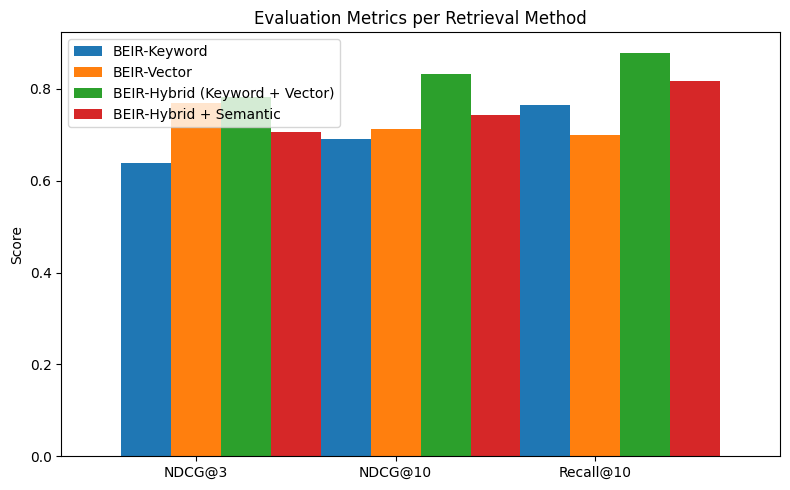

In [7]:
def load_run_dict(run_file):
    with open(os.path.join(root, dataset_dir, run_file), "r", encoding="utf-8") as f:
        run_data = [json.loads(line) for line in f if line.strip()]
    return {entry["query"]: entry["ranking"] for entry in run_data}

# Load qrels data (list of dictionaries) and convert to nested dict format.
qrels_dict = {q: {entry["document"]: int(entry["relevant"])
                  for entry in qrels_data if entry["query"] == q}
              for q in {entry["query"] for entry in qrels_data}}

# Define ranking files for the three retrieval methods.
ranking_files = {
    "BEIR-Keyword": "rankings-keyword.jsonl",
    "BEIR-Vector": "rankings-vector.jsonl",
    "BEIR-Hybrid (Keyword + Vector)": "rankings-hybrid.jsonl",
    "BEIR-Hybrid + Semantic": "rankings-hybrid-semantic.jsonl",
}

# Initialize a dictionary to store metrics for each retrieval method.
metrics_results = {}

# Create the BEIR evaluator.
evaluator = EvaluateRetrieval()

# For each ranking file, load the run, evaluate, and store the desired metrics.
for method_name, run_file in ranking_files.items():
    run_dict = load_run_dict(run_file)
    results = evaluator.evaluate(qrels_dict, run_dict, k_values=[3, 10])
    metrics_results[method_name] = {
        "NDCG@3": results[0]["NDCG@3"],
        "NDCG@10": results[0]["NDCG@10"],
        "Recall@10": results[2]["Recall@10"]
    }

# Create a DataFrame from the metrics results.
df = pd.DataFrame(metrics_results, index=["NDCG@3", "NDCG@10", "Recall@10"])
print("Evaluation Metrics:")
print(df)

# Plot the results as a grouped bar chart.
metrics = df.index.tolist()          # Metrics on x-axis.
methods = df.columns.tolist()        # Retrieval methods.
x = np.arange(len(metrics))          # Label positions.
width = 0.25                         # Bar width

fig, ax = plt.subplots(figsize=(8, 5))
for idx, method in enumerate(methods):
    ax.bar(x + idx * width, df[method], width, label=method)

# Customize plot appearance.
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics per Retrieval Method')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
ax.margins(x=0.1)  # Adjust the fraction as needed

plt.tight_layout()
plt.show()